# import modules

In [1]:
import os
import sys
import re
import pickle
import random
import subprocess
import time
import threading
import shutil
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, wait, ALL_COMPLETED
from datetime import datetime, timedelta
from multiprocessing import Process, Pool

import numpy as np
import pandas as pd
import anndata as ad
import h5py
# import Bio
# from Bio import motifs
import pysam
import pyranges
import pybedtools
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sklearn
from sklearn import preprocessing
import scipy
from scipy import io
import scanpy as sc
from sklearn.cluster import KMeans
from adjustText import adjust_text
# import episcanpy
import ruamel.yaml
yaml = ruamel.yaml.YAML(typ="safe")
yaml.default_flow_style = False


import SCRIPT
from SCRIPT.utilities import utils
from SCRIPT.utilities.utils import print_log, safe_makedirs

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

plt.rcParams.update({
    'figure.figsize': [8.0, 8.0],
    'font.size' : 15,
    'font.family': 'Arial',
    'font.style' : 'normal',
    'font.weight':'bold',
    'figure.titleweight': 'bold',
    'axes.labelsize': 14 ,
    'axes.titleweight': 'normal',
    'axes.labelweight': 'bold',
    'axes.spines.right': False,
    'axes.spines.top': False,
})

N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(220/256, 34/256, N)
vals[:, 1] = np.linspace(220/256, 7/256, N)
vals[:, 2] = np.linspace(220/256, 141/256, N)
regulation_cmp = mpl.colors.ListedColormap(vals)

In [2]:
def umap_table(script_table_cell_tf, metadata):
    sudo_expression_SCRIPT = ad.AnnData(script_table_cell_tf)
#     sc.pp.highly_variable_genes(sudo_expression_SCRIPT)
#     sc.pp.highly_variable_genes(rna_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
    sc.tl.pca(sudo_expression_SCRIPT, svd_solver='arpack', use_highly_variable=False)
    sc.pl.pca_variance_ratio(sudo_expression_SCRIPT, log=True)
    sc.pp.neighbors(sudo_expression_SCRIPT, n_neighbors=10, n_pcs=30)
    sc.tl.umap(sudo_expression_SCRIPT)
    sc.tl.louvain(sudo_expression_SCRIPT, resolution=0.8)
    sudo_expression_SCRIPT.obs['real_cell_type']=metadata['assign.celltype'][sudo_expression_SCRIPT.obs.index]
    sudo_expression_SCRIPT.obs['nFeature_ATAC']=metadata['nFeature_ATAC'][sudo_expression_SCRIPT.obs.index]
    sc.pl.umap(sudo_expression_SCRIPT, color=['louvain','real_cell_type'], color_map=regulation_cmp)
    print(sklearn.metrics.normalized_mutual_info_score(sudo_expression_SCRIPT.obs['louvain'], sudo_expression_SCRIPT.obs['real_cell_type']))
    print(sklearn.metrics.adjusted_mutual_info_score(sudo_expression_SCRIPT.obs['louvain'], sudo_expression_SCRIPT.obs['real_cell_type']))
    return sudo_expression_SCRIPT

In [7]:
os.sys.path

['/fs/home/dongxin/Projects/SCRIPT/scATAC/notebook',
 '/fs/home/dongxin/Applications/miniconda3/lib/python39.zip',
 '/fs/home/dongxin/Applications/miniconda3/lib/python3.9',
 '/fs/home/dongxin/Applications/miniconda3/lib/python3.9/lib-dynload',
 '',
 '/fs/home/dongxin/Applications/miniconda3/lib/python3.9/site-packages',
 '/fs/home/dongxin/Applications/miniconda3/lib/python3.9/site-packages/IPython/extensions',
 '/fs/home/dongxin/.ipython']

In [4]:
import ruamel.yaml
yaml = ruamel.yaml.YAML(typ="safe")
yaml.default_flow_style = False

In [15]:
a = yaml.load("""a:\n  b: 2\n  c: 3\n""")

In [16]:
with open('./test.yml', 'w+') as f:
    yaml.dump(a,f)

In [18]:
def read_SingleCellExperiment_rds(input_RDS):
    import anndata2ri
    from rpy2.robjects import r
    anndata2ri.activate()
    rscript = 'readRDS("{RDS_file_path}")'.format(RDS_file_path = input_RDS)
    adata = r(rscript)
    adata.var.columns = [str(i) for i in adata.var.columns]
    adata.obs.columns = [str(i) for i in adata.obs.columns]
    return adata

In [ ]:
sc.settings.verbosity = 3
# sc.logging.print_header()
sc.logging.print_versions()

# Config

In [4]:
plt.rcParams.update({
    'figure.figsize': [8.0, 8.0],
    'font.size' : 15,
    'font.family': 'Arial',
    'font.style' : 'normal',
    'font.weight':'bold',
    'figure.titleweight': 'bold',
    'axes.labelsize': 14 ,
    'axes.titleweight': 'normal',
    'axes.labelweight': 'bold',
    'axes.spines.right': False,
    'axes.spines.top': False,
})

N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(220/256, 34/256, N)
vals[:, 1] = np.linspace(220/256, 7/256, N)
vals[:, 2] = np.linspace(220/256, 141/256, N)
regulation_cmp = mpl.colors.ListedColormap(vals)

In [6]:
def print_full(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')

In [407]:
human_chip_index = '/fs/home/dongxin/Projects/SCRIPT/indices/human/ChIP_top10k'
human_motif_index = '/fs/home/dongxin/Projects/SCRIPT/indices/human/motif_top10k_resize'
mouse_chip_index = '/fs/home/dongxin/Projects/SCRIPT/indices/mouse/ChIP_top10k'
mouse_motif_index = '/fs/home/dongxin/Projects/SCRIPT/indices/mouse/motif_top10k_resize'

# human_motif_index = '/mnt/Storage/home/dongxin/Projects/scATAC/index/human_motif_index'
# mouse_chip_index = '/mnt/Storage/home/dongxin/Projects/scATAC/index/mouse_ChIP_index'
# mouse_motif_index = '/mnt/Storage/home/dongxin/Projects/scATAC/index/mouse_motif_index'

In [3]:
I_tf_list = ['I_TBX21', 'I_IRF8', 'I_CEBPA', 'I_CEBPB', 'I_MYB', 'I_BCL11A', 'I_BCL11B', 'I_STAT1', 'I_SOX10', 'I_EBF1', 'I_BRD4']
C_tf_list = [i.replace('I_', 'C_') for i in I_tf_list]
non_tf_list = [i.replace('I_', '') for i in I_tf_list]

In [5]:
def cal_deviation(val, mean, std):
    return (val-mean)/std


def cal_deviation_table(fg_table, bg_table, i):
    print_log('chunk {i} calculating ...'.format(i=i))
    dts_cell_result_table_deviation = fg_table.copy()
    for factor in fg_table.index:
        factor_bg = bg_table.loc[factor, :].tolist()
        bg_mean = np.mean(factor_bg)
        bg_std = np.std(factor_bg)
        if bg_mean != 0 and bg_std != 0:
            dts_cell_result_table_deviation.loc[factor, :] = fg_table.loc[factor, :].apply(
                cal_deviation, **{'mean': bg_mean, 'std': bg_std})
        else:
            dts_cell_result_table_deviation.loc[factor, :] = 0
    print_log('chunk {i} finished calculation!'.format(i=i))
    return dts_cell_result_table_deviation


def cal_deviation_table_batch(fg_table, bg_table, n_cores=8):
    print_log("Calculating deviation, divide into {n} chunks...".format(n=n_cores))
    fg_table_split = np.array_split(fg_table, n_cores)
    args = [[table, bg_table, i] for (i, table) in enumerate(fg_table_split)]
    with Pool(n_cores) as p:
        result = p.starmap(cal_deviation_table, args)
    print_log("Generating P value table ...")
    dts_cell_result_table_deviation = pd.concat([i for i in result])
    print_log('Finished calculation enrichment!')
    return dts_cell_result_table_deviation

## RP calculation

In [9]:
# def ExtractGeneInfo(gene_bed):
#     """Extract gene information from gene bed file."""

#     bed = pd.read_csv(gene_bed, sep="\t", header=0, index_col=False)
#     bed['transcript'] = [x.strip().split(".")[0] for x in bed['name'].tolist()]
#     bed['tss'] = bed.apply(lambda x: x['txStart'] if x['strand']=='+' else x['txEnd'], axis=1)

#     ### adjacent P+GB
#     bed["start"] = bed.apply(lambda x: x['txStart']-2000 if x['strand']=='+' else x['txStart'], axis=1)
#     bed["end"] = bed.apply(lambda x: x['txEnd']+2000 if x['strand']=='-' else x['txEnd'], axis=1)
    
#     bed['promoter'] = bed.apply(lambda x: tuple([x['tss']-2000, x['tss']+2000]), axis=1)
#     bed['exons'] = bed.apply(lambda x: tuple([(int(i), int(j)) for i, j in zip(x['exonStarts'].strip(',').split(','), x['exonEnds'].strip(',').split(','))]), axis=1)

#     ### exon length
#     bed['length'] = bed.apply(lambda x: sum(list(map(lambda i: (i[1]-i[0])/1000.0, x['exons']))), axis=1)
#     bed['uid'] = bed.apply(lambda x: "%s@%s@%s"%(x['name2'], x['start'], x['end']), axis=1)
#     bed = bed.drop_duplicates(subset='uid', keep="first")
#     gene_info = []
#     for irow, x in bed.iterrows():
#         gene_info.append([x['chrom'], x['start'], x['end'], x['tss'], x['promoter'], x['exons'], x['length'], 1, x['uid']])
#     ### [chrom_0, start_1, end_2, tss_3, promoter_4, exons_5, length_6(kb), 1_7, uid_8(genename@start@end)]
#     return gene_info

In [117]:
def geneInfoSimple(gene_bed):
    genes_info = []
    genes_list = []
    fhd = open(gene_bed, 'rt')
    fhd.readline() # skip the first line. In our current gene txt file, there is no '#' in the first line. We need to, perhaps, use the 'ExtractGeneInfo' function.
    for line in fhd:
        line = line.strip().split('\t')
        if not line[0].startswith('#'):
            if line[3] == "+":
                genes_info.append((line[2], int(line[4]), 1, "%s@%s@%s" % (line[12], line[2], line[4])))
            else:
                genes_info.append((line[2], int(line[5]), 1, "%s@%s@%s" % (line[12], line[2], line[5])))
                # gene_info [chrom, tss, 1, gene_unique]
    fhd.close()
    genes_info = list(set(genes_info))
    for igene in range(len(genes_info)):
        tmp_gene = list(genes_info[igene])
        genes_list.append(tmp_gene[3])
        tmp_gene[3] = igene
        genes_info[igene] = tmp_gene
    return genes_info, genes_list

In [118]:
def RP_Simple(peaks_info, genes_info, decay):
    """Multiple processing function to calculate regulation potential."""

    Sg = lambda x: 2**(-x)
    gene_distance = 15 * decay
    genes_peaks_score_array = sp.sparse.dok_matrix((len(genes_info), len(peaks_info)), dtype=np.float64)

    w = genes_info + peaks_info

    A = {}

    w.sort()
    for elem in w:
        if elem[2] == 1:
            A[elem[-1]] = [elem[0], elem[1]]
        else:
            dlist = []
            for gene_name in list(A.keys()):
                g = A[gene_name]
                tmp_distance = abs(elem[1] - g[1])
                if (g[0] != elem[0]) or (tmp_distance > gene_distance):
                    dlist.append(gene_name)
                else:
                    genes_peaks_score_array[gene_name, elem[-1]] = Sg(tmp_distance / decay)
            for gene_name in dlist:
                del A[gene_name]

    w.reverse()
    for elem in w:
        if elem[2] == 1:
            A[elem[-1]] = [elem[0], elem[1]]
        else:
            dlist = []
            for gene_name in list(A.keys()):
                g = A[gene_name]
                tmp_distance = abs(g[1] - elem[1])
                if (g[0] != elem[0]) or (tmp_distance > gene_distance):
                    dlist.append(gene_name)
                else:
                    genes_peaks_score_array[gene_name, elem[-1]] = Sg(tmp_distance / decay)
            for gene_name in dlist:
                del A[gene_name]

    return(genes_peaks_score_array)

In [119]:
def cal_neighbor_cell_peak_mat(table, input_mat, coor_table, impute_n, i):
    print(i)
    for cell_barcode in table.index:
        nearest_bc = find_nearest_cells(cell_barcode, coor_table, n_neighbor=impute_n)
#         table.loc[cell_barcode,:] = [1 if i else 0 for i in input_mat.loc[nearest_bc,:].sum() >= 1]
        table.loc[cell_barcode,:] = input_mat.loc[nearest_bc,:].sum()
    return table

def cal_neighbor_cell_peak_mat_batch(input_mat, coor_table, impute_n, n_cores=8):
    print_log("Calculating enrichment, divide into {n} chunks...".format(n=n_cores))
    input_table_split = np.array_split(input_mat, n_cores)
    args = [[table, input_mat, coor_table, impute_n, i] for (i, table) in enumerate(input_table_split)]
    with Pool(n_cores) as p:
        result = p.starmap(cal_neighbor_cell_peak_mat, args)
    cell_peak = pd.concat([i for i in result])
    print_log('finished!')
#     return sp.sparse.csr_matrix(cell_peak)
    return cell_peak

In [6]:
def score_normalization(dataset_odds_ratio_df, dataset_fisher_df, peak_number_norm_coef):
    # fisher normalize matrix
    fisher_log_foreground = -np.log10(dataset_fisher_df)
    fisher_log_foreground_true_table = (fisher_log_foreground.T/fisher_log_foreground.max(1)).T
    fisher_log_foreground_true_table = fisher_log_foreground_true_table.reindex(
        index=dataset_odds_ratio_df.index, columns=dataset_odds_ratio_df.columns)

    peak_number_norm_coef_table = peak_number_norm_coef.reindex(
        index=dataset_odds_ratio_df.index, columns=dataset_odds_ratio_df.columns)

    # key multiply
    fg_dataset_cell_score_df = dataset_odds_ratio_df * fisher_log_foreground_true_table * peak_number_norm_coef_table
    return fg_dataset_cell_score_df


def cal_peak_norm_matrix(index_peak_number_path, peaks_number_path):
    index_peak_number = pd.read_csv(index_peak_number_path, sep='\t', header=None, index_col=0)
    data_peak_number = pd.read_csv(peaks_number_path, sep='\t', header=None, index_col=0)
    data_peak_number.index = data_peak_number.index.astype(str)
    peak_cell_index_norm_table = pd.DataFrame(np.zeros([index_peak_number.index.__len__(), data_peak_number.index.__len__()]),
                                              index=index_peak_number.index, columns=data_peak_number.index)
    for dts in peak_cell_index_norm_table.index:
        dts_number = index_peak_number.loc[dts, 1]
        peak_cell_index_norm_table.loc[dts, :] = [i/dts_number if i <= dts_number else dts_number/i for i in data_peak_number[1]]
    peak_cell_index_norm_table = peak_cell_index_norm_table.reindex(index=index_peak_number.index, columns=data_peak_number.index)

    peak_number_dts_mean_value = data_peak_number[1].mean()
    peak_number_dts_norm_series = data_peak_number[1].apply(lambda x: 2**-(abs(x-peak_number_dts_mean_value)/x))
    peak_number_dts_norm_series = peak_number_dts_norm_series.reindex(index=data_peak_number.index)

    peak_number_norm_coef = peak_cell_index_norm_table * peak_number_dts_norm_series

    return peak_number_norm_coef

# data test

In [2]:
def map_factor_on_ChIP(table):
    # map factor by id "_"
    factor_index_list = []
    for i in table.index:
        factor_name = i.split("_")
        factor_index_list.append(factor_name[1])
    table.loc[:,"Factor"] = factor_index_list
    return table.groupby("Factor").max()


def read_giggle_result_overlap(files, i):
    for i in range(len(files)):
        giggle_result = os.path.basename(files[i])
        cell_bc = giggle_result[:-4]  # remove suffix '.txt'
        dtframe = pd.read_csv(files[i], sep="\t", index_col=False)
        if i == 0:
            dtframe = dtframe.loc[:, ["#file", "overlaps"]]
            total = dtframe.rename(
                columns={'overlaps': cell_bc}).copy()
        else:
            newcol = dtframe[["overlaps"]]
            total[cell_bc] = newcol
    idList = [i[:-7] for i in total['#file']]  # remove suffix '.bed.gz'
    total = total.rename(columns={"#file": "id"})
    total["id"] = idList
    total = total.set_index("id")
    return total

def read_giggle_result_overlap_batch(path, n_cores=8, tp=''):
    print_log(
        "Reading searching results of overlap, using {n} cores...".format(n=n_cores))
    file_list = os.listdir(path)
    result_split = np.array_split(file_list, n_cores)
    args = [[[os.path.join(path, j) for j in list_chunk], i]
            for (i, list_chunk) in enumerate(result_split)]
    with Pool(n_cores) as p:
        result = p.starmap(read_giggle_result_overlap, args)
    total = pd.concat([i for i in result], axis=1)
    return total

    
def map_factor_on_ChIP(table):
    table_ret=table.copy()
    # map factor by id "_"
    factor_index_list = []
    for i in table.index:
        factor_name = i.split("_")
        factor_index_list.append(factor_name[1])
    table_ret.loc[:,"Factor"] = factor_index_list
    return table_ret.groupby("Factor").max()


def umap_table(script_table_cell_tf, metadata):
    sudo_expression_SCRIPT = ad.AnnData(script_table_cell_tf)
#     sc.pp.highly_variable_genes(sudo_expression_SCRIPT)
    sc.tl.pca(sudo_expression_SCRIPT, svd_solver='arpack', use_highly_variable=False)
#     sc.pl.pca_variance_ratio(sudo_expression_SCRIPT, log=True)
    sc.pp.neighbors(sudo_expression_SCRIPT, n_neighbors=10, n_pcs=30)
    sc.tl.umap(sudo_expression_SCRIPT)
    sc.tl.louvain(sudo_expression_SCRIPT, resolution=0.6)
    sudo_expression_SCRIPT.obs['real_cell_type']=metadata['assign.celltype'][sudo_expression_SCRIPT.obs.index]
    sudo_expression_SCRIPT.obs['nFeature_ATAC']=metadata['nFeature_ATAC'][sudo_expression_SCRIPT.obs.index]
    sc.pl.umap(sudo_expression_SCRIPT, color=['louvain','real_cell_type','nFeature_ATAC'], color_map=regulation_cmp)
    return sudo_expression_SCRIPT
# sc.pl.umap(sudo_expression_SCRIPT, color=['louvain','real_cell_type','nFeature_ATAC'], color_map=regulation_cmp)

def read_giggle_result_overlap(files, i):
    for i in range(len(files)):
        giggle_result = os.path.basename(files[i])
        cell_bc = giggle_result[:-4]  # remove suffix '.txt'
        dtframe = pd.read_csv(files[i], sep="\t", index_col=False)
        if i == 0:
            dtframe = dtframe.loc[:, ["#file", "overlaps"]]
            total = dtframe.rename(
                columns={'overlaps': cell_bc}).copy()
        else:
            newcol = dtframe[["overlaps"]]
            total[cell_bc] = newcol
    idList = [i[:-7] for i in total['#file']]  # remove suffix '.bed.gz'
    total = total.rename(columns={"#file": "id"})
    total["id"] = idList
    total = total.set_index("id")
    return total

def read_giggle_result_overlap_batch(path, n_cores=8, tp=''):
    print_log(
        "Reading searching results of overlap, using {n} cores...".format(n=n_cores))
    file_list = os.listdir(path)
    result_split = np.array_split(file_list, n_cores)
    args = [[[os.path.join(path, j) for j in list_chunk], i]
            for (i, list_chunk) in enumerate(result_split)]
    with Pool(n_cores) as p:
        result = p.starmap(read_giggle_result_overlap, args)
    total = pd.concat([i for i in result], axis=1)
    return total

def search_seqpare(bed_path, result_path, index_path):
#     bed = bed_path.split("/")[-1]
#     if bed_path.endswith('gz'):
    cmd = 'seqpare "{index_path}/*" "{bed_path}" -m 1 -o {result_path}\n'.format(
        index_path=index_path, result_path=result_path, bed_path=bed_path)
#     print(cmd)
#     else:
#         cmd = 'sort --buffer-size 2G -k1,1 -k2,2n -k3,3n {bed_path} | bgzip -c > {bed_path}.gz\n'.format(bed_path=bed_path)
#         cmd += 'giggle search -i {index_path} -s -q {bed_path}.gz > {result_path}\n'.format(index_path=index_path, result_path=result_path, bed_path=bed_path)
#         cmd += 'rm {bed_path}'.format(bed_path=bed_path)
    subprocess.run(cmd, shell=True, check=True)


def search_seqpare_batch(bed_folder, result_folder, index_path, n_cores=8, tp=['','']):
    print_log('Start searching {ground} beds from {tp} index ...'.format(ground=tp[0], tp=tp[1]))
    safe_makedirs(result_folder)
    beds = os.listdir(bed_folder)
    args = []
    for bed in beds:
        barcodes = bed[:-7] # remove suffix '.bed.gz'
        args.append((os.path.join(bed_folder, bed), 
                     os.path.join(result_folder, barcodes + '.txt'), 
                     index_path))
    with Pool(n_cores) as p:
        p.starmap(search_seqpare, args)
    print_log('Finished searching {ground} beds from {tp} index ...'.format(ground=tp[0], tp=tp[1]))
    
def read_seqpare_result(files):
    for i in range(len(files)):
        giggle_result = os.path.basename(files[i])
        cell_bc = giggle_result[:-4]  # remove suffix '.txt'
        dtframe = pd.read_csv(files[i], sep="\t", index_col=5)
        if i == 0:
            dtframe = dtframe.loc[:,['teo']].copy()
            dataset_cell_score_df = dtframe.rename(columns={'teo': cell_bc})
        else:
            dataset_cell_score_df[cell_bc] = dtframe.loc[:,"teo"]
    dataset_cell_score_df.index = [i.rsplit('/', 1)[1][:-7] for i in dataset_cell_score_df.index] # remove suffix '.bed.gz'
    return dataset_cell_score_df


def read_seqpare_result_batch(path, n_cores=8, tp=''):
    print_log("Reading searching results, using {n} cores...".format(n=n_cores))
    file_list = os.listdir(path)
    result_split = np.array_split(file_list, n_cores)
    args = [[[os.path.join(path, j) for j in list_chunk]] for list_chunk in result_split]
    with Pool(n_cores) as p:
        result = p.starmap(read_seqpare_result, args)
    dataset_cell_score_df = pd.concat([i for i in result], axis=1)
    print_log("Finished reading {tp} index search result!".format(tp=tp))
    return dataset_cell_score_df

def cal_deviation(val, mean, std):
    return (val-mean)/std


def cal_deviation_table(fg_table, bg_table, i):
    print_log('chunk {i} calculating ...'.format(i=i))
    dts_cell_result_table_deviation = fg_table.copy()
    for factor in fg_table.index:
        factor_bg = bg_table.loc[factor, :].tolist()
        bg_mean = np.mean(factor_bg)
        bg_std = np.std(factor_bg)
        if bg_mean != 0 and bg_std != 0:
            dts_cell_result_table_deviation.loc[factor, :] = fg_table.loc[factor, :].apply(
                cal_deviation, **{'mean': bg_mean, 'std': bg_std})
        else:
            dts_cell_result_table_deviation.loc[factor, :] = 0
    print_log('chunk {i} finished calculation!'.format(i=i))
    return dts_cell_result_table_deviation

def cal_deviation_table_batch(fg_table, bg_table, n_cores=8):
    print_log("Calculating enrichment, divide into {n} chunks...".format(n=n_cores))
    fg_table_split = np.array_split(fg_table, n_cores)
    args = [[table, bg_table, i] for (i, table) in enumerate(fg_table_split)]
    with Pool(n_cores) as p:
        result = p.starmap(cal_deviation_table, args)
    dts_cell_result_table_deviation = pd.concat([i for i in result])
    print_log('Finished calculation enrichment!')
    return dts_cell_result_table_deviation

In [5]:
script_adata = sc.read_h5ad('example/small_HSC/small_HSC_SCRIPT_20210712/enrichment/SCRIPT_enrichment.h5ad')

In [42]:
search_seqpare_batch('example/small_HSC/small_HSC_SCRIPT_20210630/enrichment/fg_files/fg_bed/', 'example/small_HSC/small_HSC_SCRIPT_20210630/enrichment/fg_files/seqpare_result_motif/', human_motif_index, n_cores=32, tp=['',''])

background_cell_score_df = read_seqpare_result_batch('example/small_HSC/small_HSC_SCRIPT_20210630/enrichment/bg_files/seqpare_result/', n_cores=32)
bg_peak_number.index = bg_peak_number.index.astype(str)

bg_peak_norm_hyper = (ref_peak_number.dot(bg_peak_number.T)/926535).reindex(index=background_cell_score_df.index, columns=background_cell_score_df.columns)

bg_tmp = background_cell_score_df/bg_peak_norm_hyper

dev = cal_deviation_table_batch(tmp,bg_tmp)

dev.std(1).sort_values()

%%time
dataset_cell_score_df = read_seqpare_result_batch('example/small_HSC/small_HSC_SCRIPT_20210630/enrichment/fg_files/seqpare_result/', n_cores=32)

bg_peak_number.index.astype(str)

tmp = sc.read_h5ad('../python/test/project/enrichment/SCRIPT_enrichment.h5ad')

tmp

sc.pl.umap(tmp,color=['assign.celltype','I_GATA4','I_SPI1'])

tmp

# peak_norm = pd.DataFrame(np.zeros([ref_peak_number_series.__len__(), fg_peak_number_series.__len__()]), index = ref_peak_number_series.index, columns = fg_peak_number_series.index)
# for i in ref_peak_number.index:
#     peak_norm.loc[i,:] = ref_peak_number_series[i]/fg_peak_number_series
# #     peak_norm.loc[i,:] = 1/fg_peak_number_series

peak_norm_hyper = (ref_peak_number.dot(fg_peak_number.T)/926535).reindex(index=dataset_cell_score_df.index, columns=dataset_cell_score_df.columns)

tmp = dataset_cell_score_df/peak_norm_hyper
tmp_zscore = tmp.apply(sp.stats.zscore, axis=0)
dataset_cell_score_df_max = map_factor_on_ChIP(tmp_zscore)

dev_zscore = dev.apply(sp.stats.zscore, axis=0)
dev_cell_score_df_max = map_factor_on_ChIP(dev_zscore)

tmp.iloc[0:50,0:20]

dataset_cell_score_df["singles-BM0106-HSC-LS-160219-87"].sort_values()

tmp.max(1).sort_values()



tmp_zscore.min(1).sort_values()

sns.displot(tmp_zscore.loc[:,"singles-BM0106-HSC-LS-160219-63"])

corr_list = []
fg_peak_number_series = fg_peak_number[1].reindex(dataset_cell_score_df.columns)
for i in dataset_cell_score_df.index:
    corr = tmp_zscore.loc[i,:].corr(fg_peak_number_series)
    corr_list.append(corr)
#     print(i, corr, ref_peak_number[1][i])
print(np.mean(corr_list))

corr_list = []
ref_peak_number_series = ref_peak_number[1].reindex(dataset_cell_score_df.index)
for i in dataset_cell_score_df.columns:
    corr = tmp_zscore.loc[:,i].corr(ref_peak_number_series)
    corr_list.append(corr)
#     print(i, corr, fg_peak_number[1][i])
print(np.mean(corr_list))

fg_peak_number_series = fg_peak_number[1].reindex(tmp.columns)
for i in tmp.index:
    print(i, tmp.loc[i,:].corr(fg_peak_number_series), ref_peak_number[1][i])



dataset_cell_score_df_max = map_factor_on_ChIP(tmp_zscore)

sklearn.metrics.normalized_mutual_info_score(tmp_adata.obs['real_cell_type'], tmp_adata.obs['louvain'])

dataset_cell_score_df_max.to_csv('example/small_HSC/script_pseudotime/score.txt', sep='\t')

tmp.uns['ChIP'].loc[metadata.index,:].copy()

orig.ident  nCount_ATAC  \
singles-BM0828-HSC-fresh-151027-1   HSC-BM0828-151027-1       3804.0   
singles-BM0828-HSC-fresh-151027-2   HSC-BM0828-151027-2       5312.0   
singles-BM0828-HSC-fresh-151027-3   HSC-BM0828-151027-3       7613.0   
singles-BM0828-HSC-fresh-151027-4   HSC-BM0828-151027-4       8764.0   
singles-BM0828-HSC-fresh-151027-5   HSC-BM0828-151027-5       5797.0   
...                                                 ...          ...   
singles-160822-BM1137-CMP-LS-89    CMP-BM1137-160822-89        563.0   
singles-160822-BM1137-CMP-LS-91    CMP-BM1137-160822-91      21127.0   
singles-160822-BM1137-CMP-LS-93    CMP-BM1137-160822-93       2113.0   
singles-160822-BM1137-CMP-LS-95    CMP-BM1137-160822-95      20470.0   
singles-160822-BM1137-CMP-LS-96    CMP-BM1137-160822-96       3266.0   

                                   nFeature_ATAC ATAC_snn_res.0.6  \
singles-BM0828-HSC-fresh-151027-1           3327                2   
singles-BM0828-HSC-fresh-151027-2           4598                2   
singles-BM0828-HSC-fresh-151027-3           6636                2   
singles-BM0828-HSC-fresh-151027-4           7353                2   
singles-BM0828-HSC-fresh-151027-5           4941                2   
...                                          ...              ...   
singles-160822-BM1137-CMP-LS-89              551                5   
singles-160822-BM1137-CMP-LS-91            16216                4   
singles-160822-BM1137-CMP-LS-93             1914                4   
singles-160822-BM1137-CMP-LS-95            16177                2   
singles-160822-BM1137-CMP-LS-96             2914                4   

                                  seurat_clusters ident assign.celltype  
singles-BM0828-HSC-fresh-151027-1               2     2             HSC  
singles-BM0828-HSC-fresh-151027-2               2     2             HSC  
singles-BM0828-HSC-fresh-151027-3               2     2             HSC  
singles-BM0828-HSC-fresh-151027-4               2     2             HSC  
singles-BM0828-HSC-fresh-151027-5               2     2             HSC  
...                                           ...   ...             ...  
singles-160822-BM1137-CMP-LS-89                 5     5             CMP  
singles-160822-BM1137-CMP-LS-91                 4     4             CMP  
singles-160822-BM1137-CMP-LS-93                 4     4             CMP  
singles-160822-BM1137-CMP-LS-95                 2     2             CMP  
singles-160822-BM1137-CMP-LS-96                 4     4             CMP  

[2429 rows x 7 columns]

In [ ]:
tmp_adata = umap_table(script_adata.uns['integrated'].loc[metadata.index,:].copy(), metadata)

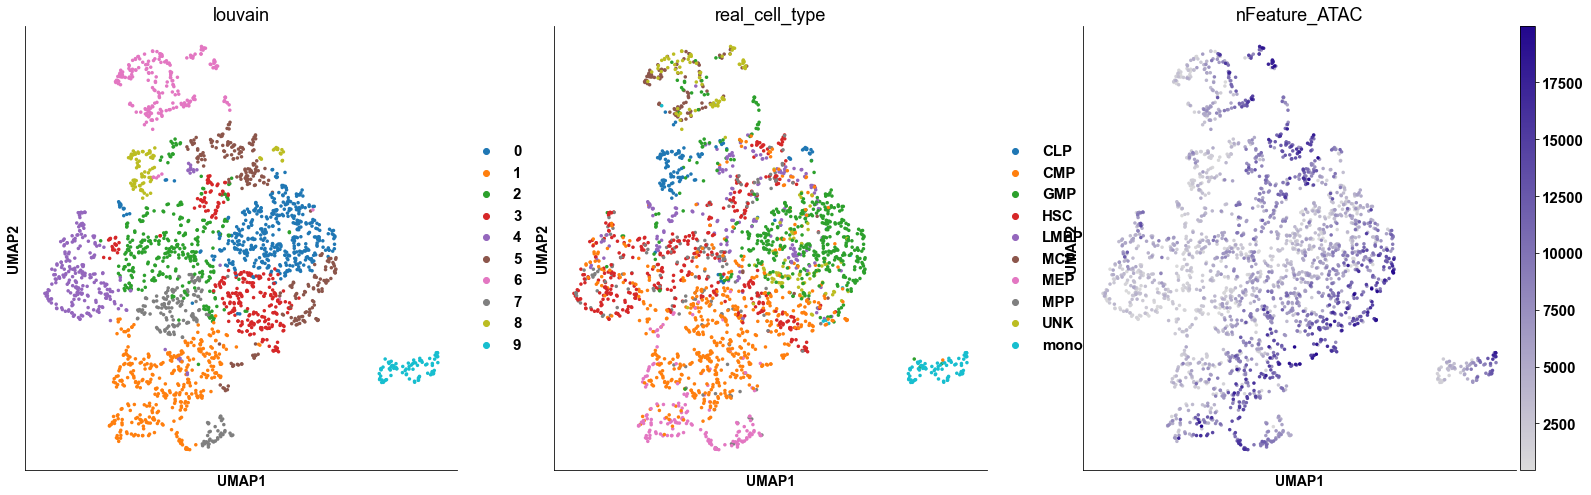

In [10]:
tmp_adata = umap_table(script_adata.uns['ChIP'].loc[metadata.index,:].copy(),metadata)

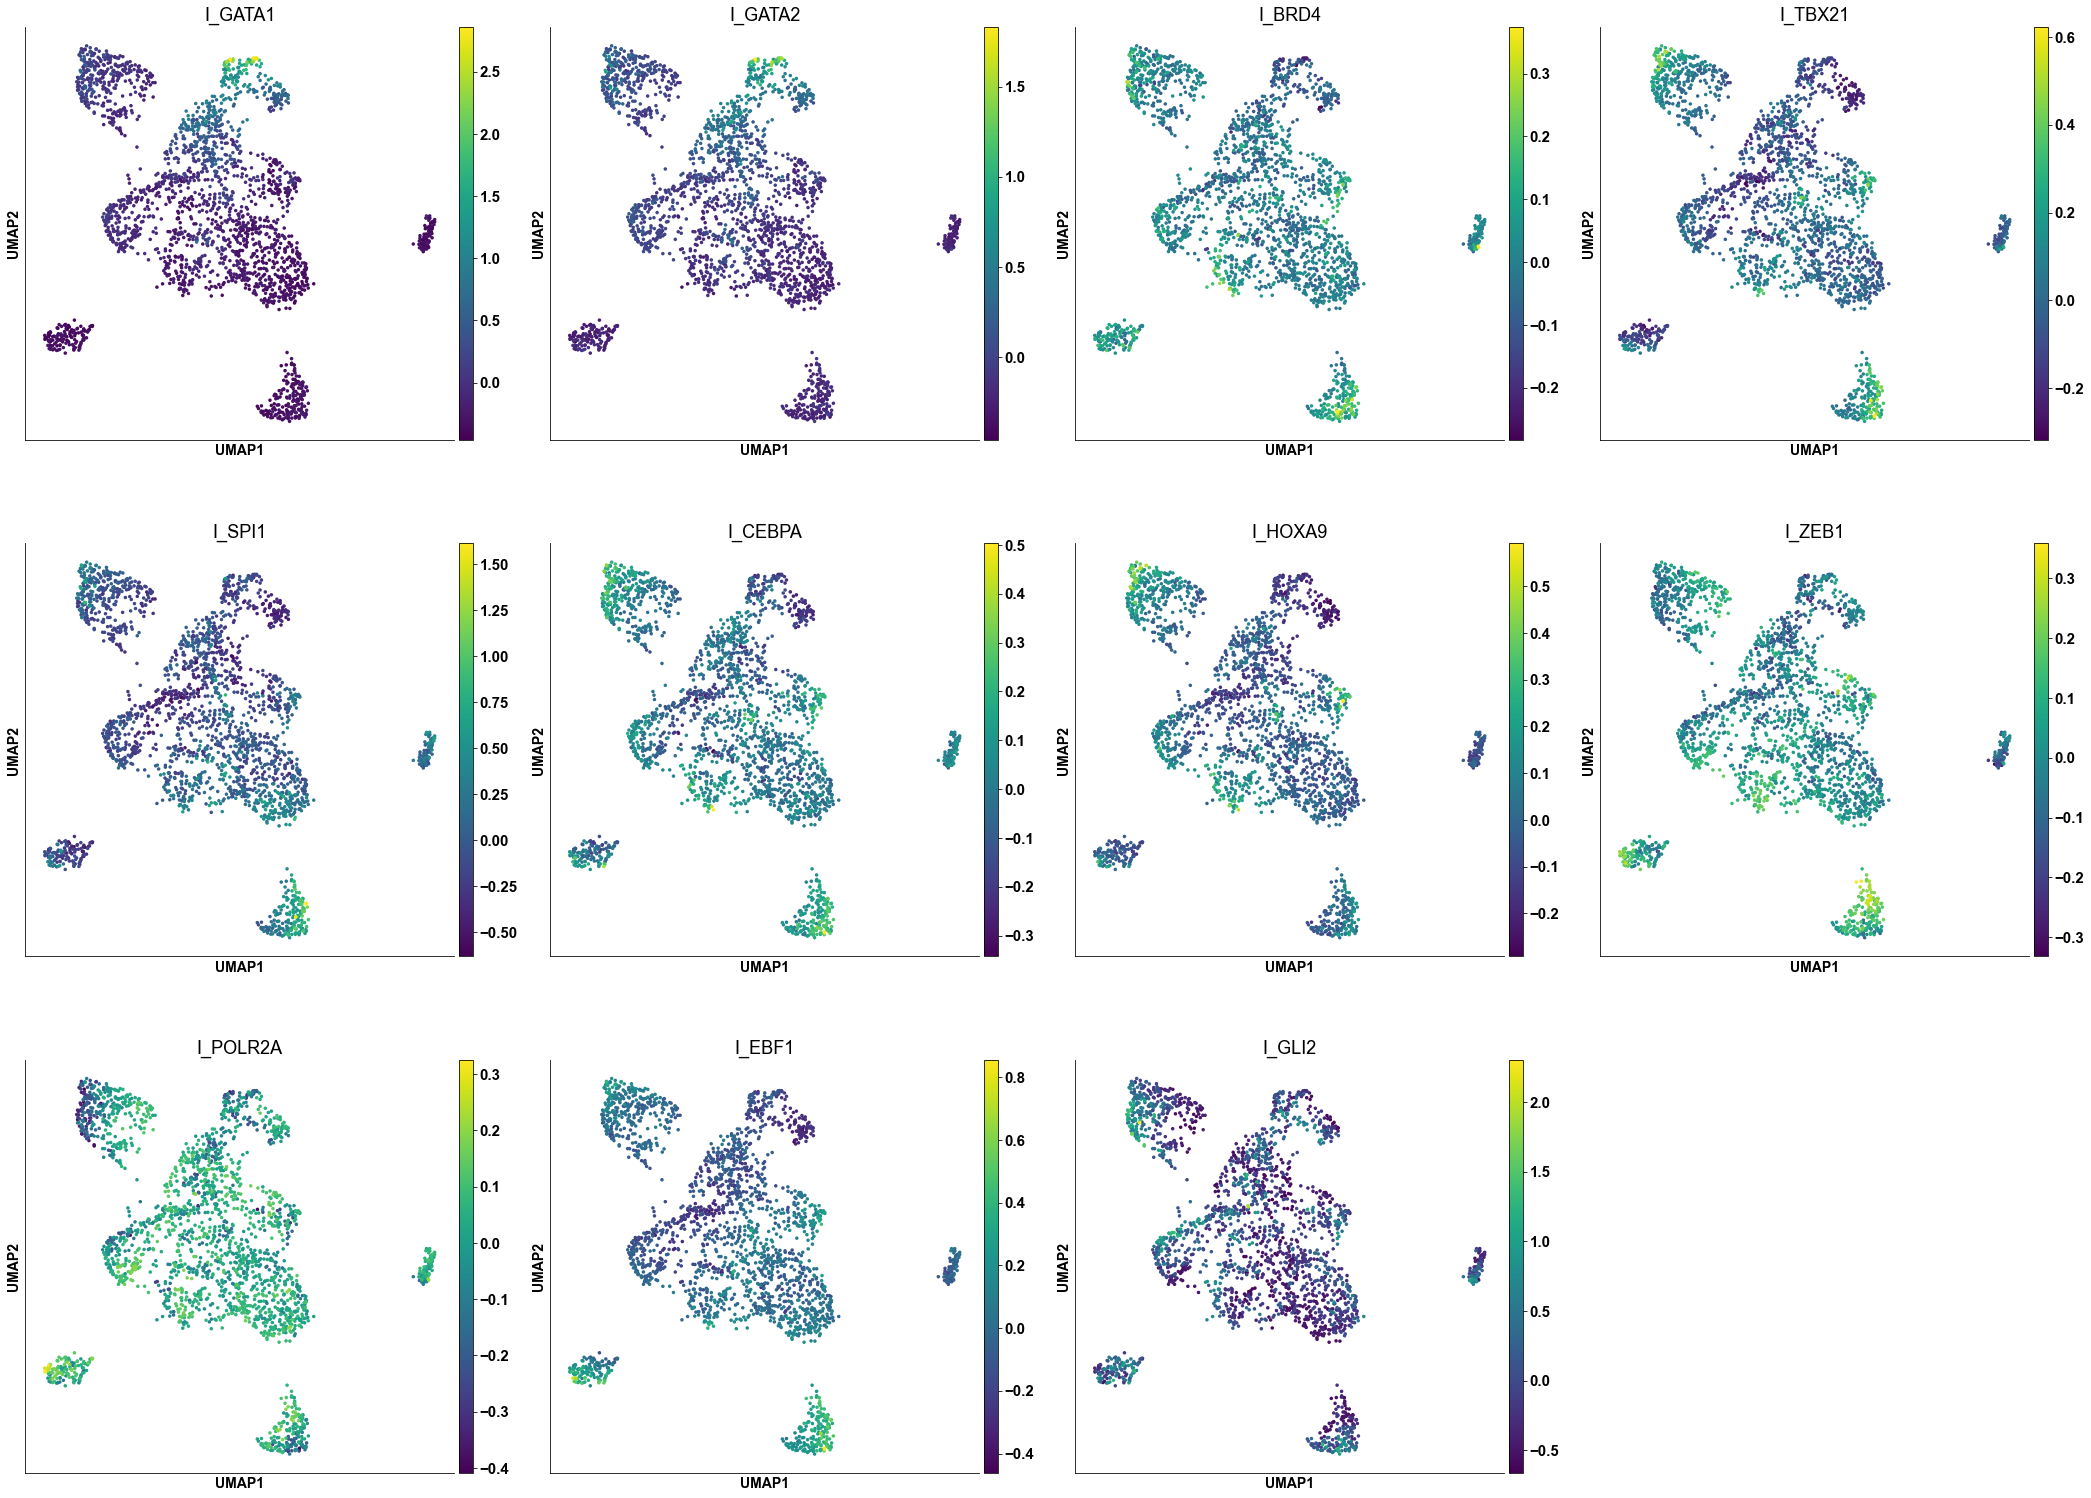

In [13]:
sc.pl.umap(script_adata,color=['I_'+i for i in ['GATA1','GATA2','BRD4','TBX21','SPI1','CEBPA','HOXA9','ZEB1','POLR2A','EBF1','GLI2']])

In [102]:
tmp

AnnData object with n_obs × n_vars = 2429 × 4499
    obs: 'louvain', 'real_cell_type', 'nFeature_ATAC'
    uns: 'pca', 'neighbors', 'umap', 'louvain', 'louvain_colors', 'real_cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [156]:
result_folder = 'small_HSC_SCRIPT_20210623'
fg_dataset_odds_ratio_df_ChIP = utils.read_pickle('example/small_HSC/%s/enrichment/fg_files/fg_dataset_odds_ratio_df_ChIP.pk' % result_folder)
fg_dataset_fisher_df_ChIP = utils.read_pickle('example/small_HSC/%s/enrichment/fg_files/fg_dataset_fisher_df_ChIP.pk' % result_folder)
fg_dataset_peak_norm_df_ChIP = utils.read_pickle('example/small_HSC/%s/enrichment/fg_files/fg_dataset_peak_norm_df_ChIP.pk' % result_folder)
fg_dataset_score_df_ChIP = utils.read_pickle('example/small_HSC/%s/enrichment/fg_files/fg_dataset_score_df_ChIP.pk' % result_folder)

bg_dataset_odds_ratio_df = utils.read_pickle('example/small_HSC/%s/enrichment/bg_files/bg_dataset_odds_ratio_df_ChIP.pk' % result_folder)
bg_dataset_fisher_df = utils.read_pickle('example/small_HSC/%s/enrichment/bg_files/bg_dataset_fisher_df_ChIP.pk' % result_folder)
bg_peak_number_norm_coef = utils.read_pickle('example/small_HSC/%s/enrichment/bg_files/bg_dataset_peak_norm_df_ChIP.pk' % result_folder)
bg_dataset_score_df_ChIP = utils.read_pickle('example/small_HSC/%s/enrichment/bg_files/bg_dataset_score_df_ChIP.pk' % result_folder)

fg_dataset_dict = utils.read_pickle('example/small_HSC/%s/enrichment/fg_files/fg_bed.pk' % result_folder)
bg_dataset_dict = utils.read_pickle('example/small_HSC/%s/enrichment/bg_files/bg_bed.pk' % result_folder)

fg_peak_number = pd.read_csv('example/small_HSC/%s/enrichment/fg_files/fg_peaks_number.txt' % result_folder, sep='\t', header=None,index_col=0)
bg_peak_number = pd.read_csv('example/small_HSC/%s/enrichment/bg_files/bg_peaks_number.txt' % result_folder, sep='\t', header=None,index_col=0)

ref_peak_number = pd.read_csv('/fs/home/dongxin/Projects/SCRIPT/indices/index/human_ChIP_index/peaks_number.txt', sep='\t', header=None,index_col=0)

# script_adata = sc.read_h5ad('example/small_HSC/small_HSC_SCRIPT_20210623/enrichment/SCRIPT_enrichment.h5ad')
metadata = script_adata.obs.iloc[:,0:7]

fg_dataset_overlap_ChIP = read_giggle_result_overlap_batch('example/small_HSC/small_HSC_SCRIPT_20210623/enrichment/bg_files/bg_chip_result/', n_cores=16)

utils.store_to_pickle(bg_dataset_overlap_ChIP, 'example/small_HSC/small_HSC_SCRIPT_20210623/enrichment/bg_files/bg_dataset_overlap_ChIP.pk')

seqpare_mbm = pd.read_csv('example/small_HSC/small_HSC_SCRIPT_20210623/enrichment/out', sep='\t',skiprows=1, header=None).iloc[:,0:-1]
seqpare_sm = pd.read_csv('example/small_HSC/small_HSC_SCRIPT_20210623/enrichment/out.sm', sep='\t',skiprows=1, header=None).iloc[:,0:-1]

seqpare_mbm

seqpare_mbm.mean().sort_values()

seqpare_mbm

peak_cell_index_norm_table = pd.DataFrame(np.zeros([fg_peak_number.index.__len__(), ref_peak_number.index.__len__()]), index=fg_peak_number.index, columns=ref_peak_number.index)
for dts in peak_cell_index_norm_table.index:
    dts_number = fg_peak_number.loc[dts, 1]
    peak_cell_index_norm_table.loc[dts, :] = [i+dts_number for i in ref_peak_number[1]]
fg_dataset_union_ChIP = peak_cell_index_norm_table.T.reindex(index=fg_dataset_overlap_ChIP.index, columns=fg_dataset_overlap_ChIP.columns)

fg_dataset_union_ChIP.loc['85741_ARID1A']

fg_jaccard = fg_dataset_overlap_ChIP/fg_dataset_union_ChIP


fg_jaccard.min(1).sort_values()

fg_jaccard

fg_jaccard = fg_jaccard.dropna()

umap_table(fg_jaccard.T, metadata)

# try 1  odd_log*fisher_max_normal_by_cell*peak_normal

fg_dataset_odds_ratio_df_ChIP_log = np.log2(fg_dataset_odds_ratio_df_ChIP)

fg_dataset_fisher_df_ChIP_log = -np.log10(fg_dataset_fisher_df_ChIP)
fg_fisher_log_foreground_true_table = (fg_dataset_fisher_df_ChIP_log.T/fg_dataset_fisher_df_ChIP_log.max(1)).T
fg_fisher_log_foreground_true_table = fg_fisher_log_foreground_true_table.reindex(index=fg_dataset_odds_ratio_df_ChIP_log.index, columns=fg_dataset_odds_ratio_df_ChIP_log.columns).copy()

peak_cell_index_norm_table = pd.DataFrame(np.zeros([fg_peak_number.index.__len__(), ref_peak_number.index.__len__()]), index=fg_peak_number.index, columns=ref_peak_number.index)
for dts in peak_cell_index_norm_table.index:
    dts_number = fg_peak_number.loc[dts, 1]
    peak_cell_index_norm_table.loc[dts, :] = [i/dts_number if i <= dts_number else dts_number/i for i in ref_peak_number[1]]
peak_cell_index_norm_table = peak_cell_index_norm_table.T
peak_cell_index_norm_table = peak_cell_index_norm_table.reindex(index=fg_dataset_odds_ratio_df_ChIP_log.index, columns=fg_dataset_odds_ratio_df_ChIP_log.columns).copy()

fg_odd_fisher = fg_dataset_odds_ratio_df_ChIP_log*fg_fisher_log_foreground_true_table*peak_cell_index_norm_table

fg_odd_fisher_factor = map_factor_on_ChIP(fg_odd_fisher)

tmp_adata = umap_table(fg_odd_fisher_factor.T, metadata)

# try 2  odd_log*fisher_max_normal_by_cell

fg_dataset_odds_ratio_df_ChIP_log = np.log2(fg_dataset_odds_ratio_df_ChIP+1)

fg_dataset_fisher_df_ChIP_log = -np.log10(fg_dataset_fisher_df_ChIP)
fg_fisher_log_foreground_true_table = (fg_dataset_fisher_df_ChIP_log.T/fg_dataset_fisher_df_ChIP_log.max(1)).T
fg_fisher_log_foreground_true_table = fg_fisher_log_foreground_true_table.reindex(index=fg_dataset_odds_ratio_df_ChIP_log.index, columns=fg_dataset_odds_ratio_df_ChIP_log.columns).copy()

# peak_cell_index_norm_table = pd.DataFrame(np.zeros([fg_peak_number.index.__len__(), ref_peak_number.index.__len__()]), index=fg_peak_number.index, columns=ref_peak_number.index)
# for dts in peak_cell_index_norm_table.index:
#     dts_number = fg_peak_number.loc[dts, 1]
#     peak_cell_index_norm_table.loc[dts, :] = [i/dts_number if i <= dts_number else dts_number/i for i in ref_peak_number[1]]
# peak_cell_index_norm_table = peak_cell_index_norm_table.T
# peak_cell_index_norm_table = peak_cell_index_norm_table.reindex(index=fg_dataset_odds_ratio_df_ChIP_log.index, columns=fg_dataset_odds_ratio_df_ChIP_log.columns).copy()

fg_odd_fisher = fg_dataset_odds_ratio_df_ChIP_log*fg_fisher_log_foreground_true_table

fg_odd_fisher_factor = map_factor_on_ChIP(fg_odd_fisher)

tmp_adata = umap_table(fg_odd_fisher_factor.T, metadata)

# try 3  odd_log

fg_dataset_odds_ratio_df_ChIP_log = np.log2(fg_dataset_odds_ratio_df_ChIP+1)

# fg_dataset_fisher_df_ChIP_log = -np.log10(fg_dataset_fisher_df_ChIP)
# fg_fisher_log_foreground_true_table = (fg_dataset_fisher_df_ChIP_log.T/fg_dataset_fisher_df_ChIP_log.max(1)).T
# fg_fisher_log_foreground_true_table = fg_fisher_log_foreground_true_table.reindex(index=fg_dataset_odds_ratio_df_ChIP_log.index, columns=fg_dataset_odds_ratio_df_ChIP_log.columns).copy()

# peak_cell_index_norm_table = pd.DataFrame(np.zeros([fg_peak_number.index.__len__(), ref_peak_number.index.__len__()]), index=fg_peak_number.index, columns=ref_peak_number.index)
# for dts in peak_cell_index_norm_table.index:
#     dts_number = fg_peak_number.loc[dts, 1]
#     peak_cell_index_norm_table.loc[dts, :] = [i/dts_number if i <= dts_number else dts_number/i for i in ref_peak_number[1]]
# peak_cell_index_norm_table = peak_cell_index_norm_table.T
# peak_cell_index_norm_table = peak_cell_index_norm_table.reindex(index=fg_dataset_odds_ratio_df_ChIP_log.index, columns=fg_dataset_odds_ratio_df_ChIP_log.columns).copy()

fg_odd_fisher = fg_dataset_odds_ratio_df_ChIP_log

fg_odd_fisher_factor = map_factor_on_ChIP(fg_odd_fisher)

tmp_adata = umap_table(fg_odd_fisher_factor.T, metadata)

# try 4 odd*fisher_normal_by_factor

fg_dataset_odds_ratio_df_ChIP_log = np.log2(fg_dataset_odds_ratio_df_ChIP+1)

fg_dataset_fisher_df_ChIP_log = -np.log10(fg_dataset_fisher_df_ChIP)
fg_fisher_log_foreground_true_table = (fg_dataset_fisher_df_ChIP_log/fg_dataset_fisher_df_ChIP_log.max())
fg_fisher_log_foreground_true_table = fg_fisher_log_foreground_true_table.reindex(index=fg_dataset_odds_ratio_df_ChIP_log.index, columns=fg_dataset_odds_ratio_df_ChIP_log.columns).copy()
# fg_fisher_log_foreground_true_table = fg_fisher_log_foreground_true_table.reindex(index=fg_dataset_odds_ratio_df_ChIP_log.index, columns=fg_dataset_odds_ratio_df_ChIP_log.columns).copy()

# peak_cell_index_norm_table = pd.DataFrame(np.zeros([fg_peak_number.index.__len__(), ref_peak_number.index.__len__()]), index=fg_peak_number.index, columns=ref_peak_number.index)
# for dts in peak_cell_index_norm_table.index:
#     dts_number = fg_peak_number.loc[dts, 1]
#     peak_cell_index_norm_table.loc[dts, :] = [i/dts_number if i <= dts_number else dts_number/i for i in ref_peak_number[1]]
# peak_cell_index_norm_table = peak_cell_index_norm_table.T
# peak_cell_index_norm_table = peak_cell_index_norm_table.reindex(index=fg_dataset_odds_ratio_df_ChIP_log.index, columns=fg_dataset_odds_ratio_df_ChIP_log.columns).copy()

fg_odd_fisher = fg_dataset_odds_ratio_df_ChIP_log*fg_fisher_log_foreground_true_table

fg_odd_fisher_factor = map_factor_on_ChIP(fg_odd_fisher)

tmp_adata = umap_table(fg_odd_fisher_factor.T, metadata)

# try 5  odd_log*fisher_log10  -> giggle

fg_dataset_odds_ratio_df_ChIP_log = np.log2(fg_dataset_odds_ratio_df_ChIP+1)

fg_dataset_fisher_df_ChIP_log = -np.log10(fg_dataset_fisher_df_ChIP)
# fg_fisher_log_foreground_true_table = (fg_dataset_fisher_df_ChIP_log/fg_dataset_fisher_df_ChIP_log.max())
fg_dataset_fisher_df_ChIP_log = fg_dataset_fisher_df_ChIP_log.reindex(index=fg_dataset_odds_ratio_df_ChIP_log.index, columns=fg_dataset_odds_ratio_df_ChIP_log.columns).copy()
# fg_fisher_log_foreground_true_table = fg_fisher_log_foreground_true_table.reindex(index=fg_dataset_odds_ratio_df_ChIP_log.index, columns=fg_dataset_odds_ratio_df_ChIP_log.columns).copy()

# peak_cell_index_norm_table = pd.DataFrame(np.zeros([fg_peak_number.index.__len__(), ref_peak_number.index.__len__()]), index=fg_peak_number.index, columns=ref_peak_number.index)
# for dts in peak_cell_index_norm_table.index:
#     dts_number = fg_peak_number.loc[dts, 1]
#     peak_cell_index_norm_table.loc[dts, :] = [i/dts_number if i <= dts_number else dts_number/i for i in ref_peak_number[1]]
# peak_cell_index_norm_table = peak_cell_index_norm_table.T
# peak_cell_index_norm_table = peak_cell_index_norm_table.reindex(index=fg_dataset_odds_ratio_df_ChIP_log.index, columns=fg_dataset_odds_ratio_df_ChIP_log.columns).copy()

fg_odd_fisher = fg_dataset_odds_ratio_df_ChIP_log*fg_dataset_fisher_df_ChIP_log

fg_odd_fisher_factor = map_factor_on_ChIP(fg_odd_fisher)

tmp_adata = umap_table(fg_odd_fisher_factor.T, metadata)

# try 6  fisher_log10

# fg_dataset_odds_ratio_df_ChIP_log = np.log(fg_dataset_odds_ratio_df_ChIP+1)

fg_dataset_fisher_df_ChIP_log = -np.log10(fg_dataset_fisher_df_ChIP)
fg_fisher_log_foreground_true_table = (fg_dataset_fisher_df_ChIP_log/fg_dataset_fisher_df_ChIP_log.max())
# fg_dataset_fisher_df_ChIP_log = fg_dataset_fisher_df_ChIP_log.reindex(index=fg_dataset_odds_ratio_df_ChIP_log.index, columns=fg_dataset_odds_ratio_df_ChIP_log.columns).copy()
# fg_fisher_log_foreground_true_table = fg_fisher_log_foreground_true_table.reindex(index=fg_dataset_odds_ratio_df_ChIP_log.index, columns=fg_dataset_odds_ratio_df_ChIP_log.columns).copy()

# peak_cell_index_norm_table = pd.DataFrame(np.zeros([fg_peak_number.index.__len__(), ref_peak_number.index.__len__()]), index=fg_peak_number.index, columns=ref_peak_number.index)
# for dts in peak_cell_index_norm_table.index:
#     dts_number = fg_peak_number.loc[dts, 1]
#     peak_cell_index_norm_table.loc[dts, :] = [i/dts_number if i <= dts_number else dts_number/i for i in ref_peak_number[1]]
# peak_cell_index_norm_table = peak_cell_index_norm_table.T
# peak_cell_index_norm_table = peak_cell_index_norm_table.reindex(index=fg_dataset_odds_ratio_df_ChIP_log.index, columns=fg_dataset_odds_ratio_df_ChIP_log.columns).copy()

fg_odd_fisher = fg_dataset_fisher_df_ChIP_log

fg_odd_fisher_factor = map_factor_on_ChIP(fg_odd_fisher)

tmp_adata = umap_table(fg_odd_fisher_factor.T, metadata)

# try 7 odd_log*peak_normal

fg_dataset_odds_ratio_df_ChIP_log = np.log(fg_dataset_odds_ratio_df_ChIP+1)

# fg_dataset_fisher_df_ChIP_log = -np.log10(fg_dataset_fisher_df_ChIP)
# fg_fisher_log_foreground_true_table = (fg_dataset_fisher_df_ChIP_log/fg_dataset_fisher_df_ChIP_log.max())
# fg_dataset_fisher_df_ChIP_log = fg_dataset_fisher_df_ChIP_log.reindex(index=fg_dataset_odds_ratio_df_ChIP_log.index, columns=fg_dataset_odds_ratio_df_ChIP_log.columns).copy()
# fg_fisher_log_foreground_true_table = fg_fisher_log_foreground_true_table.reindex(index=fg_dataset_odds_ratio_df_ChIP_log.index, columns=fg_dataset_odds_ratio_df_ChIP_log.columns).copy()

peak_cell_index_norm_table = pd.DataFrame(np.zeros([ref_peak_number.index.__len__(),fg_peak_number.index.__len__()]), columns=fg_peak_number.index, index=ref_peak_number.index)
for dts in peak_cell_index_norm_table.columns:
    dts_number = fg_peak_number.loc[dts, 1]
    peak_cell_index_norm_table.loc[:, dts] = [i/dts_number if i <= dts_number else dts_number/i for i in ref_peak_number[1]]
peak_cell_index_norm_table = peak_cell_index_norm_table.reindex(index=fg_dataset_odds_ratio_df_ChIP_log.index, columns=fg_dataset_odds_ratio_df_ChIP_log.columns)

fg_odd_fisher = fg_dataset_odds_ratio_df_ChIP_log*peak_cell_index_norm_table

fg_odd_fisher_factor = map_factor_on_ChIP(fg_odd_fisher).copy()

tmp_adata = umap_table(fg_odd_fisher_factor.T, metadata)

# try 8 odd with ICA

fg_dataset_odds_ratio_df_ChIP_log = np.log(fg_dataset_odds_ratio_df_ChIP+1)

from sklearn.decomposition import FastICA
rng = np.random.RandomState(42)
ica = FastICA(random_state=rng,max_iter=200)
fg_dataset_odds_ratio_df_ChIP_log_ica = ica.fit(fg_dataset_odds_ratio_df_ChIP_log).transform(fg_dataset_odds_ratio_df_ChIP_log)
fg_dataset_odds_ratio_df_ChIP_log_ica = pd.DataFrame(fg_dataset_odds_ratio_df_ChIP_log_ica, index = fg_dataset_odds_ratio_df_ChIP_log.index, columns = fg_dataset_odds_ratio_df_ChIP_log.columns)

# fg_dataset_fisher_df_ChIP_log = -np.log10(fg_dataset_fisher_df_ChIP)
# fg_fisher_log_foreground_true_table = (fg_dataset_fisher_df_ChIP_log/fg_dataset_fisher_df_ChIP_log.max())
# fg_dataset_fisher_df_ChIP_log = fg_dataset_fisher_df_ChIP_log.reindex(index=fg_dataset_odds_ratio_df_ChIP_log.index, columns=fg_dataset_odds_ratio_df_ChIP_log.columns).copy()
# fg_fisher_log_foreground_true_table = fg_fisher_log_foreground_true_table.reindex(index=fg_dataset_odds_ratio_df_ChIP_log.index, columns=fg_dataset_odds_ratio_df_ChIP_log.columns).copy()

# peak_cell_index_norm_table = pd.DataFrame(np.zeros([ref_peak_number.index.__len__(),fg_peak_number.index.__len__()]), columns=fg_peak_number.index, index=ref_peak_number.index)
# for dts in peak_cell_index_norm_table.columns:
#     dts_number = fg_peak_number.loc[dts, 1]
#     peak_cell_index_norm_table.loc[:, dts] = [i/dts_number if i <= dts_number else dts_number/i for i in ref_peak_number[1]]
# peak_cell_index_norm_table = peak_cell_index_norm_table.reindex(index=fg_dataset_odds_ratio_df_ChIP_log.index, columns=fg_dataset_odds_ratio_df_ChIP_log.columns)

fg_odd_fisher = fg_dataset_odds_ratio_df_ChIP_log

fg_odd_fisher_factor = map_factor_on_ChIP(fg_odd_fisher).copy()

tmp_adata = umap_table(fg_odd_fisher_factor.T, metadata)

result_folder = 'small_HSC_SCRIPT_20210628_40'
fg_dataset_odds_ratio_df_ChIP = utils.read_pickle('example/small_HSC/%s/enrichment/fg_files/fg_dataset_odds_ratio_df_ChIP.pk' % result_folder)
fg_dataset_fisher_df_ChIP = utils.read_pickle('example/small_HSC/%s/enrichment/fg_files/fg_dataset_fisher_df_ChIP.pk' % result_folder)
fg_dataset_peak_norm_df_ChIP = utils.read_pickle('example/small_HSC/%s/enrichment/fg_files/fg_dataset_peak_norm_df_ChIP.pk' % result_folder)
fg_dataset_score_df_ChIP = utils.read_pickle('example/small_HSC/%s/enrichment/fg_files/fg_dataset_score_df_ChIP.pk' % result_folder)

bg_dataset_odds_ratio_df = utils.read_pickle('example/small_HSC/%s/enrichment/bg_files/bg_dataset_odds_ratio_df_ChIP.pk' % result_folder)
bg_dataset_fisher_df = utils.read_pickle('example/small_HSC/%s/enrichment/bg_files/bg_dataset_fisher_df_ChIP.pk' % result_folder)
bg_peak_number_norm_coef = utils.read_pickle('example/small_HSC/%s/enrichment/bg_files/bg_dataset_peak_norm_df_ChIP.pk' % result_folder)
bg_dataset_score_df_ChIP = utils.read_pickle('example/small_HSC/%s/enrichment/bg_files/bg_dataset_score_df_ChIP.pk' % result_folder)

fg_dataset_dict = utils.read_pickle('example/small_HSC/%s/enrichment/fg_files/fg_bed.pk' % result_folder)
bg_dataset_dict = utils.read_pickle('example/small_HSC/%s/enrichment/bg_files/bg_bed.pk' % result_folder)

fg_peak_number = pd.read_csv('example/small_HSC/%s/enrichment/fg_files/fg_peaks_number.txt' % result_folder, sep='\t', header=None,index_col=0)
bg_peak_number = pd.read_csv('example/small_HSC/%s/enrichment/bg_files/bg_peaks_number.txt' % result_folder, sep='\t', header=None,index_col=0)

ref_peak_number = pd.read_csv('/fs/home/dongxin/Projects/SCRIPT/indices/index/human_ChIP_index/peaks_number.txt', sep='\t', header=None,index_col=0)

# try 3  odd_log

fg_dataset_odds_ratio_df_ChIP_log = np.log2(fg_dataset_odds_ratio_df_ChIP+1)

fg_dataset_fisher_df_ChIP_log = -np.log10(fg_dataset_fisher_df_ChIP)
fg_fisher_log_foreground_true_table = (fg_dataset_fisher_df_ChIP_log.T/fg_dataset_fisher_df_ChIP_log.max(1)).T
fg_fisher_log_foreground_true_table = fg_fisher_log_foreground_true_table.reindex(index=fg_dataset_odds_ratio_df_ChIP_log.index, columns=fg_dataset_odds_ratio_df_ChIP_log.columns).copy()

peak_cell_index_norm_table = pd.DataFrame(np.zeros([fg_peak_number.index.__len__(), ref_peak_number.index.__len__()]), index=fg_peak_number.index, columns=ref_peak_number.index)
for dts in peak_cell_index_norm_table.index:
    dts_number = fg_peak_number.loc[dts, 1]
    peak_cell_index_norm_table.loc[dts, :] = [i/dts_number if i <= dts_number else dts_number/i for i in ref_peak_number[1]]
peak_cell_index_norm_table = peak_cell_index_norm_table.T
peak_cell_index_norm_table = peak_cell_index_norm_table.reindex(index=fg_dataset_odds_ratio_df_ChIP_log.index, columns=fg_dataset_odds_ratio_df_ChIP_log.columns).copy()

fg_odd_fisher = fg_dataset_odds_ratio_df_ChIP_log*fg_fisher_log_foreground_true_table*peak_cell_index_norm_table

fg_odd_fisher_factor = map_factor_on_ChIP(fg_odd_fisher)

tmp_adata = umap_table(fg_odd_fisher_factor.T, metadata)







fg_dataset_odds_ratio_df_ChIP_log = np.log2(fg_dataset_odds_ratio_df_ChIP+1)
tmp_list = []
for i in fg_dataset_odds_ratio_df_ChIP_log.index:
    mean_s = fg_dataset_odds_ratio_df_ChIP_log.loc[i,:].mean()
    std_s = fg_dataset_odds_ratio_df_ChIP_log.loc[i,:].std()
    max_s = fg_dataset_odds_ratio_df_ChIP_log.loc[i,:].max()
    if max_s > mean_s+5*std_s:
        tmp_list.append(i)

for i in tmp_list:
    tmp = fg_dataset_odds_ratio_df_ChIP_log.loc[i].reindex(fg_peak_number.index)
    cor = fg_peak_number[1].corr(tmp)
    if abs(cor) > 0.2:
        print(cor, i)



sns.displot(fg_dataset_odds_ratio_df_ChIP_log_ica.loc['1006_EOMES',:])

utils.store_to_pickle(fg_dataset_odds_ratio_df_ChIP_ica,'example/small_HSC/fg_dataset_odds_ratio_df_ChIP_ica.pk')

fg_dataset_odds_ratio_df_ChIP_log_ica.loc['72934_GATA4',:].sort_values()

fg_peak_number.loc['singles-BM0106-HSC-SIM-160219-80']

fg_dataset_odds_ratio_df_ChIP_log_ica.max(1).sort_values()


[i for i in fg_dataset_odds_ratio_df_ChIP_ica.index if i.endswith('GATA4')]

fg_dataset_odds_ratio_df_ChIP_log = np.log2(fg_dataset_odds_ratio_df_ChIP)

from sklearn.decomposition import FastICA

rng = np.random.RandomState(42)
ica = FastICA(random_state=rng,max_iter=200)
fg_dataset_odds_ratio_df_ChIP_log_ica = ica.fit(fg_dataset_odds_ratio_df_ChIP_log).transform(fg_dataset_odds_ratio_df_ChIP_log)

fg_dataset_odds_ratio_df_ChIP_log_ica = pd.DataFrame(fg_dataset_odds_ratio_df_ChIP_log_ica, index = fg_dataset_odds_ratio_df_ChIP_log.index, columns = fg_dataset_odds_ratio_df_ChIP_log.columns)

fg_dataset_odds_ratio_df_ChIP

ref_peak_number.loc['70093_TET2']

fg_dataset_odds_ratio_df_ChIP_log = np.log2(fg_dataset_odds_ratio_df_ChIP)

tmp_list

tmp_list

peak_normal = cal_peak_norm_matrix('/mnt/Storage/home/dongxin/Projects/scATAC/index/human_motif_index/peaks_number.txt', 'example/small_HSC/small_HSC_SCRIPT_20210606/enrichment/bg_files/bg_peaks_number.txt')

utils.store_to_pickle(peak_normal, 'example/small_HSC/small_HSC_SCRIPT_20210606/enrichment/bg_files/bg_dataset_peak_norm_df_motif.pk')

fg_score = score_normalization(fg_dataset_odds_ratio_df_ChIP, fg_dataset_fisher_df_ChIP, fg_dataset_peak_norm_df_ChIP)

sns.displot(bg_score.loc['955_NANOG',:])

bg_score.loc['1006_EOMES',:].std()

bg_score.loc['1006_EOMES',:].mean()

sns.displot(fg_score.loc['955_NANOG',:])

fg_score.loc['1006_EOMES',:].max()

3.477773036953773/0.12908773611174681

utils.store_to_pickle(fg_score, 'example/small_HSC/small_HSC_SCRIPT_20210606/enrichment/fg_files//fg_dataset_score_df_ChIP.pk')

fisher_log_foreground_true_table.columns

fg_dev = cal_deviation_table_batch(fg_score, bg_score, 16)

fg_dev

fg_dev

fg_dataset_odds_ratio_df_ChIP.loc['45239_PHF8',:].sort_values()

fg_dataset_odds_ratio_df_ChIP.max().sort_values()

fg_dataset_odds_ratio_df_motif.max(1).sort_values()[0:]

fg_dataset_odds_ratio_df_motif.max().sort_values()[0:]

# HSC

In [60]:
line_number_change = pd.read_csv('../data/GSE96769/lift_over_key_map.txt', '\t', header=None, index_col=0)
line_number_change_dict = line_number_change.to_dict()[1]
mtx = pd.read_csv('../data/GSE96769/GSE96769_scATACseq_counts.txt', sep='\t', header=None, comment='#')

In [71]:
for i in mtx.index:
    mtx.loc[i,0] = line_number_change_dict[mtx.loc[i,0]]

In [72]:
mtx.to_csv('../data/GSE96769/GSE96769_scATACseq_counts_hg38.txt', sep='\t', header=None, index=None)

## load data

In [76]:
atac_input_mat = sc.read_10x_h5('example/small_HSC/data/small_HSC_peak_count.h5')

In [203]:
atac_adata = read_SingleCellExperiment_rds('example/small_HSC/MAESTRO_result/MAESTRO_result_single_cell_experiment.rds')

In [204]:
atac_adata.obs['nFeature_ATAC'] = atac_adata.obs['nFeature_ATAC'].astype(int)
# atac_adata.obs['nFeature_ACTIVITY'] = atac_adata.obs['nFeature_ACTIVITY'].astype(int)

In [211]:
atac_adata.write_h5ad('example/small_HSC/MAESTRO_result/MAESTRO_result_single_cell_experiment.h5ad')

In [2]:
atac_adata = ad.read_h5ad('example/small_HSC/MAESTRO_result/MAESTRO_result_single_cell_experiment.h5ad')

In [3]:
index_list = []
for i in atac_adata.obs.index:
    barcode_list = i.split('-')
    for i in barcode_list:
        if i in ['HSC', 'MPP', 'LMPP', 'CMP', 'CLP', 'MEP', 'GMP', 'MCP', 'mono', 'UNK', 'GMP3high', 'GMP2mid', 'GMP1low']:
            if i in ['GMP3high', 'GMP2mid', 'GMP1low']:
                celltype='GMP'
            else:
                celltype=i
        number = barcode_list[-1]
        if i.startswith('BM') or i.startswith('PB'):
            tissue = i
        if re.match(r'\d{6}',i):
            date = i 
    new_bc = '-'.join([celltype, tissue, date[-6:], number])
    index_list.append(new_bc)
    celltype = 'UNK'
    number = 'UNK'
    tissue = 'UNK'
    date = 'UNK'

In [ ]:
index_list

In [4]:
celltype = [i.split('-')[0] for i in index_list]
atac_adata.obs['orig.ident'] = index_list
atac_adata.obs['assign.celltype'] = celltype

In [7]:
metadata.to_csv('example/small_HSC/metadata.txt', sep='\t')

/fs/home/dongxin/Applications/miniconda3/envs/script/lib/python3.9/site-packages/anndata-0.7.6-py3.9.egg/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'orig.ident' as categorical
/fs/home/dongxin/Applications/miniconda3/envs/script/lib/python3.9/site-packages/anndata-0.7.6-py3.9.egg/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'assign.celltype' as categorical


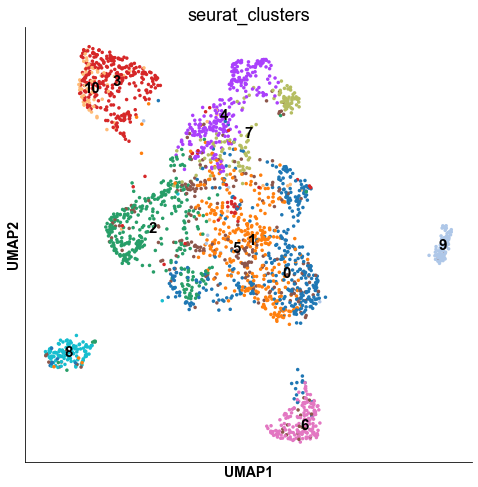

In [7]:
sc.pl.umap(atac_adata, color=['seurat_clusters'], legend_loc='on data')

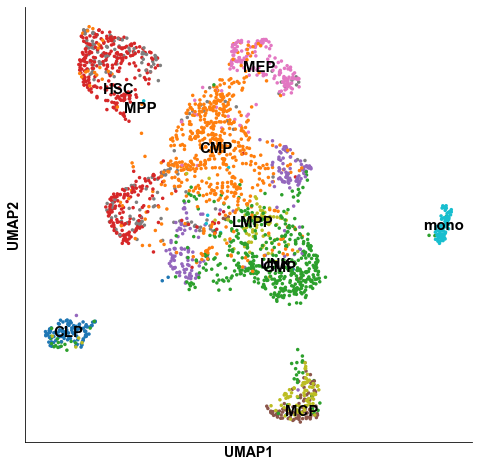

In [8]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
sc.pl.umap(atac_adata, color=['assign.celltype'], legend_loc='on data', title='', ax=ax)
fig.savefig(fname='Figures/S_HSC_ATAC_annotation.pdf', format='pdf')

In [20]:
script_table_cell_tf = utils.read_pickle('example/small_HSC/small_HSC_SCRIPT_20210811/enrichment/dataset_raw_score_df.pk')

In [21]:
index_ovlp = set(metadata.index).intersection(script_table_cell_tf.columns)

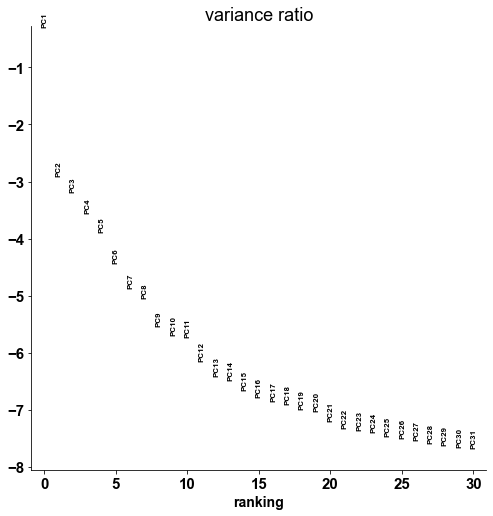

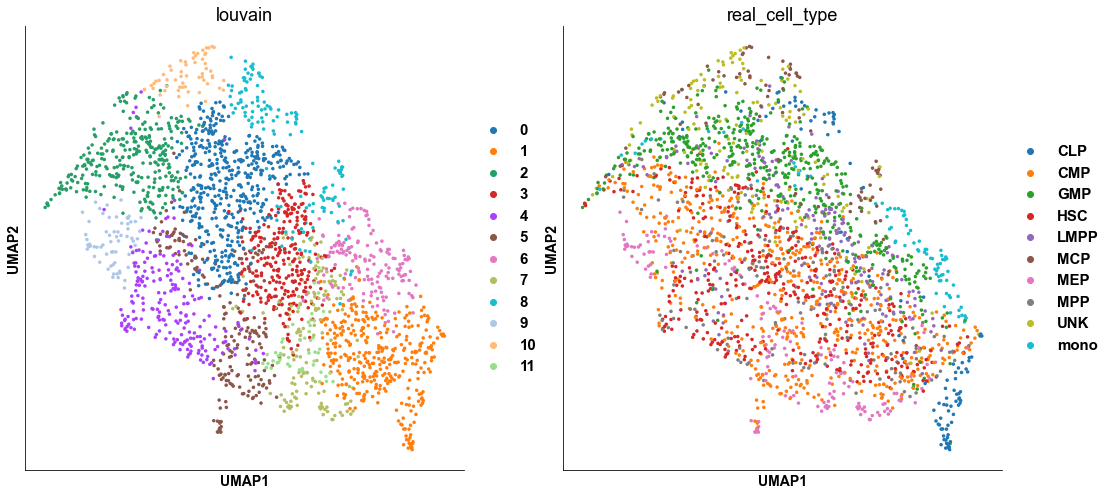

0.24676506168789314
0.23943492580176481


In [22]:
test = umap_table(script_table_cell_tf.T.loc[index_ovlp,:], metadata.loc[index_ovlp,:])

In [190]:
script_table.loc['singles-BM0828-MEP-160420-22',:].sort_values()

PRMT5    -0.739039
EBNA3    -0.692745
ZNF597   -0.661726
HMG20A   -0.654866
EBNA2    -0.630731
            ...   
RBP2      1.724087
DDX21     1.732321
BCL11A    1.939116
YAP1      2.132992
E2F1      2.299790
Name: singles-BM0828-MEP-160420-22, Length: 1610, dtype: float64

In [199]:
script_table['KMT2A'].sort_values()

singles-PB1022-mono-160128-45                -0.078955
singles-PB1022-mono-160128-9                 -0.077610
singles-160808-scATAC-BM1137-GMP2mid-LS-85   -0.074546
singles-BM0828-MPP-frozen-151103-7           -0.071155
BM1077-LMPP-Frozen-160107-65                 -0.062770
                                                ...   
singles-PB1022-mono-160128-86                 2.873793
singles-PB1022-mono-160128-31                 3.233791
singles-BM0828-CLP-frozen-151103-95           3.550020
singles-PB1022-mono-160128-38                 3.633962
singles-BM0828-MEP-160420-13                  8.669417
Name: KMT2A, Length: 2481, dtype: float64

12373.750503829102

In [43]:
script_adata = sc.read_h5ad('example/small_HSC/small_HSC_SCRIPT_20210714/enrichment/SCRIPT_enrichment.h5ad')

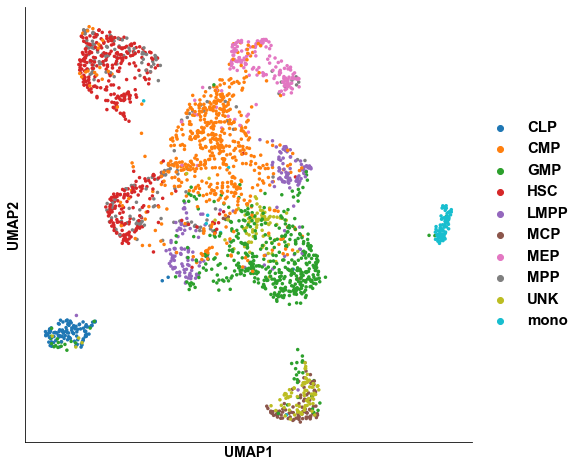

In [3]:
sc.pl.umap(script_adata, color=['assign.celltype'], title='')

In [ ]:
fg_dev

In [257]:
dev_table = map_factor_on_ChIP(tmp)

In [258]:
dev_table

singles-BM0828-CLP-frozen-151103-13  \
Factor                                         
ADNP                           2.347487e-199   
AEBP2                          3.565098e-192   
AFF1                           6.640840e-199   
AFF4                           8.233491e-199   
AGO1                           3.479056e-199   
...                                      ...   
ZSCAN5A                         2.625094e-46   
ZTA                             3.774271e-05   
ZXDB                           3.919136e-199   
ZXDC                           2.163556e-199   
ZZZ3                           1.308544e-100   

         singles-BM0828-LMPP-frozen-151105-40  \
Factor                                          
ADNP                            2.455744e-199   
AEBP2                           4.378796e-200   
AFF1                            1.230064e-198   
AFF4                            1.804532e-198   
AGO1                            4.800912e-199   
...                                       ...   
ZSCAN5A                          1.860826e-93   
ZTA                              1.473756e-11   
ZXDB                            7.188700e-199   
ZXDC                            7.417142e-200   
ZZZ3                            3.897620e-154   

         singles-BM0828-MPP-frozen-151103-43  \
Factor                                         
ADNP                           2.513920e-199   
AEBP2                          2.608073e-199   
AFF1                           6.285058e-199   
AFF4                           2.067663e-198   
AGO1                           8.041405e-163   
...                                      ...   
ZSCAN5A                         2.640889e-40   
ZTA                             2.019036e-07   
ZXDB                           7.786009e-199   
ZXDC                           3.008361e-199   
ZZZ3                            4.913669e-53   

         singles-BM0828-HSC-fresh-151027-37  \
Factor                                        
ADNP                          8.015026e-200   
AEBP2                         1.586413e-199   
AFF1                          8.012681e-199   
AFF4                          1.771556e-198   
AGO1                          3.042582e-199   
...                                     ...   
ZSCAN5A                        2.792585e-86   
ZTA                            6.858741e-06   
ZXDB                          6.159334e-199   
ZXDC                          3.615325e-200   
ZZZ3                          5.040451e-143   

         singles-BM0828-MPP-frozen-151103-60  singles-BM0828-GMP-151027-11  \
Factor                                                                       
ADNP                           2.440041e-199                 2.104542e-199   
AEBP2                          4.826251e-159                 1.353764e-199   
AFF1                           7.551659e-199                 5.160057e-199   
AFF4                           1.704559e-163                 8.361444e-199   
AGO1                           4.958636e-133                 1.182238e-199   
...                                      ...                           ...   
ZSCAN5A                         7.967262e-25                  2.949869e-68   
ZTA                             1.825188e-03                  8.298913e-15   
ZXDB                           8.459077e-199                 2.596734e-199   
ZXDC                           1.271976e-199                 5.479267e-200   
ZZZ3                            1.819296e-59                  2.429451e-98   

         singles-BM0828-MPP-frozen-151103-8  singles-MEP-141017-52  \
Factor                                                               
ADNP                          8.961252e-200          1.360760e-199   
AEBP2                         5.425226e-127          1.681488e-199   
AFF1                          3.121319e-199          9.880921e-199   
AFF4                          7.731732e-137          7.773853e-199   
AGO1                          7.876465e-132          1.029567e-199   
... 

In [182]:
dev_table.max(1).sort_values()[0:800].index

Index(['PRMT5', 'BRD7', 'UBE2I', 'ZNF35', 'ZKSCAN5', 'INTS12', 'FEZF1',
       'FOXG1', 'ZNF189', 'ZNF362',
       ...
       'FOXO3', 'PTTG1', 'ARID1A', 'ZNF207', 'SMARCE1', 'ZNF490', 'MTOR',
       'ZNF627', 'PRDM12', 'SMAD4'],
      dtype='object', name='Factor', length=800)

In [126]:
script_adata.obs = pd.concat([script_adata.obs.iloc[:,0:7], chromVAR_z_table.reindex(index=script_adata.obs.index)],axis=1)

In [116]:
script_adata.obs = pd.concat([script_adata.obs.iloc[:,0:7], script_res_table.reindex(index=script_adata.obs.index)],axis=1)

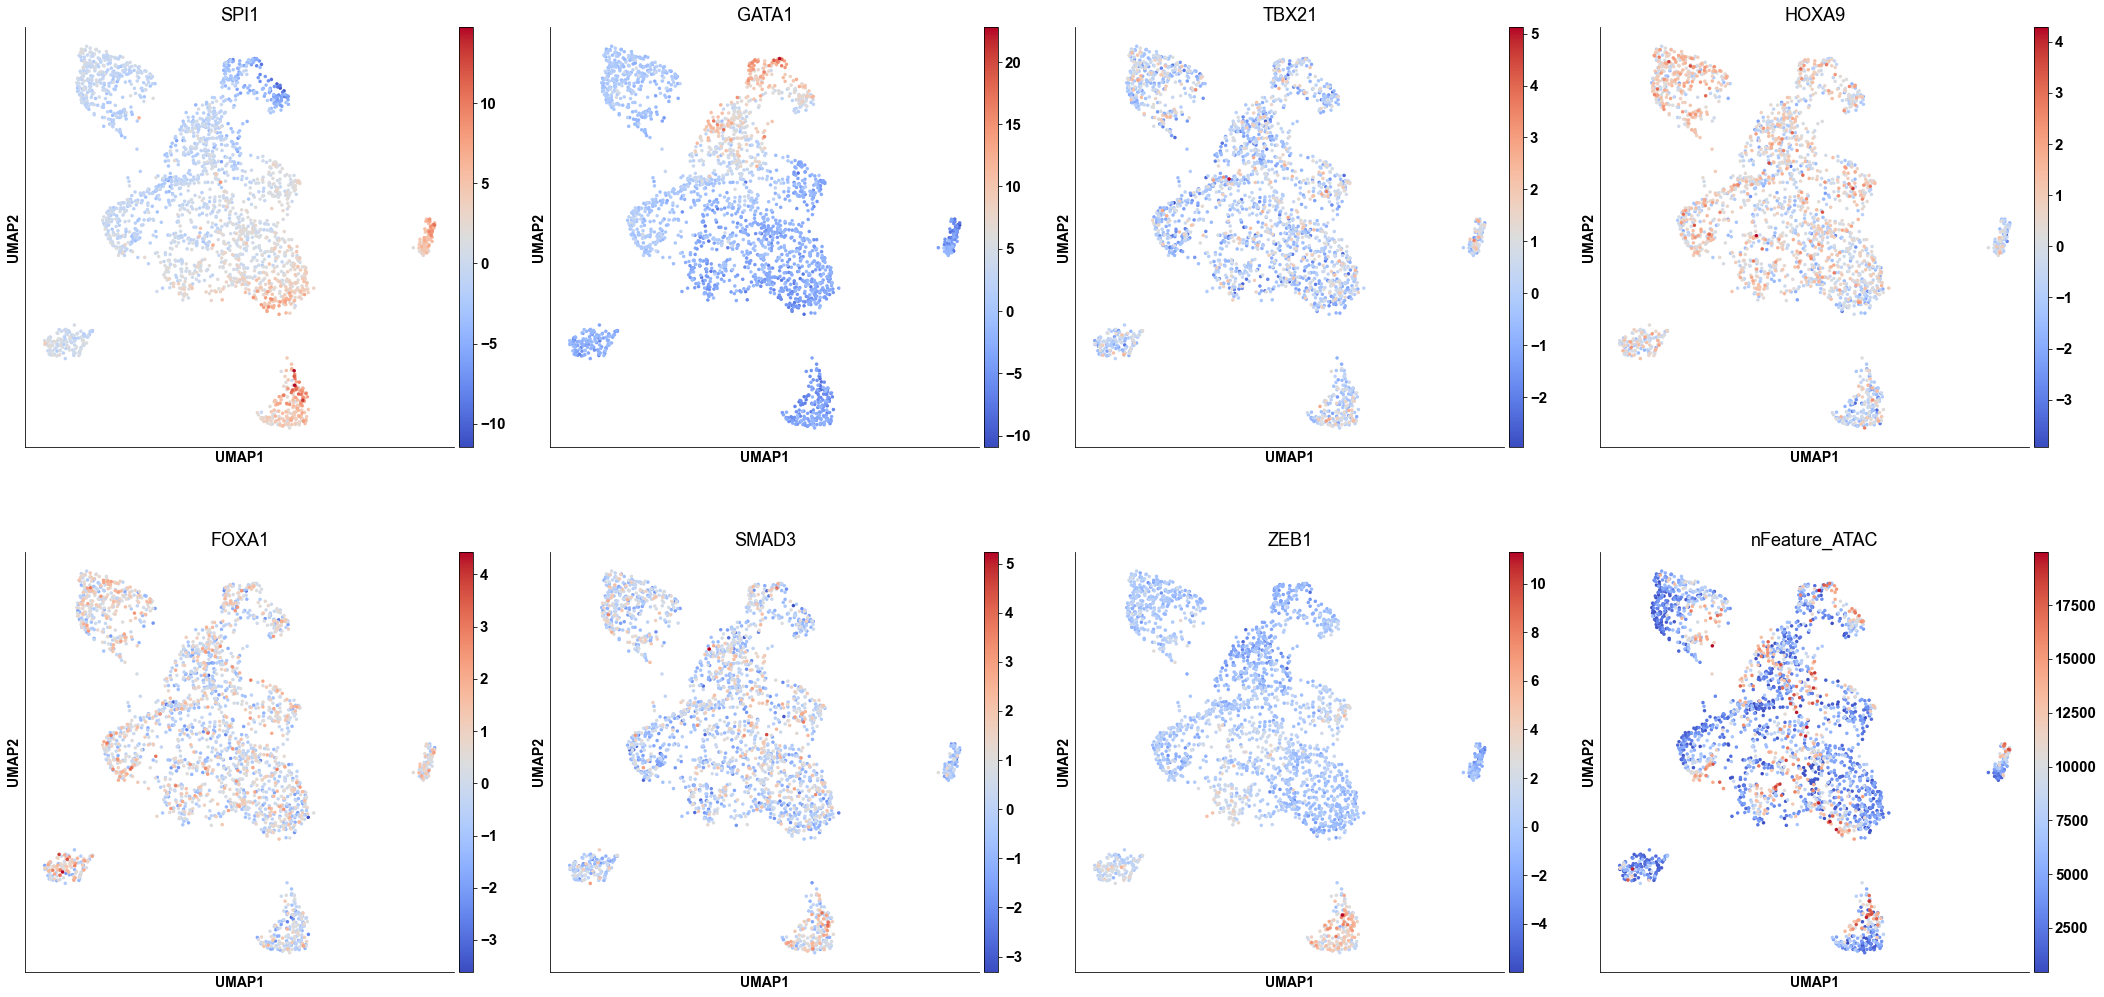

In [127]:
# chromvar
sc.pl.umap(script_adata, color=['SPI1','GATA1','TBX21', 'HOXA9','FOXA1','SMAD3','ZEB1','nFeature_ATAC'], color_map='coolwarm')

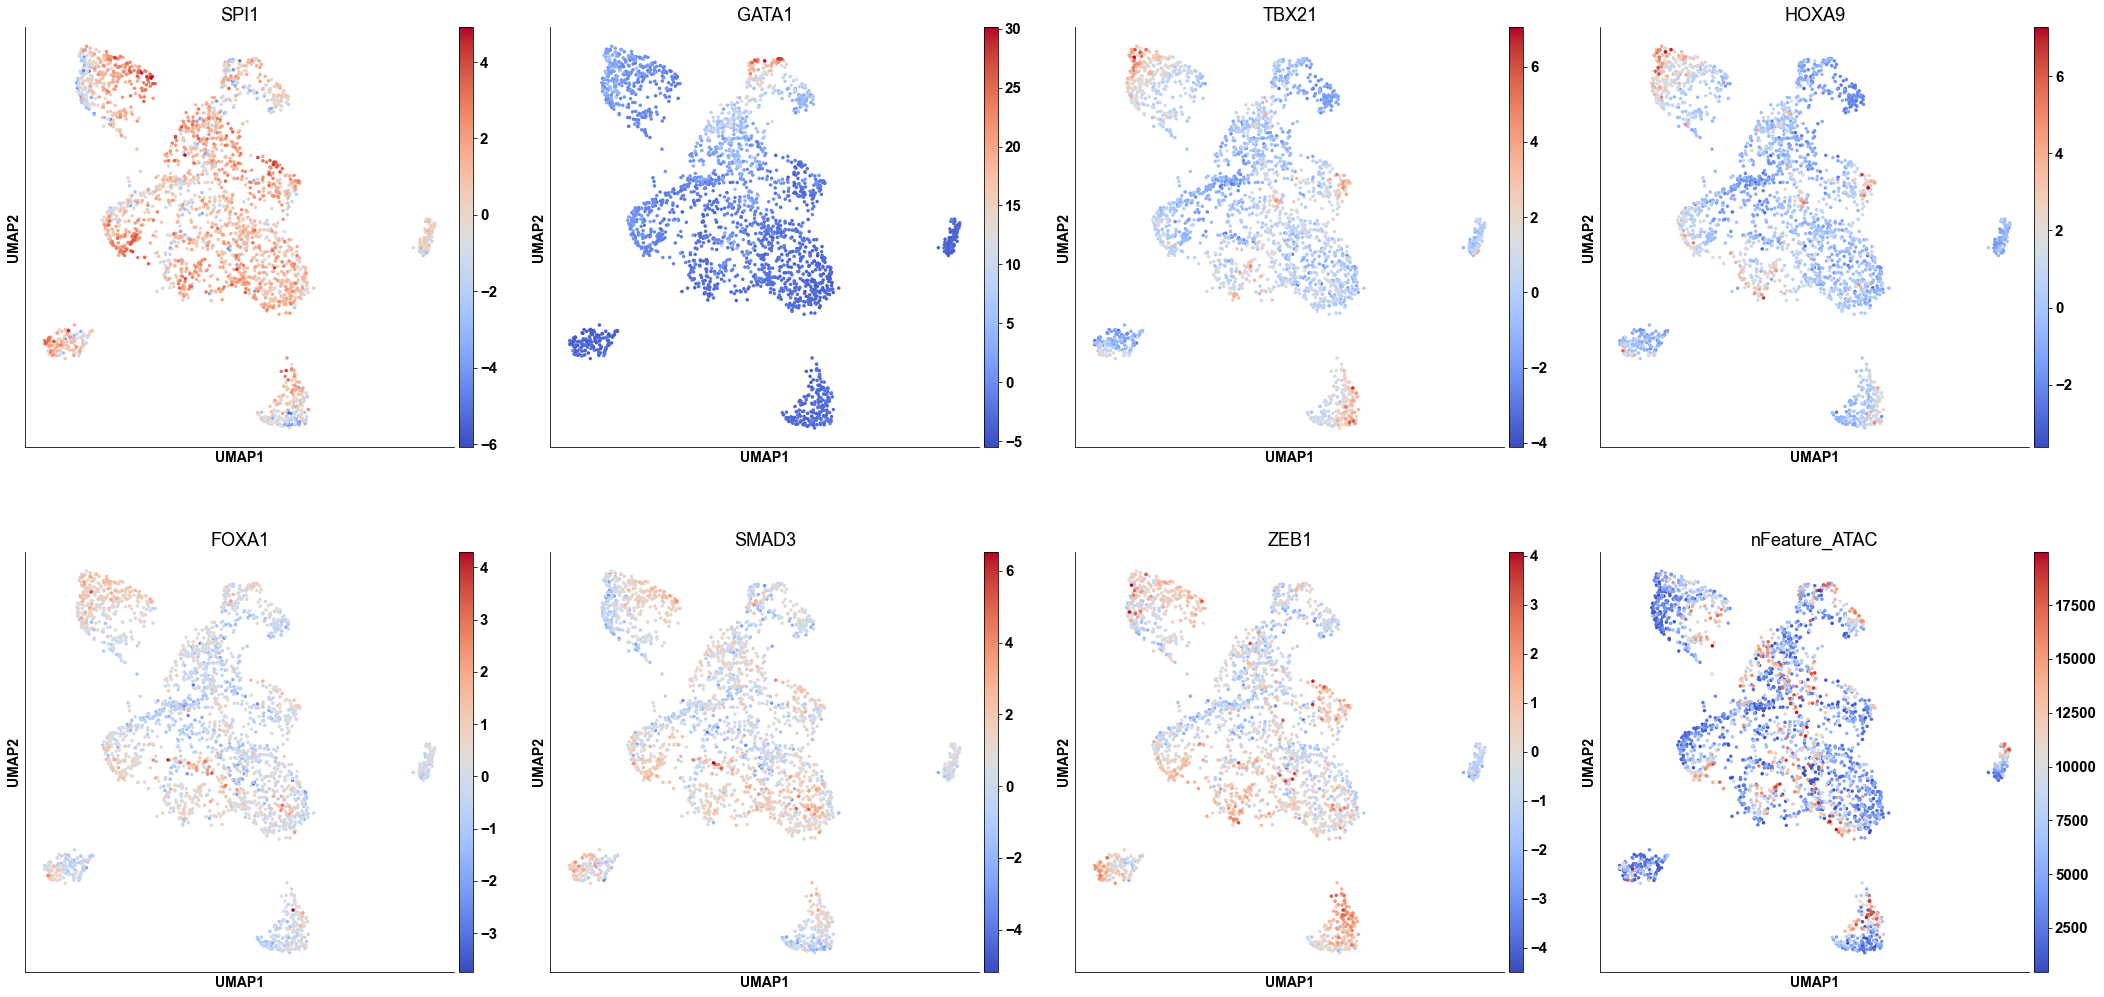

In [118]:
sc.pl.umap(script_adata, color=['SPI1','GATA1','TBX21', 'HOXA9','FOXA1','SMAD3','ZEB1','nFeature_ATAC'], color_map='coolwarm')

In [14]:
script_table_chip = script_adata.uns['ChIP'].copy()
script_table_motif = script_adata.uns['motif'].copy()
metadata = script_adata.obs.iloc[:,0:7]

In [37]:
script_table_chip.std(1)

singles-BM0106-HSC-LS-160219-87                   0.684861
BM1077-CMP-Frozen-160106-34                       1.323471
singles-BM0106-HSC-LS-160219-70                   0.722627
singles-20160726-scATAC-BM1137-GMP3high-HYC-34    1.100881
singles-20160726-scATAC-BM1137-GMP3high-HYC-46    0.939068
                                                    ...   
singles-BM0828-GMP-151027-33                      1.935009
singles-PB1022-mono-160128-62                     1.303468
BM1077-LMPP-Frozen-160107-13                      0.713084
singles-20160726-scATAC-BM1137-GMP3high-HYC-90    0.933617
singles-BM0106-UNK-160418-20                      1.272028
Length: 2429, dtype: float64

In [38]:
script_table_chip

ADNP     AEBP2      AFF1  \
singles-BM0106-HSC-LS-160219-87                -0.232031 -0.466992  0.025321   
BM1077-CMP-Frozen-160106-34                     1.327131 -0.637392 -0.028430   
singles-BM0106-HSC-LS-160219-70                 0.266780  0.247566 -0.063708   
singles-20160726-scATAC-BM1137-GMP3high-HYC-34 -1.250796  0.200571  0.747834   
singles-20160726-scATAC-BM1137-GMP3high-HYC-46 -1.356528  0.571309  1.987671   
...                                                  ...       ...       ...   
singles-BM0828-GMP-151027-33                   -0.583694 -1.469685 -1.885212   
singles-PB1022-mono-160128-62                  -0.557976  0.264243 -1.127247   
BM1077-LMPP-Frozen-160107-13                   -1.088596 -0.118667  1.125268   
singles-20160726-scATAC-BM1137-GMP3high-HYC-90 -0.787980  1.306906  0.496118   
singles-BM0106-UNK-160418-20                   -1.946554  0.064787  2.625239   

                                                    AFF4      AGO1      AGO2  \
singles-BM0106-HSC-LS-160219-87                -0.903506  0.502232  0.890608   
BM1077-CMP-Frozen-160106-34                    -1.546488  0.605011  0.116558   
singles-BM0106-HSC-LS-160219-70                -1.250006  0.173908 -0.015588   
singles-20160726-scATAC-BM1137-GMP3high-HYC-34  1.277134  0.816549  0.461621   
singles-20160726-scATAC-BM1137-GMP3high-HYC-46 -0.757839  1.070135 -0.219904   
...                                                  ...       ...       ...   
singles-BM0828-GMP-151027-33                   -2.012601  0.230321  1.625190   
singles-PB1022-mono-160128-62                   2.678411 -0.121845  0.229338   
BM1077-LMPP-Frozen-160107-13                   -0.444226  0.441212 -0.507818   
singles-20160726-scATAC-BM1137-GMP3high-HYC-90  0.804929  0.215213  0.314848   
singles-BM0106-UNK-160418-20                    0.314415  0.507287 -0.463620   

                                                     AHR      AHRR  APOBEC3B  \
singles-BM0106-HSC-LS-160219-87                 0.426013  0.113958 -0.067577   
BM1077-CMP-Frozen-160106-34                    -0.297228 -1.050757 -0.250053   
singles-BM0106-HSC-LS-160219-70                 0.232668  0.597113 -0.025350   
singles-20160726-scATAC-BM1137-GMP3high-HYC-34 -0.186698 -2.594488  0.476100   
singles-20160726-scATAC-BM1137-GMP3high-HYC-46 -0.109603  0.266303  0.742830   
...                                                  ...       ...       ...   
singles-BM0828-GMP-151027-33                   -0.302595  1.088182 -1.126931   
singles-PB1022-mono-160128-62                  -0.095303 -0.194379  0.013883   
BM1077-LMPP-Frozen-160107-13                    0.244163  0.638993  0.096408   
singles-20160726-scATAC-BM1137-GMP3high-HYC-90  0.184127  0.721723  0.330960   
singles-BM0106-UNK-160418-20                   -0.253768  0.119794  0.439316   

                                                      AR  ...    ZSCAN2  \
singles-BM0106-HSC-LS-160219-87                -0.184400  ... -0.187607   
BM1077-CMP-Frozen-160106-34                    -0.174061  ...  1.005129   
singles-BM0106-HSC-LS-160219-70                 0.370856  ... -0.632716   
singles-20160726-scATAC-BM1137-GMP3high-HYC-34  0.293097  ...  2.405103   
singles-20160726-scATAC-BM1137-GMP3high-HYC-46  0.179757  ... -0.741422   
...                                                  ...  ...       ...   
singles-BM0828-GMP-151027-33                    0.090613  ...  0.770648   
singles-PB1022-mono-160128-62                   0.643391  ...  0.714122   
BM1077-LMPP-Frozen-160107-13                    0.449386  ... -0.338220   
singles-20160726-scATAC-BM1137-GMP3high-HYC-90  0.168431  ... -0.076995   
singles-BM0106-UNK-160418-20                   -0.046359  ... -0.033881   

                                                 ZSCAN20   ZSCAN22   ZSCAN23  \
singles-BM0106-HSC-LS-160219-87                 0.645083 -0.261664  0.208512   
BM1077-CMP-Frozen-160106-34                     0.373887 -1.431009  0.001221   
singles-BM0106-HSC-LS-160219

In [31]:
script_table_motif.std(1).mean()

1.627476489764243

In [19]:
script_table_motif

AC023509.3  AC138696.1  \
singles-BM0106-HSC-LS-160219-87                   1.460988   -1.758327   
BM1077-CMP-Frozen-160106-34                      -9.863490   -6.978742   
singles-BM0106-HSC-LS-160219-70                   1.902357    5.979377   
singles-20160726-scATAC-BM1137-GMP3high-HYC-34    7.417206   -6.891880   
singles-20160726-scATAC-BM1137-GMP3high-HYC-46   -3.577728   -1.690076   
...                                                    ...         ...   
singles-BM0828-GMP-151027-33                    -11.819048   -7.416388   
singles-PB1022-mono-160128-62                    -3.485774   16.260999   
BM1077-LMPP-Frozen-160107-13                     -0.886074   11.410235   
singles-20160726-scATAC-BM1137-GMP3high-HYC-90   -9.914796    4.486133   
singles-BM0106-UNK-160418-20                    -12.027157    6.541560   

                                                     AHR      AIRE      ALX1  \
singles-BM0106-HSC-LS-160219-87                -0.010399  0.091650  0.072233   
BM1077-CMP-Frozen-160106-34                    -0.927189 -0.076980  0.276122   
singles-BM0106-HSC-LS-160219-70                 0.084613  0.925710  0.645207   
singles-20160726-scATAC-BM1137-GMP3high-HYC-34 -0.442708  1.082506  0.157974   
singles-20160726-scATAC-BM1137-GMP3high-HYC-46 -0.362397  0.022617  0.343911   
...                                                  ...       ...       ...   
singles-BM0828-GMP-151027-33                   -0.036983  0.041316  1.149533   
singles-PB1022-mono-160128-62                  -0.655244  0.550855  0.600798   
BM1077-LMPP-Frozen-160107-13                   -0.361413 -0.521740 -0.182776   
singles-20160726-scATAC-BM1137-GMP3high-HYC-90 -0.593439  0.449675  0.270360   
singles-BM0106-UNK-160418-20                   -0.091370 -0.238562 -0.673352   

                                                    ALX3      ALX4      ANHX  \
singles-BM0106-HSC-LS-160219-87                 0.367649  0.323453  0.096204   
BM1077-CMP-Frozen-160106-34                    -0.197751 -0.359910  0.616132   
singles-BM0106-HSC-LS-160219-70                 0.479629  0.513566 -0.041093   
singles-20160726-scATAC-BM1137-GMP3high-HYC-34  0.151933  0.189097  0.357022   
singles-20160726-scATAC-BM1137-GMP3high-HYC-46  0.108298  0.117395  0.138995   
...                                                  ...       ...       ...   
singles-BM0828-GMP-151027-33                    0.421239  0.488788  0.267492   
singles-PB1022-mono-160128-62                   0.689404  0.581914  0.422643   
BM1077-LMPP-Frozen-160107-13                   -0.155575 -0.132435 -0.081521   
singles-20160726-scATAC-BM1137-GMP3high-HYC-90  0.099493  0.115965  0.243621   
singles-BM0106-UNK-160418-20                   -0.419806 -0.534235 -0.031798   

                                                      AR     ARGFX  ...  \
singles-BM0106-HSC-LS-160219-87                -0.053440  0.219541  ...   
BM1077-CMP-Frozen-160106-34                     0.264880 -0.406101  ...   
singles-BM0106-HSC-LS-160219-70                -0.228081  0.427044  ...   
singles-20160726-scATAC-BM1137-GMP3high-HYC-34  0.214010  0.466066  ...   
singles-20160726-scATAC-BM1137-GMP3high-HYC-46 -0.223182  0.194552  ...   
...                                                  ...       ...  ...   
singles-BM0828-GMP-151027-33                   -0.032306  0.254061  ...   
singles-PB1022-mono-160128-62                  -0.597921  0.850252  ...   
BM1077-LMPP-Frozen-160107-13                    0.316560 -0.372279  ...   
singles-20160726-scATAC-BM1137-GMP3high-HYC-90 -0.355528  0.302650  ...   
singles-BM0106-UNK-160418-20                    0.594555 -0.532969  ...   

                                                  ZSCAN1   ZSCAN16   ZSCAN22  \
singles-BM0106-HSC-LS-160219-87                 1.886475  0.379338 -0.372009   
BM1077-CMP-Frozen-160106-34                    -0.743659 -0.081020 -2.544479   
singles-BM0106-HSC-LS-160219-70                -0.532849  0.440566 -0.509900   
singles-20160726

In [128]:
def umap_table(script_table_cell_tf, metadata):
    sudo_expression_SCRIPT = ad.AnnData(script_table_cell_tf)
#     sc.pp.highly_variable_genes(sudo_expression_SCRIPT)
    sc.tl.pca(sudo_expression_SCRIPT, svd_solver='arpack', use_highly_variable=False)
#     sc.pl.pca_variance_ratio(sudo_expression_SCRIPT, log=True)
    sc.pp.neighbors(sudo_expression_SCRIPT, n_neighbors=10, n_pcs=30)
    sc.tl.umap(sudo_expression_SCRIPT)
    sc.tl.louvain(sudo_expression_SCRIPT, resolution=0.6)
    sudo_expression_SCRIPT.obs['real_cell_type']=metadata['assign.celltype'][sudo_expression_SCRIPT.obs.index]
    sudo_expression_SCRIPT.obs['nFeature_ATAC']=metadata['nFeature_ATAC'][sudo_expression_SCRIPT.obs.index]
    sc.pl.umap(sudo_expression_SCRIPT, color=['louvain','real_cell_type'], color_map=regulation_cmp)
    print(sklearn.metrics.normalized_mutual_info_score(sudo_expression_SCRIPT.obs['louvain'], sudo_expression_SCRIPT.obs['real_cell_type']))
    print(sklearn.metrics.adjusted_mutual_info_score(sudo_expression_SCRIPT.obs['louvain'], sudo_expression_SCRIPT.obs['real_cell_type']))
    return sudo_expression_SCRIPT

In [9]:
script_res_table = pd.read_csv('example/small_HSC/small_HSC_SCRIPT_20210809/enrichment/SCRIPT_enrichment.txt', sep='\t', index_col=0)

In [10]:
script_res_table

AC023509.3  AC138696.1  \
singles-BM0106-HSC-LS-160219-87                   0.067950   -0.314760   
BM1077-CMP-Frozen-160106-34                      -1.291347   -0.238734   
singles-BM0106-HSC-LS-160219-70                  -0.068776   -0.072287   
singles-20160726-scATAC-BM1137-GMP3high-HYC-34    1.311456   -0.162459   
singles-20160726-scATAC-BM1137-GMP3high-HYC-46   -0.579993   -0.038282   
...                                                    ...         ...   
singles-BM0828-GMP-151027-33                     -0.274147    0.166462   
singles-PB1022-mono-160128-62                     0.216890    0.784059   
BM1077-LMPP-Frozen-160107-13                      0.589376    0.175407   
singles-20160726-scATAC-BM1137-GMP3high-HYC-90   -0.564373    0.149926   
singles-BM0106-UNK-160418-20                     -1.174297   -0.508396   

                                                    ADNP     AEBP2      AFF1  \
singles-BM0106-HSC-LS-160219-87                -0.818881 -0.187835  0.780231   
BM1077-CMP-Frozen-160106-34                     0.044331  0.720205 -1.734427   
singles-BM0106-HSC-LS-160219-70                 0.339812 -0.259731 -2.298738   
singles-20160726-scATAC-BM1137-GMP3high-HYC-34 -1.203100  0.066245 -0.313564   
singles-20160726-scATAC-BM1137-GMP3high-HYC-46 -1.672293  0.801086  2.865307   
...                                                  ...       ...       ...   
singles-BM0828-GMP-151027-33                   -0.454197 -1.457274 -2.222657   
singles-PB1022-mono-160128-62                  -0.652468  0.361359 -1.238128   
BM1077-LMPP-Frozen-160107-13                   -1.171490 -0.431868  0.732795   
singles-20160726-scATAC-BM1137-GMP3high-HYC-90 -0.677467  1.165865  0.225173   
singles-BM0106-UNK-160418-20                   -1.051792  0.520477  3.815921   

                                                    AFF4      AGO1      AGO2  \
singles-BM0106-HSC-LS-160219-87                -1.276841  0.843133  0.000055   
BM1077-CMP-Frozen-160106-34                     0.298271  1.100553  0.433477   
singles-BM0106-HSC-LS-160219-70                 0.909474 -0.087959  0.257647   
singles-20160726-scATAC-BM1137-GMP3high-HYC-34  2.842836  0.254735  0.236026   
singles-20160726-scATAC-BM1137-GMP3high-HYC-46  0.313509  2.085369  0.225054   
...                                                  ...       ...       ...   
singles-BM0828-GMP-151027-33                   -1.479248  0.416573  0.136740   
singles-PB1022-mono-160128-62                   1.512828 -0.110223  0.428359   
BM1077-LMPP-Frozen-160107-13                    0.892039  0.142305  0.197842   
singles-20160726-scATAC-BM1137-GMP3high-HYC-90  0.694363 -0.143562  0.009459   
singles-BM0106-UNK-160418-20                   -1.471598  1.905733 -0.215580   

                                                     AHR      AHRR  ...  \
singles-BM0106-HSC-LS-160219-87                 0.378042  0.316174  ...   
BM1077-CMP-Frozen-160106-34                    -0.104464  1.806062  ...   
singles-BM0106-HSC-LS-160219-70                 0.639701 -0.469618  ...   
singles-20160726-scATAC-BM1137-GMP3high-HYC-34 -0.268175 -1.692201  ...   
singles-20160726-scATAC-BM1137-GMP3high-HYC-46 -0.034724  1.711974  ...   
...                                                  ...       ...  ...   
singles-BM0828-GMP-151027-33                   -1.026729 -1.188457  ...   
singles-PB1022-mono-160128-62                  -0.194084 -0.383145  ...   
BM1077-LMPP-Frozen-160107-13                   -0.291635 -0.538025  ...   
singles-20160726-scATAC-BM1137-GMP3high-HYC-90 -0.173670  0.856909  ...   
singles-BM0106-UNK-160418-20                    0.064580  0.428361  ...   

                                                 ZSCAN30   ZSCAN31    ZSCAN4  \
singles-BM0106-HSC-LS-160219-87                -0.194921  0.237047 -0.113487   
BM1077-CMP-Frozen-160106-34                     0.184950  2.416380  0.219478   
singles-BM0106-HSC-LS-160219-70                -0.107823  1.006579  0.231870   
singles-20160726

In [11]:
umap_table(script_res_table.loc[metadata.index,:], metadata)

NameError: name 'metadata' is not defined

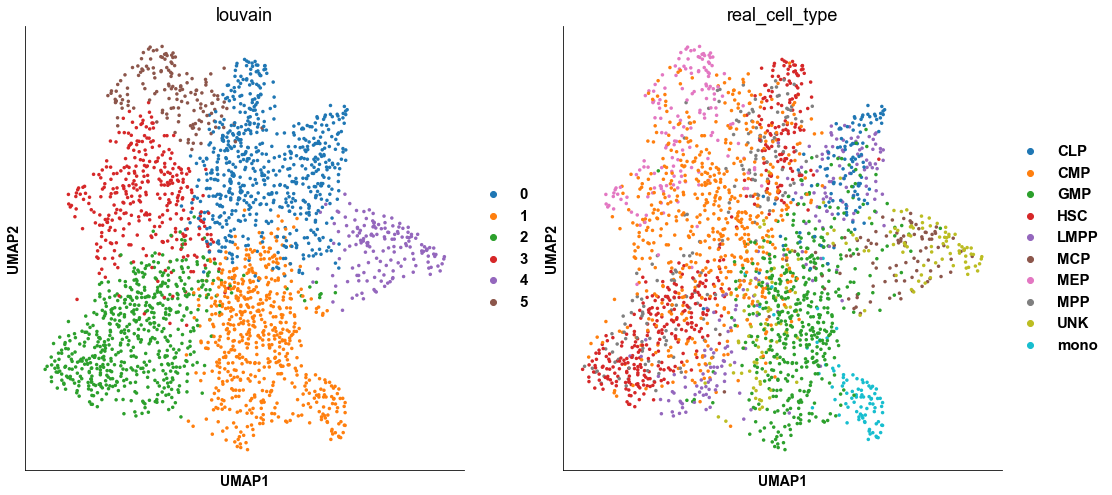

0.3751810539268534
0.3720312871773404


AnnData object with n_obs × n_vars = 2429 × 870
    obs: 'louvain', 'real_cell_type', 'nFeature_ATAC'
    uns: 'pca', 'neighbors', 'umap', 'louvain', 'louvain_colors', 'real_cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [130]:
umap_table(chromVAR_z_table.loc[metadata.index,:], metadata)

In [218]:
script_table.columns=[i[2:] for i in script_table.columns]

In [ ]:
script_table_chip

In [49]:
script_table_chip.to_csv('example/small_HSC/script_pseudotime/score.txt', sep='\t')

In [50]:
script_adata.obs.iloc[:, 0:7].reindex(index=script_table.index).to_csv('example/small_HSC/script_pseudotime/meta_data.txt', sep='\t')

In [95]:
pd.DataFrame(script_table_chip.columns).to_csv('example/small_HSC/script_pseudotime/feature.txt', sep='\t', header=None, index=None)

In [105]:
def l2_norm(X):
    X_norm = preprocessing.normalize(X, norm='l2')
    X_norm = pd.DataFrame(X_norm, index= X.index, columns=X.columns).copy()
    return X_norm

In [106]:
script_table_chip_norm = l2_norm(script_table_chip)

In [100]:
script_table_motif_norm

AC023509.3  AC138696.1  \
singles-BM0106-HSC-LS-160219-87                   0.034344   -0.041333   
BM1077-CMP-Frozen-160106-34                      -0.176353   -0.124776   
singles-BM0106-HSC-LS-160219-70                   0.046168    0.145112   
singles-20160726-scATAC-BM1137-GMP3high-HYC-34    0.095969   -0.089172   
singles-20160726-scATAC-BM1137-GMP3high-HYC-46   -0.087098   -0.041144   
...                                                    ...         ...   
singles-BM0828-GMP-151027-33                     -0.116804   -0.073294   
singles-PB1022-mono-160128-62                    -0.049917    0.232862   
BM1077-LMPP-Frozen-160107-13                     -0.022857    0.294337   
singles-20160726-scATAC-BM1137-GMP3high-HYC-90   -0.154756    0.070022   
singles-BM0106-UNK-160418-20                     -0.220668    0.120021   

                                                     AHR      AIRE      ALX1  \
singles-BM0106-HSC-LS-160219-87                -0.000244  0.002154  0.001698   
BM1077-CMP-Frozen-160106-34                    -0.016578 -0.001376  0.004937   
singles-BM0106-HSC-LS-160219-70                 0.002053  0.022466  0.015658   
singles-20160726-scATAC-BM1137-GMP3high-HYC-34 -0.005728  0.014006  0.002044   
singles-20160726-scATAC-BM1137-GMP3high-HYC-46 -0.008822  0.000551  0.008372   
...                                                  ...       ...       ...   
singles-BM0828-GMP-151027-33                   -0.000365  0.000408  0.011361   
singles-PB1022-mono-160128-62                  -0.009383  0.007888  0.008604   
BM1077-LMPP-Frozen-160107-13                   -0.009323 -0.013459 -0.004715   
singles-20160726-scATAC-BM1137-GMP3high-HYC-90 -0.009263  0.007019  0.004220   
singles-BM0106-UNK-160418-20                   -0.001676 -0.004377 -0.012354   

                                                    ALX3      ALX4      ANHX  \
singles-BM0106-HSC-LS-160219-87                 0.008642  0.007603  0.002261   
BM1077-CMP-Frozen-160106-34                    -0.003536 -0.006435  0.011016   
singles-BM0106-HSC-LS-160219-70                 0.011640  0.012464 -0.000997   
singles-20160726-scATAC-BM1137-GMP3high-HYC-34  0.001966  0.002447  0.004619   
singles-20160726-scATAC-BM1137-GMP3high-HYC-46  0.002636  0.002858  0.003384   
...                                                  ...       ...       ...   
singles-BM0828-GMP-151027-33                    0.004163  0.004831  0.002644   
singles-PB1022-mono-160128-62                   0.009872  0.008333  0.006052   
BM1077-LMPP-Frozen-160107-13                   -0.004013 -0.003416 -0.002103   
singles-20160726-scATAC-BM1137-GMP3high-HYC-90  0.001553  0.001810  0.003803   
singles-BM0106-UNK-160418-20                   -0.007702 -0.009802 -0.000583   

                                                      AR     ARGFX  ...  \
singles-BM0106-HSC-LS-160219-87                -0.001256  0.005161  ...   
BM1077-CMP-Frozen-160106-34                     0.004736 -0.007261  ...   
singles-BM0106-HSC-LS-160219-70                -0.005535  0.010364  ...   
singles-20160726-scATAC-BM1137-GMP3high-HYC-34  0.002769  0.006030  ...   
singles-20160726-scATAC-BM1137-GMP3high-HYC-46 -0.005433  0.004736  ...   
...                                                  ...       ...  ...   
singles-BM0828-GMP-151027-33                   -0.000319  0.002511  ...   
singles-PB1022-mono-160128-62                  -0.008562  0.012176  ...   
BM1077-LMPP-Frozen-160107-13                    0.008166 -0.009603  ...   
singles-20160726-scATAC-BM1137-GMP3high-HYC-90 -0.005549  0.004724  ...   
singles-BM0106-UNK-160418-20                    0.010909 -0.009779  ...   

                                                  ZSCAN1   ZSCAN16   ZSCAN22  \
singles-BM0106-HSC-LS-160219-87                 0.044346  0.008917 -0.008745   
BM1077-CMP-Frozen-160106-34                    -0.013296 -0.001449 -0.045494   
singles-BM0106-HSC-LS-160219-70                -0.012932  0.010692 -0.012375   
singles-20160726

In [ ]:
script_table[script_table.std().sort_values()[-1000:].index]

In [190]:
dev_table.loc[dev_table.max(1).sort_values()[200:700].index,:].T.copy()

Factor                                    EMSY      MCM3    ZNF654     NR4A1  \
singles-BM0828-CLP-frozen-151103-13   0.655676  0.545438 -0.019177  0.824396   
singles-BM0828-LMPP-frozen-151105-40 -0.467817 -0.721732 -0.290713 -0.327729   
singles-BM0828-MPP-frozen-151103-43   2.083866  2.083680  0.999436  1.204420   
singles-BM0828-HSC-fresh-151027-37   -0.721994 -0.841692 -0.231414 -0.207318   
singles-BM0828-MPP-frozen-151103-60   1.217697  1.467435  0.081060  0.330093   
...                                        ...       ...       ...       ...   
singles-160822-BM1137-CMP-LS-11      -0.323572 -0.329033  0.228938  0.108997   
singles-160818-BM1137-pDC-LS-70       1.140146  1.285137 -0.599918  0.306990   
singles-160822-BM1137-CMP-LS-58      -0.427599 -0.213418  0.611932  0.559075   
singles-160822-BM1137-CMP-LS-86      -1.021692 -1.084846 -0.745458 -0.702928   
singles-160822-BM1137-CMP-LS-95      -0.623317 -0.870171 -0.182430 -0.356079   

Factor                                  ZNF600      ADNP  CASP8AP2     CTBP2  \
singles-BM0828-CLP-frozen-151103-13   1.402933  0.623910  0.441208  1.370777   
singles-BM0828-LMPP-frozen-151105-40 -0.187552 -0.491811 -0.854382 -0.229149   
singles-BM0828-MPP-frozen-151103-43   0.761861  1.381988  2.045849  1.578126   
singles-BM0828-HSC-fresh-151027-37   -0.296917 -0.535325 -0.961113 -0.370383   
singles-BM0828-MPP-frozen-151103-60   0.277647  0.240146  1.467883  1.605204   
...                                        ...       ...       ...       ...   
singles-160822-BM1137-CMP-LS-11      -0.120861  0.236618 -0.615651 -0.082966   
singles-160818-BM1137-pDC-LS-70      -0.131997 -0.030310  1.458038  1.211274   
singles-160822-BM1137-CMP-LS-58       0.084291  0.362284 -0.627839  0.170691   
singles-160822-BM1137-CMP-LS-86      -0.769945 -0.777325 -1.278568 -0.827405   
singles-160822-BM1137-CMP-LS-95      -0.358777 -0.584563 -0.992521 -0.418014   

Factor                                   ASH1L      RBL2  ...    HOXA13  \
singles-BM0828-CLP-frozen-151103-13   1.123661  0.920482  ...  0.533108   
singles-BM0828-LMPP-frozen-151105-40 -0.617038 -0.461868  ... -0.028272   
singles-BM0828-MPP-frozen-151103-43   1.312255  2.251900  ...  2.101867   
singles-BM0828-HSC-fresh-151027-37   -0.804390 -0.610985  ... -0.241075   
singles-BM0828-MPP-frozen-151103-60   1.458098  1.553300  ...  0.664045   
...                                        ...       ...  ...       ...   
singles-160822-BM1137-CMP-LS-11      -0.617443 -0.335601  ...  0.273677   
singles-160818-BM1137-pDC-LS-70       0.605889  1.267585  ...  1.070596   
singles-160822-BM1137-CMP-LS-58      -0.454087 -0.228273  ... -0.664283   
singles-160822-BM1137-CMP-LS-86      -1.298738 -0.979399  ... -0.686286   
singles-160822-BM1137-CMP-LS-95      -0.905676 -0.632307  ... -0.003964   

Factor                                   SRCAP     PRPF4    ZNF333     GLYR1  \
singles-BM0828-CLP-frozen-151103-13   2.567212  0.997587  1.865203  0.353478   
singles-BM0828-LMPP-frozen-151105-40  0.731583 -0.059245  0.032591  0.044605   
singles-BM0828-MPP-frozen-151103-43   1.483305  2.377351  1.397809  1.533765   
singles-BM0828-HSC-fresh-151027-37    0.123679 -0.063544 -0.066216  1.202747   
singles-BM0828-MPP-frozen-151103-60  -0.166087  0.160504  0.701005  1.052700   
...                                        ...       ...       ...       ...   
singles-160822-BM1137-CMP-LS-11       0.262728  0.398105 -0.190332  1.268773   
singles-160818-BM1137-pDC-LS-70      -0.419851  0.470796 -0.878439  0.934350   
singles-160822-BM1137-CMP-LS-58       0.406307  0.628388 -0.494649  1.807274   
singles-160822-BM1137-CMP-LS-86      -0.445556 -0.596966 -0.684153 -0.499791   
singles-160822-BM1137-CMP-LS-95       0.306409 -0.118579 -0.371687  1.690239   

Factor                                   FOSL2    ZNF267      IRF1    ZNF438  \
singles-BM0828-CLP-frozen-151103-13   0.347483  1.306503  2.414568  1.043136   
singles-BM0828-LMPP-frozen-151105-40 -0.470748 -0.581094

In [204]:
from sklearn.cluster import KMeans
import numpy as np

In [249]:
tmp = dev_table[dev_table.max().sort_values()[0:-300].index]

In [250]:
kmeans_factor = KMeans(n_clusters=7, random_state=0).fit(tmp)
kmeans_cell = KMeans(n_clusters=7, random_state=0).fit(tmp.T)
# kmeans.labels_

In [251]:
factor_idx = []
cell_idx = []
for k in range(0,7):
    for i,j in enumerate(kmeans_factor.labels_):
        if j == k:
            factor_idx.append(i)
    for i,j in enumerate(kmeans_cell.labels_):
        if j == k:
            cell_idx.append(i)

In [ ]:
sns.heatmap(tmp.iloc[factor_idx,cell_idx], xticklabels=False,  yticklabels=False, cmap='RdBu_r')

In [ ]:
for i in tmp.iloc[factor_idx,cell_idx].index:
    print(i)

In [ ]:
for i in tmp.iloc[factor_idx,cell_idx].columns:
    print(i)

In [224]:
dev_table.max().sort_values()[0:-20].index

Index(['singles-160819-BM1137-CMP-LS-3',
       'singles-160808-scATAC-BM1137-GMP2mid-LS-91',
       'BM1077-LMPP-Frozen-160107-34', 'BM1077-LMPP-Frozen-160107-22',
       'singles-BM1214-MCP-frozen-160128-72',
       'singles-160808-scATAC-BM1137-GMP2mid-LS-34',
       'singles-160822-BM1137-CMP-LS-80',
       'singles-BM0828-HSC-frozen-151027-80', 'singles-BM0828-GMP-151027-37',
       'singles-20160726-scATAC-BM1137-GMP3high-HYC-10',
       ...
       'singles-20160726-scATAC-BM1214-CMP-LS-88',
       'singles-20160726-scATAC-BM1214-CMP-LS-2',
       'singles-BM0106-HSC-LS-160219-23',
       'singles-20160726-scATAC-BM1137-GMP3high-HYC-19',
       'singles-BM0828-CLP-frozen-151103-75', 'BM1077-CLP-Frozen-160106-93',
       'singles-BM0828-CMP-frozen-151118-68',
       'singles-BM0828-MPP-frozen-151103-81',
       'singles-BM0106-HSC-SIM-160219-84', 'BM1077-HSC-Frozen-160105-26'],
      dtype='object', length=2409)

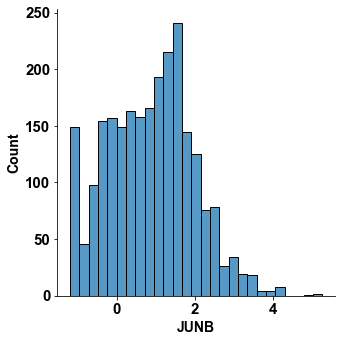

In [197]:
sns.displot(dev_table.loc['JUNB',:])

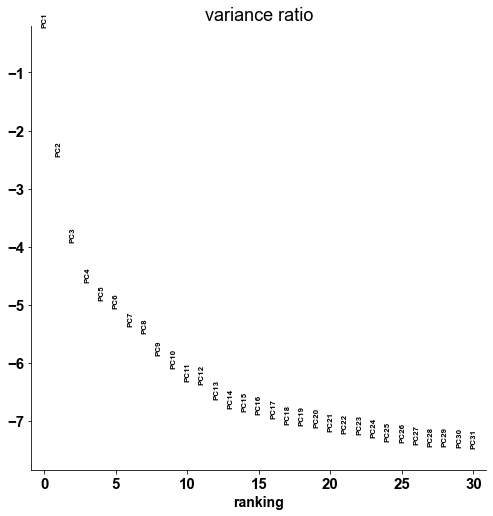

In [188]:
script_table_final = dev_table.loc[dev_table.max(1).sort_values()[200:700].index,:].T.copy()
# script_table.columns=[i[2:] for i in script_table.columns]
# script_table = script_table.dropna(axis=1,how='any')
sudo_expression_SCRIPT = ad.AnnData(script_table_final)
sc.tl.pca(sudo_expression_SCRIPT, svd_solver='arpack')
sc.pl.pca_variance_ratio(sudo_expression_SCRIPT, log=True)
sc.pp.neighbors(sudo_expression_SCRIPT, n_neighbors=10, n_pcs=30)
sc.tl.umap(sudo_expression_SCRIPT)
sc.tl.louvain(sudo_expression_SCRIPT, resolution=0.6)
sudo_expression_SCRIPT.obs['real_cell_type']=script_adata.obs['assign.celltype'][sudo_expression_SCRIPT.obs.index]

In [264]:
sudo_expression_SCRIPT.obs['nFeature_ATAC']=script_adata.obs['nFeature_ATAC'][sudo_expression_SCRIPT.obs.index]

In [263]:
sudo_expression_SCRIPT

AnnData object with n_obs × n_vars = 2429 × 500
    obs: 'louvain', 'real_cell_type'
    uns: 'pca', 'neighbors', 'umap', 'louvain', 'louvain_colors', 'real_cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [169]:
sklearn.metrics.normalized_mutual_info_score(sudo_expression_SCRIPT.obs['real_cell_type'], sudo_expression_SCRIPT.obs['louvain'])

0.09870513154670515

In [86]:
chromVAR_z_table = pd.read_csv('example/small_HSC/chromvar_result.txt', sep='\t').T

In [88]:
chromVAR_z_table = chromVAR_z_table.replace([np.inf, -np.inf], np.nan)
chromVAR_z_table = chromVAR_z_table.dropna(axis=1,how='any')


In [77]:
index = chromVAR_z_table.index.intersection(metadata.index)

In [78]:
chromVAR_z_table.loc[index,:]

TFAP2B    TFAP2D    TFAP2C    TFAP2E  \
singles-BM0828-HSC-fresh-151027-1 -0.397524 -0.356856 -1.198091  1.768464   
singles-BM0828-HSC-fresh-151027-2  0.005783  0.092021  0.343878  0.202474   
singles-BM0828-HSC-fresh-151027-3 -0.788596 -0.094158 -1.637094 -0.317446   
singles-BM0828-HSC-fresh-151027-4 -1.083218  0.514756 -0.088768  1.293349   
singles-BM0828-HSC-fresh-151027-5  1.825802  0.263169  0.063501 -0.473619   
...                                     ...       ...       ...       ...   
singles-160822-BM1137-CMP-LS-89    0.540739 -1.200121 -0.338266 -0.228694   
singles-160822-BM1137-CMP-LS-91   -1.789948 -0.672807 -0.176943 -0.452832   
singles-160822-BM1137-CMP-LS-93   -1.231017 -0.492168  1.596190  1.379803   
singles-160822-BM1137-CMP-LS-95   -1.567738  0.584399 -0.896831  0.129517   
singles-160822-BM1137-CMP-LS-96    0.349952  0.441165  0.464957  0.286090   

                                     TFAP2A    ARID3A    ARID5B    ARID3B  \
singles-BM0828-HSC-fresh-151027-1  0.549738 -0.131789 -1.021241  0.198676   
singles-BM0828-HSC-fresh-151027-2 -0.114103 -0.394163  2.448022  1.038386   
singles-BM0828-HSC-fresh-151027-3  0.353257  0.380817 -1.085997  0.560519   
singles-BM0828-HSC-fresh-151027-4 -1.957392 -0.317137  0.923945  0.352710   
singles-BM0828-HSC-fresh-151027-5  0.477793 -0.882429  0.160418 -0.821035   
...                                     ...       ...       ...       ...   
singles-160822-BM1137-CMP-LS-89    0.439106 -0.724822  0.385541  1.356676   
singles-160822-BM1137-CMP-LS-91    0.127937  0.864148 -0.580803  1.240973   
singles-160822-BM1137-CMP-LS-93    0.455565 -0.468383 -0.438888  1.195299   
singles-160822-BM1137-CMP-LS-95   -0.470598  0.314684 -0.068476 -0.080866   
singles-160822-BM1137-CMP-LS-96   -0.995118 -0.618338 -0.963932  1.631260   

                                     ARID5A    ARID3C  ...      PBX4  \
singles-BM0828-HSC-fresh-151027-1 -1.054696 -0.280523  ... -0.462366   
singles-BM0828-HSC-fresh-151027-2  0.564239  1.501889  ...  0.260553   
singles-BM0828-HSC-fresh-151027-3 -0.427868  2.432790  ...  0.355161   
singles-BM0828-HSC-fresh-151027-4 -0.387560  0.055230  ... -0.050831   
singles-BM0828-HSC-fresh-151027-5 -0.067370 -0.520962  ...  1.058334   
...                                     ...       ...  ...       ...   
singles-160822-BM1137-CMP-LS-89   -0.812840  2.257854  ... -0.706530   
singles-160822-BM1137-CMP-LS-91   -1.258783  0.501778  ... -0.399041   
singles-160822-BM1137-CMP-LS-93    0.820479 -0.176534  ...  0.749789   
singles-160822-BM1137-CMP-LS-95   -0.220993  0.054695  ...  2.479779   
singles-160822-BM1137-CMP-LS-96    0.158416  0.349802  ...  0.155179   

                                      NKX62     HOXA4  CR8477943      RORB  \
singles-BM0828-HSC-fresh-151027-1 -0.030013  0.279842  -1.244897  1.195926   
singles-BM0828-HSC-fresh-151027-2  0.471386 -0.898822   1.161562 -0.213231   
singles-BM0828-HSC-fresh-151027-3  0.087029 -0.379503   1.935259 -0.591783   
singles-BM0828-HSC-fresh-151027-4 -0.832453 -2.177104   0.080387 -1.243302   
singles-BM0828-HSC-fresh-151027-5 -1.432711 -0.314435   0.005417  2.351350   
...                                     ...       ...        ...       ...   
singles-160822-BM1137-CMP-LS-89    0.609693  0.249048   0.858527  0.217920   
singles-160822-BM1137-CMP-LS-91    0.394652  0.331203   0.791273 -0.523580   
singles-160822-BM1137-CMP-LS-93   -0.313771  0.243971  -0.260140 -0.802989   
singles-160822-BM1137-CMP-LS-95   -1.379239 -0.772590  -0.044960  1.496288   
singles-160822-BM1137-CMP-LS-96    0.484943 -0.537929   0.605753  0.274966   

                                      SMAD5     SMAD9      SOX6     TBX18  \
singles-BM0828-HSC-fresh-151027-1 -0.628652 -0.828333  0.327787  1.183752   
singles-BM0828-HSC-fresh-151027-2 -0.655992 -0.877532 -1.384739 -0.423629   
singles-BM0828-HSC-fresh-151027-3  0.713102 -0.802282 -0.559125 -0.521903   
singles-BM0828-HSC-fresh-151027-4  0.400979 -1.949369 -0.356809  0.124339   


In [79]:
chromVAR_z_table.loc[index,:].to_csv('example/small_HSC/chromvar_pseudotime/score.txt', sep='\t')

In [80]:
metadata.loc[index,:].to_csv('example/small_HSC/chromvar_pseudotime/meta_data.txt', sep='\t')

In [81]:
pd.DataFrame(chromVAR_z_table.columns).to_csv('example/small_HSC/chromvar_pseudotime/feature.txt', sep='\t', header=None, index=None)

In [69]:
chromVAR_z_table

TFAP2B    TFAP2D    TFAP2C    TFAP2E  \
singles-BM0828-HSC-fresh-151027-1 -0.397524 -0.356856 -1.198091  1.768464   
singles-BM0828-HSC-fresh-151027-2  0.005783  0.092021  0.343878  0.202474   
singles-BM0828-HSC-fresh-151027-3 -0.788596 -0.094158 -1.637094 -0.317446   
singles-BM0828-HSC-fresh-151027-4 -1.083218  0.514756 -0.088768  1.293349   
singles-BM0828-HSC-fresh-151027-5  1.825802  0.263169  0.063501 -0.473619   
...                                     ...       ...       ...       ...   
singles-160822-BM1137-CMP-LS-92   -1.613672  0.712106 -1.475680 -0.683629   
singles-160822-BM1137-CMP-LS-93   -1.231017 -0.492168  1.596190  1.379803   
singles-160822-BM1137-CMP-LS-94   -1.712968  0.524516 -0.354391  0.566493   
singles-160822-BM1137-CMP-LS-95   -1.567738  0.584399 -0.896831  0.129517   
singles-160822-BM1137-CMP-LS-96    0.349952  0.441165  0.464957  0.286090   

                                     TFAP2A    ARID3A    ARID5B    ARID3B  \
singles-BM0828-HSC-fresh-151027-1  0.549738 -0.131789 -1.021241  0.198676   
singles-BM0828-HSC-fresh-151027-2 -0.114103 -0.394163  2.448022  1.038386   
singles-BM0828-HSC-fresh-151027-3  0.353257  0.380817 -1.085997  0.560519   
singles-BM0828-HSC-fresh-151027-4 -1.957392 -0.317137  0.923945  0.352710   
singles-BM0828-HSC-fresh-151027-5  0.477793 -0.882429  0.160418 -0.821035   
...                                     ...       ...       ...       ...   
singles-160822-BM1137-CMP-LS-92   -1.495369 -1.414246  0.360038  0.015414   
singles-160822-BM1137-CMP-LS-93    0.455565 -0.468383 -0.438888  1.195299   
singles-160822-BM1137-CMP-LS-94    0.568552  1.199643 -0.402207 -0.367834   
singles-160822-BM1137-CMP-LS-95   -0.470598  0.314684 -0.068476 -0.080866   
singles-160822-BM1137-CMP-LS-96   -0.995118 -0.618338 -0.963932  1.631260   

                                     ARID5A    ARID3C  ...      PBX4  \
singles-BM0828-HSC-fresh-151027-1 -1.054696 -0.280523  ... -0.462366   
singles-BM0828-HSC-fresh-151027-2  0.564239  1.501889  ...  0.260553   
singles-BM0828-HSC-fresh-151027-3 -0.427868  2.432790  ...  0.355161   
singles-BM0828-HSC-fresh-151027-4 -0.387560  0.055230  ... -0.050831   
singles-BM0828-HSC-fresh-151027-5 -0.067370 -0.520962  ...  1.058334   
...                                     ...       ...  ...       ...   
singles-160822-BM1137-CMP-LS-92   -0.015007  0.098830  ...  0.551473   
singles-160822-BM1137-CMP-LS-93    0.820479 -0.176534  ...  0.749789   
singles-160822-BM1137-CMP-LS-94   -0.957813 -1.585310  ... -1.979014   
singles-160822-BM1137-CMP-LS-95   -0.220993  0.054695  ...  2.479779   
singles-160822-BM1137-CMP-LS-96    0.158416  0.349802  ...  0.155179   

                                      NKX62     HOXA4  CR8477943      RORB  \
singles-BM0828-HSC-fresh-151027-1 -0.030013  0.279842  -1.244897  1.195926   
singles-BM0828-HSC-fresh-151027-2  0.471386 -0.898822   1.161562 -0.213231   
singles-BM0828-HSC-fresh-151027-3  0.087029 -0.379503   1.935259 -0.591783   
singles-BM0828-HSC-fresh-151027-4 -0.832453 -2.177104   0.080387 -1.243302   
singles-BM0828-HSC-fresh-151027-5 -1.432711 -0.314435   0.005417  2.351350   
...                                     ...       ...        ...       ...   
singles-160822-BM1137-CMP-LS-92   -1.285436 -0.359380   0.340556 -0.919265   
singles-160822-BM1137-CMP-LS-93   -0.313771  0.243971  -0.260140 -0.802989   
singles-160822-BM1137-CMP-LS-94   -0.610608 -0.891657   1.884924 -1.088631   
singles-160822-BM1137-CMP-LS-95   -1.379239 -0.772590  -0.044960  1.496288   
singles-160822-BM1137-CMP-LS-96    0.484943 -0.537929   0.605753  0.274966   

                                      SMAD5     SMAD9      SOX6     TBX18  \
singles-BM0828-HSC-fresh-151027-1 -0.628652 -0.828333  0.327787  1.183752   
singles-BM0828-HSC-fresh-151027-2 -0.655992 -0.877532 -1.384739 -0.423629   
singles-BM0828-HSC-fresh-151027-3  0.713102 -0.802282 -0.559125 -0.521903   
singles-BM0828-HSC-fresh-151027-4  0.400979 -1.949369 -0.356809  0.124339   


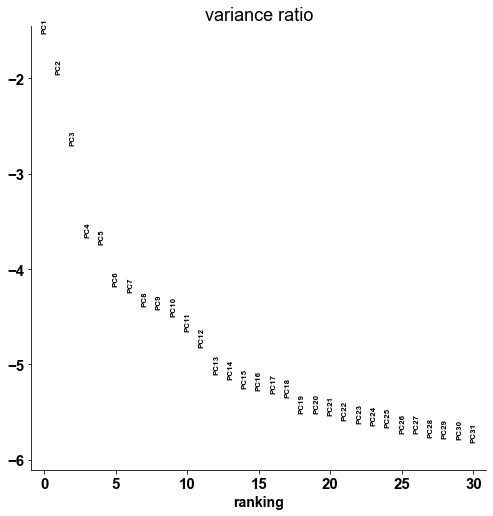

In [101]:
sudo_expression_chromvar= ad.AnnData(chromVAR_table.T)
sc.tl.pca(sudo_expression_chromvar, svd_solver='arpack')
sc.pl.pca_variance_ratio(sudo_expression_chromvar, log=True)
sc.pp.neighbors(sudo_expression_chromvar, n_neighbors=10, n_pcs=30)
sc.tl.umap(sudo_expression_chromvar)
sc.tl.louvain(sudo_expression_chromvar, resolution=0.6)
sudo_expression_chromvar.obs['real_cell_type']=atac_adata.obs['assign.celltype'][sudo_expression_SCRIPT.obs.index]

... storing 'real_cell_type' as categorical


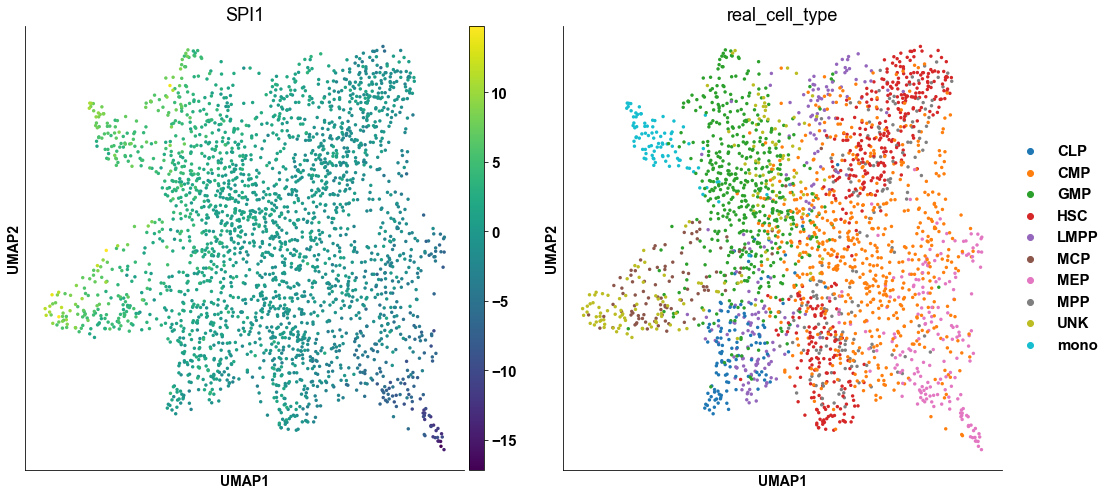

In [212]:
sc.pl.umap(sudo_expression_chromvar, color=['SPI1','real_cell_type'])

In [176]:
sudo_expression_chromvar.obs['real_cell_type'] = [i.split('-')[0] for i in index_list]

In [ ]:
sudo_expression_chromvar.obs

In [210]:
sklearn.metrics.normalized_mutual_info_score(atac_adata.obs['seurat_clusters'], atac_adata.obs['assign.celltype'])

0.4406487678538429

In [201]:
sklearn.metrics.normalized_mutual_info_score(sudo_expression_SCRIPT.obs['louvain'], sudo_expression_SCRIPT.obs['real_cell_type'])

0.22220002921224424

In [202]:
sklearn.metrics.normalized_mutual_info_score(sudo_expression_chromvar.obs['louvain'], sudo_expression_chromvar.obs['real_cell_type'])

0.44462259902750206

In [296]:
bg_dataset_odds_ratio_df_ChIP = utils.read_pickle('example/small_HSC/small_HSC_SCRIPT_20210606/enrichment/bg_files/bg_dataset_odds_ratio_df_ChIP.pk')

In [66]:
fg_dataset_deviation_df_motif = utils.read_pickle('example/small_HSC/small_HSC_SCRIPT_20210606/enrichment/fg_files/fg_dataset_deviation_df_motif.pk')

In [85]:
tmp = utils.read_pickle('example/small_HSC/small_HSC_SCRIPT_20210606/enrichment/fg_files/fg_dataset_deviation_df_ChIP.pk')

In [79]:
bc = [i for i in tmp.index if i.endswith('KMT2A')]

In [87]:
tmp.loc[bc,'singles-BM0828-MEP-160420-1'].sort_values()

id
73847_KMT2A      0.320062
34962_KMT2A      0.468201
73708_KMT2A      1.379662
73707_KMT2A      1.791905
73716_KMT2A      3.328281
77486_KMT2A      4.144228
73715_KMT2A    146.285509
Name: singles-BM0828-MEP-160420-1, dtype: float64

In [572]:
tmp = {}
for i in rna_adata.obs['assign.ident'].cat.categories:
    locals()['%s_bc' % i] = rna_adata.obs['assign.ident'][rna_adata.obs['assign.ident'] == i].index.tolist()
    locals()['%s_expr' % i] = pbmc_expr.loc[locals()['%s_bc' % i],:].mean()
    tmp[i] = locals()['%s_expr' % i]

celltype_expr = pd.DataFrame(tmp)

In [576]:
celltype_expr.to_csv('example/PBMC/cluster_expr.txt', sep='\t')

# Plot

In [122]:
chromVAR_z_table = pd.read_csv('example/small_HSC/chromvar_result.txt', sep='\t').T

In [ ]:
expression = pd.read_csv('example/PBMC/cluster_expr.txt', sep='\t', index_col=0)
# expression = np.log(expression + 0.00001)

chromVAR_z_table = pd.read_csv('example/PBMC/chromVAR_ztable.txt', sep='\t').T

# pbmc_script_adata = ad.read_h5ad('example/PBMC/multiome_pbmc_SCRIPT/enrichment/SCRIPT_enrichment.h5ad')

script_table = pbmc_script_adata.uns['integrated_z']

metadata = atac_adata.obs

In [123]:
chromVAR_z_table

TFAP2B    TFAP2D    TFAP2C    TFAP2E  \
singles-BM0828-HSC-fresh-151027-1 -0.397524 -0.356856 -1.198091  1.768464   
singles-BM0828-HSC-fresh-151027-2  0.005783  0.092021  0.343878  0.202474   
singles-BM0828-HSC-fresh-151027-3 -0.788596 -0.094158 -1.637094 -0.317446   
singles-BM0828-HSC-fresh-151027-4 -1.083218  0.514756 -0.088768  1.293349   
singles-BM0828-HSC-fresh-151027-5  1.825802  0.263169  0.063501 -0.473619   
...                                     ...       ...       ...       ...   
singles-160822-BM1137-CMP-LS-92   -1.613672  0.712106 -1.475680 -0.683629   
singles-160822-BM1137-CMP-LS-93   -1.231017 -0.492168  1.596190  1.379803   
singles-160822-BM1137-CMP-LS-94   -1.712968  0.524516 -0.354391  0.566493   
singles-160822-BM1137-CMP-LS-95   -1.567738  0.584399 -0.896831  0.129517   
singles-160822-BM1137-CMP-LS-96    0.349952  0.441165  0.464957  0.286090   

                                     TFAP2A    ARID3A    ARID5B    ARID3B  \
singles-BM0828-HSC-fresh-151027-1  0.549738 -0.131789 -1.021241  0.198676   
singles-BM0828-HSC-fresh-151027-2 -0.114103 -0.394163  2.448022  1.038386   
singles-BM0828-HSC-fresh-151027-3  0.353257  0.380817 -1.085997  0.560519   
singles-BM0828-HSC-fresh-151027-4 -1.957392 -0.317137  0.923945  0.352710   
singles-BM0828-HSC-fresh-151027-5  0.477793 -0.882429  0.160418 -0.821035   
...                                     ...       ...       ...       ...   
singles-160822-BM1137-CMP-LS-92   -1.495369 -1.414246  0.360038  0.015414   
singles-160822-BM1137-CMP-LS-93    0.455565 -0.468383 -0.438888  1.195299   
singles-160822-BM1137-CMP-LS-94    0.568552  1.199643 -0.402207 -0.367834   
singles-160822-BM1137-CMP-LS-95   -0.470598  0.314684 -0.068476 -0.080866   
singles-160822-BM1137-CMP-LS-96   -0.995118 -0.618338 -0.963932  1.631260   

                                     ARID5A    ARID3C  ...      PBX4  \
singles-BM0828-HSC-fresh-151027-1 -1.054696 -0.280523  ... -0.462366   
singles-BM0828-HSC-fresh-151027-2  0.564239  1.501889  ...  0.260553   
singles-BM0828-HSC-fresh-151027-3 -0.427868  2.432790  ...  0.355161   
singles-BM0828-HSC-fresh-151027-4 -0.387560  0.055230  ... -0.050831   
singles-BM0828-HSC-fresh-151027-5 -0.067370 -0.520962  ...  1.058334   
...                                     ...       ...  ...       ...   
singles-160822-BM1137-CMP-LS-92   -0.015007  0.098830  ...  0.551473   
singles-160822-BM1137-CMP-LS-93    0.820479 -0.176534  ...  0.749789   
singles-160822-BM1137-CMP-LS-94   -0.957813 -1.585310  ... -1.979014   
singles-160822-BM1137-CMP-LS-95   -0.220993  0.054695  ...  2.479779   
singles-160822-BM1137-CMP-LS-96    0.158416  0.349802  ...  0.155179   

                                      NKX62     HOXA4  CR8477943      RORB  \
singles-BM0828-HSC-fresh-151027-1 -0.030013  0.279842  -1.244897  1.195926   
singles-BM0828-HSC-fresh-151027-2  0.471386 -0.898822   1.161562 -0.213231   
singles-BM0828-HSC-fresh-151027-3  0.087029 -0.379503   1.935259 -0.591783   
singles-BM0828-HSC-fresh-151027-4 -0.832453 -2.177104   0.080387 -1.243302   
singles-BM0828-HSC-fresh-151027-5 -1.432711 -0.314435   0.005417  2.351350   
...                                     ...       ...        ...       ...   
singles-160822-BM1137-CMP-LS-92   -1.285436 -0.359380   0.340556 -0.919265   
singles-160822-BM1137-CMP-LS-93   -0.313771  0.243971  -0.260140 -0.802989   
singles-160822-BM1137-CMP-LS-94   -0.610608 -0.891657   1.884924 -1.088631   
singles-160822-BM1137-CMP-LS-95   -1.379239 -0.772590  -0.044960  1.496288   
singles-160822-BM1137-CMP-LS-96    0.484943 -0.537929   0.605753  0.274966   

                                      SMAD5     SMAD9      SOX6     TBX18  \
singles-BM0828-HSC-fresh-151027-1 -0.628652 -0.828333  0.327787  1.183752   
singles-BM0828-HSC-fresh-151027-2 -0.655992 -0.877532 -1.384739 -0.423629   
singles-BM0828-HSC-fresh-151027-3  0.713102 -0.802282 -0.559125 -0.521903   
singles-BM0828-HSC-fresh-151027-4  0.400979 -1.949369 -0.356809  0.124339   


In [ ]:
atac_adata

### SCRIPT chromVAR Expression

In [ ]:
chromVAR_dict = {}
SCRIPT_dict = {}
for i in expression.columns:
    locals()[i+'_cells'] = metadata[(metadata['assign.celltype'] == i)].index
    locals()[i] = chromVAR_table.loc[locals()[i+'_cells'],].mean()
    chromVAR_dict[i] = locals()[i]
    locals()[i] = script_table.loc[locals()[i+'_cells'],].mean()
    SCRIPT_dict[i] = locals()[i]

In [ ]:
SCRIPT_table = pd.DataFrame(SCRIPT_dict)
chromVAR_table = pd.DataFrame(chromVAR_dict)

In [ ]:
SCRIPT_table.index = [i[2:] for i in SCRIPT_table.index]

In [ ]:
SCRIPT_table = SCRIPT_table.drop(['CPEB1','ZNF354C'])

In [ ]:
sc_ovlp_factor = list(set(SCRIPT_table.index.to_list())  & set(expression.index.to_list()))
ch_ovlp_factor = list(set(chromVAR_table.index.to_list())  & set(expression.index.to_list()))

In [ ]:
ovlp_factor = list(set(SCRIPT_table.index.to_list())  & set(expression.index.to_list()) & set(chromVAR_table.index.to_list()))

In [ ]:
ovlp_factor

In [ ]:
for i in expression.columns:
    expression_sub = expression.loc[ovlp_factor, i]
    chromVAR_sub = chromVAR_table.loc[ovlp_factor, i]
    SCRIPT_sub = SCRIPT_table.loc[ovlp_factor, i]
    locals()[i+'_table'] = pd.DataFrame({'expression':expression_sub, 'chromVAR':chromVAR_sub, 'SCRIPT':SCRIPT_sub})

In [ ]:
MonoMac_table

In [ ]:
MonoMac_table[MonoMac_table['SCRIPT'] > 4]

In [ ]:
expression.columns

In [ ]:
cell = 'TProliferation'
data = locals()[cell + "_table"]
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.scatterplot(data=data, x='chromVAR', y='SCRIPT', hue='expression', palette='RdBu_r', ax=ax, legend=False)
ax.set_title('%s Cell' % cell)
texts = []
for i in range(len(data.index)):
    if abs(data.iloc[i,1]) > 1:
        texts.append(plt.text(data.iloc[i,1], data.iloc[i,2], data.index[i], size=8))
    if abs(data.iloc[i,2]) > 1.3:
        texts.append(plt.text(data.iloc[i,1], data.iloc[i,2], data.index[i], size=8))
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='green'))
fig.show()

### Recall ratio

In [ ]:
with open('TF_names_v_1.01.txt', 'r') as file_handle:    
    TF_list = [i.rstrip('\n') for i in file_handle.readlines()]

In [ ]:
tf_ovlp_factor = list(set(TF_list) & set(expression.index))

In [ ]:
script_motif_table = pbmc_script_adata.uns['motif_z'].copy()

script_ChIP_table = pbmc_script_adata.uns['ChIP_z'].copy()

script_table = pbmc_script_adata.uns['integrated_z'].copy()
script_table.columns=[i[2:] for i in script_table.columns]
# script_table = script_table.drop(['CPEB1', 'ZNF354C'], axis=1)

In [ ]:
ovlp_factor = set(expression.index) & set(script_table.columns) & set(chromVAR_table.columns) & set(script_ChIP_table.columns) & set(script_motif_table.columns)

In [ ]:
ch_ovlp_factor = set(expression.index) & set(chromVAR_table.columns)
sc_ovlp_factor = set(expression.index) & set(script_table.columns)
sc_chip_ovlp_factor = set(expression.index) & set(script_ChIP_table.columns)
sc_motif_ovlp_factor = set(expression.index) & set(script_motif_table.columns)

In [ ]:
ovlp_factor.__len__()

In [ ]:
expression

In [ ]:
chromVAR_table

In [ ]:
chromVAR_table.loc[cell_bc, ch_ovlp_factor]

In [ ]:
result = {}
for cell in expression.columns:
#     expression100 = set(expression.loc[ovlp_factor,cell].sort_values(ascending=False)[0:50].index)
    expression100 = set(expression[expression[cell]>np.median(expression[cell])].index)
    cell_bc = metadata[(metadata['assign.celltype'] == cell)].index
    chromvar_cell_bc = set(cell_bc) & set(chromVAR_table.index)
    chromvar100 = set(chromVAR_table.loc[chromvar_cell_bc, ch_ovlp_factor].mean().sort_values(ascending=False)[0:100].index)
    script100 = set(script_table.loc[cell_bc, sc_ovlp_factor].mean().sort_values(ascending=False)[0:100].index)
    script_motif_100 = set(script_motif_table.loc[cell_bc, sc_motif_ovlp_factor].mean().sort_values(ascending=False)[0:100].index)
    script_chip_100 = set(script_ChIP_table.loc[cell_bc, sc_chip_ovlp_factor].mean().sort_values(ascending=False)[0:100].index)
    c_tp = expression100.intersection(chromvar100).__len__()
    c_fn = (expression100 - chromvar100).__len__()
#     c_pre = c_tp/(c_tp+)
    c_recall = c_tp/100
    
    result[cell] = {'chromvar':expression100.intersection(chromvar100).__len__(),
                    'script_integrate':expression100.intersection(script100).__len__(),
                   'script_motif (not full)':expression100.intersection(script_motif_100).__len__(),
                   'script_ChIP':expression100.intersection(script_chip_100).__len__(),}
#                     'consistant':chromvar100.intersection(script100).__len__()}
result = pd.DataFrame(result)

data = (result/100).T.melt()

data['type'] = list(result.columns)*4

In [ ]:
data

In [ ]:
fig, ax = plt.subplots(figsize=(8,7))
sns.barplot(data=data, x="type", y="value", hue="variable")
plt.xticks(rotation=45)
ax.legend(bbox_to_anchor=(1, 1.05))
ax.set_xlabel('Cell Type')
ax.set_ylabel('Recall Rate')
ax.set_title('Expressed Factors in expression')
fig.show()

### NMI

In [ ]:
# filter bad bed files
bed_peak_number = pd.read_csv('/mnt/Storage/home/dongxin/Projects/scATAC/human/peak_number.txt', sep=' ', header = None)

In [ ]:
bad_factor = set([i.split('_')[1].split('.')[0] for i in bed_peak_number[bed_peak_number.iloc[:,1] < 3000][0]])

In [ ]:
good_factor = set(script_table.columns) - bad_factor

In [ ]:
sns.distplot(chromVAR_table_file['TCF7'])

In [ ]:
script_table = pbmc_script_adata.uns['ChIP_z']
script_table = script_table.loc[:,good_factor].copy()
sudo_expression_SCRIPT = ad.AnnData(script_table)

In [ ]:
sns.displot(script_table['EOMES'])

In [ ]:
script_table = script_table.replace([np.inf, -np.inf], np.nan)
script_table = script_table.dropna(axis=1,how='any')

In [ ]:
script_table.columns = [i[2:] for i in script_table.columns]

In [ ]:
for i in script_table.index:
    print(i + '\t' + str(np.std(script_table.loc[i,])))

In [ ]:
script_table

In [ ]:
sc.tl.pca(sudo_expression_SCRIPT, svd_solver='arpack')
sc.pl.pca_variance_ratio(sudo_expression_SCRIPT, log=True)
sc.pp.neighbors(sudo_expression_SCRIPT, n_neighbors=10, n_pcs=40)
sc.tl.umap(sudo_expression_SCRIPT)
sc.tl.louvain(sudo_expression_SCRIPT, resolution=0.6)

sudo_expression_SCRIPT.obs['RNA_cluster']=pbmc_script_adata.obs['seurat_clusters'][sudo_expression_SCRIPT.obs.index]
sudo_expression_SCRIPT.obs['RNA_cell_type']=pbmc_script_adata.obs['assign.celltype'][sudo_expression_SCRIPT.obs.index]

In [ ]:
sc.pl.umap(sudo_expression_SCRIPT, color=['louvain', 'RNA_cluster','RNA_cell_type'])

In [ ]:
chromVAR_table = pd.read_csv('example/10X_ATAC/chromVar_result_table.txt', sep='\t')
sudo_expression_chromVAR = ad.AnnData(chromVAR_table)

In [ ]:
sc.tl.pca(sudo_expression_chromVAR, svd_solver='arpack')
sc.pl.pca_variance_ratio(sudo_expression_chromVAR, log=True)
sc.pp.neighbors(sudo_expression_chromVAR, n_neighbors=10, n_pcs=40)
sc.tl.umap(sudo_expression_chromVAR)
sc.tl.louvain(sudo_expression_chromVAR, resolution=0.6)

sudo_expression_chromVAR.obs['RNA_cluster']=pbmc_script_adata.obs['seurat_clusters'][sudo_expression_chromVAR.obs.index]
sudo_expression_chromVAR.obs['RNA_cell_type']=pbmc_script_adata.obs['assign.celltype'][sudo_expression_chromVAR.obs.index]

In [ ]:
sc.pl.umap(sudo_expression_chromVAR, color=['louvain', 'RNA_cluster','RNA_cell_type'])

In [ ]:
sc.pl.umap(sudo_expression_SCRIPT, color='louvain')

In [ ]:
sc.pl.umap(sudo_expression_SCRIPT, color='TBX21')

In [ ]:
chromVAR_table_file = pd.read_csv('example/10X_ATAC/chromVAR_z_table.txt', sep='\t')

In [ ]:
chromVAR_table = chromVAR_table_file.replace([np.inf, -np.inf], np.nan)
chromVAR_table = chromVAR_table.dropna(axis=1,how='any')

In [ ]:
sudo_expression_chromVAR = ad.AnnData(chromVAR_table)

In [ ]:
sudo_expression_chromVAR

In [ ]:
sc.tl.pca(sudo_expression_chromVAR, svd_solver='arpack')
sc.pl.pca_variance_ratio(sudo_expression_chromVAR, log=True)
sc.pp.neighbors(sudo_expression_chromVAR, n_neighbors=10, n_pcs=40)
sc.tl.umap(sudo_expression_chromVAR)

In [ ]:
sc.tl.louvain(sudo_expression_chromVAR, resolution=0.8)

In [ ]:
sudo_expression_chromVAR.obs['cell_type']=gold_cluster[sudo_expression_chromVAR.obs.index]

In [ ]:
sc.pl.umap(sudo_expression_chromVAR, color='louvain')

In [ ]:
sc.pl.umap(sudo_expression_chromVAR, color='cell_type')

In [ ]:
gold_cluster = metadata[metadata['tech']=='ATAC']['assign.ident']

In [ ]:
real = gold_cluster[sudo_expression_chromVAR.obs.index]

In [385]:
script_nmi = sudo_expression_SCRIPT.obs['louvain'][sudo_expression_chromVAR.obs.index]
# chromvar_nmi = sudo_expression_chromVAR.obs['louvain'][sudo_expression_chromVAR.obs.index]

NameError: name 'sudo_expression_chromVAR' is not defined

In [ ]:
sklearn.metrics.normalized_mutual_info_score(real, script_nmi)

In [ ]:
sklearn.metrics.normalized_mutual_info_score(real, chromvar_nmi)

In [ ]:
seurat_adata.obs['assign.celltype']=="B"

In [ ]:
inputmat

In [ ]:
inputmat = pbmc_10X_inputMat.to_df()

In [ ]:
B_cluster = inputmat.loc[seurat_adata.obs[seurat_adata.obs['assign.celltype']=="B"].index,:]

In [ ]:
B_cluster

In [ ]:
peak = B_cluster.columns[B_cluster.sum(0)>10]

In [ ]:
B_peak = [i.split('_') for i in peak]

In [ ]:
B_peak.__len__()

In [ ]:
ref_gene = pd.read_csv('/mnt/Storage2/home/dongxin/Files/ref_files/hg38/hg38_refGene.bed', sep='\t')

In [ ]:
ref_gene.drop_duplicates(['symbol'], 'first', True)

In [ ]:
ref_gene['B_count']=count

In [ ]:
ref_gene['B_count'].value_counts()

In [ ]:
peak = [i.split('_') for i in pbmc_10X_inputMat.var['gene_ids']]

In [ ]:
peak_dict = {}
for i in B_peak:
    center = int((int(i[1]) + int(i[2]))/2)
    if i[0] not in peak_dict.keys():
        peak_dict[i[0]] = [center]
    else:
        peak_dict[i[0]].append(center)

In [ ]:
B_peak

In [ ]:
ref_gene.index.__len__()

In [ ]:
count = [0] * ref_gene.index.__len__()
for i in ref_gene.index:
    print(i,end='\r')
    chro = ref_gene.loc[i,'chromosome']
    for pc in peak_dict[chro]:
        if ref_gene.loc[i,'TSS'] - 1000 < pc < ref_gene.loc[i,'TSS'] + 1000:
            count[i] += 1
        else:
            continue

In [ ]:
sns.distplot(count,norm_hist=False)

In [ ]:
bg_table = read_giggle_result_batch('example/10X_ATAC/SCRIPT_result_20210111/bg_chip_result/')

In [ ]:
print_full(bg_table.apply(np.std, axis=1))

In [ ]:
print_full(bg_table.apply(np.std, axis=1) * bg_table.apply(np.mean, axis=1))

In [ ]:
print_full(bg_table.apply(np.mean, axis=1))

## chip impute

In [15]:
def get_motif_pattern_from_minimal(motif_file):
    with open(motif_file,'r') as handle:
        motif_record = motifs.parse(handle,'minimal')
    IUPAC_dict = {'R':'[AG]', 'Y':'[CT]', 'W':'[AT]', 'S':'[CG]', 'M':'[AC]', 'K':'[GT]', 'H':'[ACT]', 'B':'[CGT]', 'V':'[ACG]', 'D':'[AGT]', 'N':'[ACGT]'}
    motif_pattern = []
    for motif in motif_record:
        motif_seq = str(motif.degenerate_consensus)
        for k in IUPAC_dict.keys():
            motif_seq = motif_seq.replace(k, IUPAC_dict[k])
        motif_pattern.append(re.compile(motif_seq))
    return motif_pattern        

In [159]:
ref_fa = pysam.FastaFile("/mnt/Storage/home/dongxin/Files/FASTA_REFERENCE/hg38.fa")

In [16]:
def filter_motif_peaks(peak, motif_pattern):
    motif_peak_dict = {}
    cnt = 0
    for interval in peak.df.T.to_dict().values():
        interval_seq = str(ref_fa.fetch(reference=interval['Chromosome'],
                                        start=interval['Start'], end=interval['End']).upper())
        interval_seq = interval_seq[int(interval_seq.__len__()/2)-250 : int(interval_seq.__len__()/2+250)]
        for p in motif_pattern:
            if p.findall(interval_seq) != []:
    #             print(p.findall(interval_seq))
                motif_peak_dict[cnt] = interval
                break
        cnt += 1
    motif_peak = pd.DataFrame(motif_peak_dict).T
    return motif_peak


In [ ]:
def RP_AddExonRemovePromoter(peaks_info, genes_info_full, genes_info_tss, decay):
    """Multiple processing function to calculate regulation potential."""

    Sg = lambda x: 2**(-x)
    checkInclude = lambda x, y: all([x>=y[0], x<=y[1]])
    gene_distance = 15 * decay
    genes_peaks_score_array = sp_sparse.dok_matrix((len(genes_info_full), len(peaks_info)), dtype=np.float64)
    peaks_info_inbody = []
    peaks_info_outbody = []
    
    w = genes_info_full + peaks_info
    A = {}

    w.sort()
#     print(w[:100])
    for elem in w:
        if elem[-3] == 1:
            A[elem[-1]] = elem
        else:
            dlist = []
            for gene_name in list(A.keys()):
                g = A[gene_name]
                ### NOTE: main change here
                ### if peak center in the gene area
                if all([g[0]==elem[0], elem[1]>=g[1], elem[1]<=g[2]]):
                    ### if peak center in the exons
                    if any(list(map(checkInclude, [elem[1]]*len(g[5]), list(g[5])))):
                        genes_peaks_score_array[gene_name, elem[-1]] = 1.0 / g[-4]
                        peaks_info_inbody.append(elem)
                    ### if peak cencer in the promoter
                    elif checkInclude(elem[1], g[4]):
                        tmp_distance = abs(elem[1]-g[3])
                        genes_peaks_score_array[gene_name, elem[-1]] = Sg(tmp_distance / decay)
                        peaks_info_inbody.append(elem)
                    ### intron regions
                    else:
                        continue
                else:
                    dlist.append(gene_name)
            for gene_name in dlist:
                del A[gene_name]
    
    ### remove genes in promoters and exons
    peaks_info_set = [tuple(i) for i in peaks_info]
    peaks_info_inbody_set = [tuple(i) for i in peaks_info_inbody]
    peaks_info_outbody_set = list(set(peaks_info_set)-set(peaks_info_inbody_set))
    peaks_info_outbody = [list(i) for i in peaks_info_outbody_set]
    
    print("peaks number: ", len(peaks_info_set))
    print("peaks number in gene promoters and exons: ", len(set(peaks_info_inbody_set)))
    print("peaks number out gene promoters and exons:", len(peaks_info_outbody_set))
    
    w = genes_info_tss + peaks_info_outbody
    A = {}
    
    w.sort()
    for elem in w:
        if elem[-3] == 1:
            A[elem[-1]] = elem
        else:
            dlist = []
            for gene_name in list(A.keys()):
                g = A[gene_name]
                tmp_distance = elem[1] - g[1]
                if all([g[0]==elem[0], tmp_distance <= gene_distance]):
                    genes_peaks_score_array[gene_name, elem[-1]] = Sg(tmp_distance / decay)
                else:
                    dlist.append(gene_name)
            for gene_name in dlist:
                del A[gene_name]

    w.reverse()
    for elem in w:
        if elem[-3] == 1:
            A[elem[-1]] = elem
        else:
            dlist = []
            for gene_name in list(A.keys()):
                g = A[gene_name]
                tmp_distance = g[1] - elem[1]
                if all([g[0]==elem[0], tmp_distance <= gene_distance]):
                    genes_peaks_score_array[gene_name, elem[-1]] = Sg(tmp_distance / decay)
                else:
                    dlist.append(gene_name)
            for gene_name in dlist:
                del A[gene_name]
    
    return(genes_peaks_score_array)

In [49]:
peaks_list

[b'chr10_100009409_100010370',
 b'chr10_100020344_100020844',
 b'chr10_100045992_100046450',
 b'chr10_10004_10426',
 b'chr10_100148689_100148853',
 b'chr10_100167512_100167918',
 b'chr10_100183568_100183733',
 b'chr10_100185426_100186618',
 b'chr10_100192474_100192634',
 b'chr10_100228843_100229860',
 b'chr10_100240861_100241083',
 b'chr10_100254185_100254476',
 b'chr10_100256880_100257468',
 b'chr10_100266976_100268067',
 b'chr10_100277711_100278027',
 b'chr10_100286009_100287020',
 b'chr10_100291405_100291878',
 b'chr10_100292352_100292544',
 b'chr10_100297938_100298245',
 b'chr10_100303820_100303976',
 b'chr10_100326811_100327446',
 b'chr10_100338413_100338900',
 b'chr10_100339296_100339659',
 b'chr10_100346458_100347612',
 b'chr10_100364781_100365131',
 b'chr10_100370700_100371560',
 b'chr10_100373123_100374149',
 b'chr10_100420044_100420310',
 b'chr10_100433674_100434215',
 b'chr10_100481431_100482900',
 b'chr10_100508664_100509436',
 b'chr10_100510796_100511418',
 b'chr10_1005187

In [28]:
gene_bed = '/mnt/Storage2/home/dongxin/Projects/scATAC/MAESTRO/MAESTRO/annotations/GRCh38_refgenes.txt'
genes_info, genes_list = geneInfoSimple(gene_bed)

In [29]:
peaks_list = input_mat.columns
peaks_list = [p.encode() for p in peaks_list]
peaks_info= []
for ipeak, peak in enumerate(peaks_list):
    peaks_tmp = peak.decode().rsplit("_",maxsplit=2)
    peaks_info.append([peaks_tmp[0][3:], (int(peaks_tmp[1]) + int(peaks_tmp[2])) / 2.0, 0, ipeak])

In [50]:
genes_peaks_score_dok = RP_Simple(peaks_info, genes_info, 10000)

In [14]:
with open('example/10X_ATAC/RP_impute/peak_RP.pk', 'wb+') as f:
    pickle.dump(genes_peaks_score_dok, f)

In [ ]:
input_mat

In [117]:
# cluster rp
cell_type = set(seurat_adata.obs['assign.celltype'])
celltype_peak_mat = pd.DataFrame(np.zeros([cell_type.__len__(), input_mat.columns.__len__()]), index=cell_type, columns = input_mat.columns)
for ct in cell_type:
    ct_bc = seurat_adata.obs.index[seurat_adata.obs['assign.celltype'] == ct].to_list()
    celltype_peak_mat.loc[ct,:] = [1 if i else 0 for i in input_mat.loc[ct_bc,:].sum() >= 1]

In [133]:
with open('example/10X_ATAC/RP_impute/impute_cell_peak_mat/ret_ct_peak.pk' , 'wb+') as f:
    pickle.dump(sp.sparse.csr_matrix(celltype_peak_mat), f)

In [ ]:
# chip_cell_peak = pd.DataFrame(np.zeros(ret_cell_peak_10_dense.shape), index = ret_cell_peak_10_dense.index, columns = ret_cell_peak_10_dense.columns)
# chip_bed = pybedtools.BedTool('/mnt/Storage/home/dongxin/Projects/scATAC/human/top10k/82369_BCL11A.bed.gz')
# for cell_bc in ret_cell_peak_10_dense.index:
#     print(1)
#     pl = ret_cell_peak_10_dense.columns[ret_cell_peak_10_dense.loc[cell_bc,:] == 1]
#     tmp_bed = pybedtools.BedTool('\n'.join([p[::-1].replace('_','\t',2)[::-1] for p in pl]), from_string=True)
#     print(2)
#     chip_peak = str(tmp_bed.intersect(chip_bed, u=True)).replace('\t','_').split('\n')
#     print(3)
#     print(chip_peak.__len__())
#     for c in chip_peak:
#         chip_cell_peak.at[cell_bc,c] = 1

## dict of RNA ATAC

In [18]:
coor_table = pd.DataFrame(seurat_adata.obsm['X_umap'], index = seurat_adata.obs.index, columns=["X","Y"])

In [21]:
i = 50

ret_cell_peak = cal_neighbor_cell_peak_mat_batch(input_mat, coor_table, i, 8)

with open('example/PBMC/neighbor_impute/ret_cell_peak_signal_%s.pk' % str(i),'wb+') as f:
    pickle.dump(ret_cell_peak, f)

INFO 2021-03-25 19:20:49 Calculating enrichment, divide into 8 chunks...
0
1
2
3
4
5
6
7
INFO 2021-03-25 21:25:46 finished!


In [ ]:
i = 50
with open('example/PBMC/neighbor_impute/ret_cell_peak_signal_%s.pk' % str(i),'rb+') as f:
    ret_cell_peak = pickle.load(f)

In [23]:
np.sqrt(ret_cell_peak)

chr10_100009284_100010367  chr10_100020473_100021014  \
AAACAAGCACCACAAA                   2.828427                        0.0   
AAACAAGCAGCCAGTG                   1.000000                        0.0   
AAACAAGCAGGACCTG                   2.449490                        0.0   
AAACAAGCATTGACTC                   4.472136                        0.0   
AAACAAGCATTGTTTG                   3.162278                        0.0   
...                                     ...                        ...   
TTTGTCGAGGTGGCTA                   3.000000                        0.0   
TTTGTGAGTACCTTGG                   4.358899                        0.0   
TTTGTGAGTCATGAAG                   2.645751                        1.0   
TTTGTGAGTGCAATAG                   2.828427                        0.0   
TTTGTGAGTGGCTTCA                   3.000000                        0.0   

                  chr10_100045988_100046455  chr10_10004_10427  \
AAACAAGCACCACAAA                        0.0                0.0   
AAACAAGCAGCCAGTG                        0.0                0.0   
AAACAAGCAGGACCTG                        1.0                0.0   
AAACAAGCATTGACTC                        1.0                0.0   
AAACAAGCATTGTTTG                        0.0                0.0   
...                                     ...                ...   
TTTGTCGAGGTGGCTA                        1.0                0.0   
TTTGTGAGTACCTTGG                        0.0                0.0   
TTTGTGAGTCATGAAG                        1.0                0.0   
TTTGTGAGTGCAATAG                        0.0                0.0   
TTTGTGAGTGGCTTCA                        0.0                0.0   

                  chr10_100167498_100168427  chr10_100168868_100169192  \
AAACAAGCACCACAAA                   0.000000                        0.0   
AAACAAGCAGCCAGTG                   0.000000                        0.0   
AAACAAGCAGGACCTG                   0.000000                        0.0   
AAACAAGCATTGACTC                   1.000000                        0.0   
AAACAAGCATTGTTTG                   1.414214                        0.0   
...                                     ...                        ...   
TTTGTCGAGGTGGCTA                   0.000000                        0.0   
TTTGTGAGTACCTTGG                   0.000000                        0.0   
TTTGTGAGTCATGAAG                   1.000000                        0.0   
TTTGTGAGTGCAATAG                   1.414214                        1.0   
TTTGTGAGTGGCTTCA                   1.000000                        0.0   

                  chr10_100183499_100183734  chr10_100185396_100186614  \
AAACAAGCACCACAAA                   0.000000                   3.000000   
AAACAAGCAGCCAGTG                   1.000000                   1.000000   
AAACAAGCAGGACCTG                   0.000000                   4.123106   
AAACAAGCATTGACTC                   1.000000                   3.605551   
AAACAAGCATTGTTTG                   0.000000                   4.795832   
...                                     ...                        ...   
TTTGTCGAGGTGGCTA                   2.645751                   3.000000   
TTTGTGAGTACCTTGG                   1.414214                   4.358899   
TTTGTGAGTCATGAAG                   1.000000                   4.690416   
TTTGTGAGTGCAATAG                   0.000000                   4.123106   
TTTGTGAGTGGCTTCA                   0.000000                   3.872983   

                  chr10_100192314_100192840  chr10_100228797_100230018  ...  \
AAACAAGCACCACAAA                    0.00000                   2.236068  ...   
AAACAAGCAGCCAGTG                    0.00000                   1.414214  ...   
AAACAAGCAGGACCTG                    0.00000                   3.741657  ...   
AAACAAGCATTGACTC                    0.00000                   4.000000  ...   
AAACAAGCATTGTTTG                    0.00000                   3.605551  ...   
...                                     ...                        ...  ...   
TTTGT

In [ ]:
find_nearest_cells('AAACGAAAGACACGGT', coor_table, n_neighbor=50, step=None)

## here

In [122]:
input_mat = pbmc_10X_inputMat.to_df()
input_mat = input_mat.loc[atac_adata.obs.index,:].copy()

In [123]:
gene_bed = '/mnt/Storage2/home/dongxin/Projects/scATAC/MAESTRO/MAESTRO/annotations/GRCh38_refgenes.txt'
genes_info, genes_list = geneInfoSimple(gene_bed)

In [124]:
with open('example/PBMC/neighbor_impute/ret_cell_peak_signal_50.pk' , 'rb+') as f:
    ret_cell_peak = pickle.load(f)

In [ ]:
ret_cell_peak

In [ ]:
# ret_cell_peak = pd.DataFrame(ret_cell_peak.todense(), index=input_mat.index, columns=input_mat.columns)

### config rp TF

In [863]:
factor='BCL11A'
cells_intrest=['B', 'Mono_Macro']
chip_bed = pybedtools.BedTool('/mnt/Storage/home/dongxin/Projects/scATAC/human/top10k/82369_BCL11A.bed.gz')

In [880]:
factor='BCL11B'
cells_intrest=['NK', 'T']
chip_bed = pybedtools.BedTool('/mnt/Storage/home/dongxin/Projects/scATAC/human/top10k/73986_BCL11B.bed.gz')

In [895]:
factor='EBF1'
cells_intrest=['B', 'Mono_Macro', 'T']
chip_bed = pybedtools.BedTool('/mnt/Storage/home/dongxin/Projects/scATAC/human/top10k/46129_EBF1.bed.gz')

In [903]:
factor='CEBPA'
cells_intrest=['B', 'T', 'Mono_Macro']
chip_bed = pybedtools.BedTool('/mnt/Storage/home/dongxin/Projects/scATAC/human/top10k/48277_CEBPA.bed.gz')

In [910]:
factor='TBX21'
cells_intrest=['B', 'NK', 'T']
chip_bed = pybedtools.BedTool('/mnt/Storage/home/dongxin/Projects/scATAC/human/top10k/33678_TBX21.bed.gz')

In [919]:
factor='FOXO1'
cells_intrest=['B', 'NK', 'T', 'Mono_Macro']
chip_bed = pybedtools.BedTool('/mnt/Storage/home/dongxin/Projects/scATAC/human/top10k/58300_FOXO1.bed.gz')


In [920]:
# chip_bed = pybedtools.BedTool('/mnt/Storage/home/dongxin/Files/cistrome/human/human_factor/46129_sort_peaks.narrowPeak.bed')
tmp_bed = pybedtools.BedTool('\n'.join(['\t'.join(p.rsplit('_', maxsplit=2)) for p in ret_cell_peak.columns]), from_string=True) # p[::-1].replace('_','\t',2)[::-1]
chip_peak = str(tmp_bed.intersect(chip_bed, u=True)).replace('\t','_').split('\n')[0:-1]

chip_peak.__len__()

# chip_cell_peak = np.sqrt(chip_cell_peak)

chip_cell_peak = ret_cell_peak[chip_peak].copy()

cells_list = chip_cell_peak.index

peaks_list = chip_cell_peak.columns.tolist()
# peaks_list = [p.encode() for p in peaks_list]
peaks_info= []
for ipeak, peak in enumerate(peaks_list):
    peaks_tmp = peak.rsplit("_", maxsplit=2)
    peaks_info.append([peaks_tmp[0][3:], (int(peaks_tmp[1]) + int(peaks_tmp[2])) / 2.0, 0, ipeak])

genes_peaks_score_dok = RP_Simple(peaks_info, genes_info, 10000)

genes_peaks_score_csr = genes_peaks_score_dok.tocsr()
genes_cells_score_csr = genes_peaks_score_csr.dot(sp.sparse.csr_matrix(chip_cell_peak).T)

score_cells_dict = {}
score_cells_sum_dict = {}

for igene, gene in enumerate(genes_list):
    score_cells_dict[gene] = igene
    score_cells_sum_dict[gene] = genes_cells_score_csr[igene, :].sum()

score_cells_dict_dedup = {}
score_cells_dict_max = {}
genes = list(set([i.split("@")[0] for i in genes_list]))
for gene in genes:
    score_cells_dict_max[gene] = float("-inf")

for gene in genes_list:
    symbol = gene.split("@")[0]
    if score_cells_sum_dict[gene] > score_cells_dict_max[symbol]:
        score_cells_dict_dedup[symbol] = score_cells_dict[gene]
        score_cells_dict_max[symbol] = score_cells_sum_dict[gene]
gene_symbol = sorted(score_cells_dict_dedup.keys())
matrix_row = []
for gene in gene_symbol:
    matrix_row.append(score_cells_dict_dedup[gene])

score_cells_matrix = genes_cells_score_csr[matrix_row, :]

RP_table = pd.DataFrame(score_cells_matrix.todense(), index=gene_symbol, columns=cells_list)


/mnt/Storage/home/dongxin/Applications/miniconda3/envs/test/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)


In [921]:
sub_RP_table = RP_table[RP_table.sum(axis=1) != 0]# .loc[:,cell_type_bc]

In [922]:
with open('example/PBMC/RP_result/50_fraction_%s_RP_table.pk' % factor,'wb+') as file:
    pickle.dump(sub_RP_table, file)


In [911]:
with open('example/PBMC/RP_result/50_fraction_%s_RP_table.pk' % factor,'rb') as file:
    sub_RP_table = pickle.load(file)

In [923]:
sub_RP_table_z = sub_RP_table.apply(sp.stats.zscore, axis='index')

In [ ]:
# genes_peaks_dense = pd.DataFrame(genes_peaks_score_dok.todense(),index = genes_list, columns = peaks_list)
# genes_peaks_dense[[i.startswith('SPRY3') for i in genes_peaks_dense.index]].max().sort_values()
# cell_type_bc = atac_seurat_adata.obs[seurat_adata.obs['assign.ident'] == 'B'].index.tolist()

In [849]:
plot_adata = atac_adata.copy()
plot_adata.obs = pd.concat([atac_adata.obs, sub_RP_table_z.T.reindex(index=atac_adata.obs.index)], axis=1)
plot_adata.var.index = ['R_' + i for i in plot_adata.var.index]

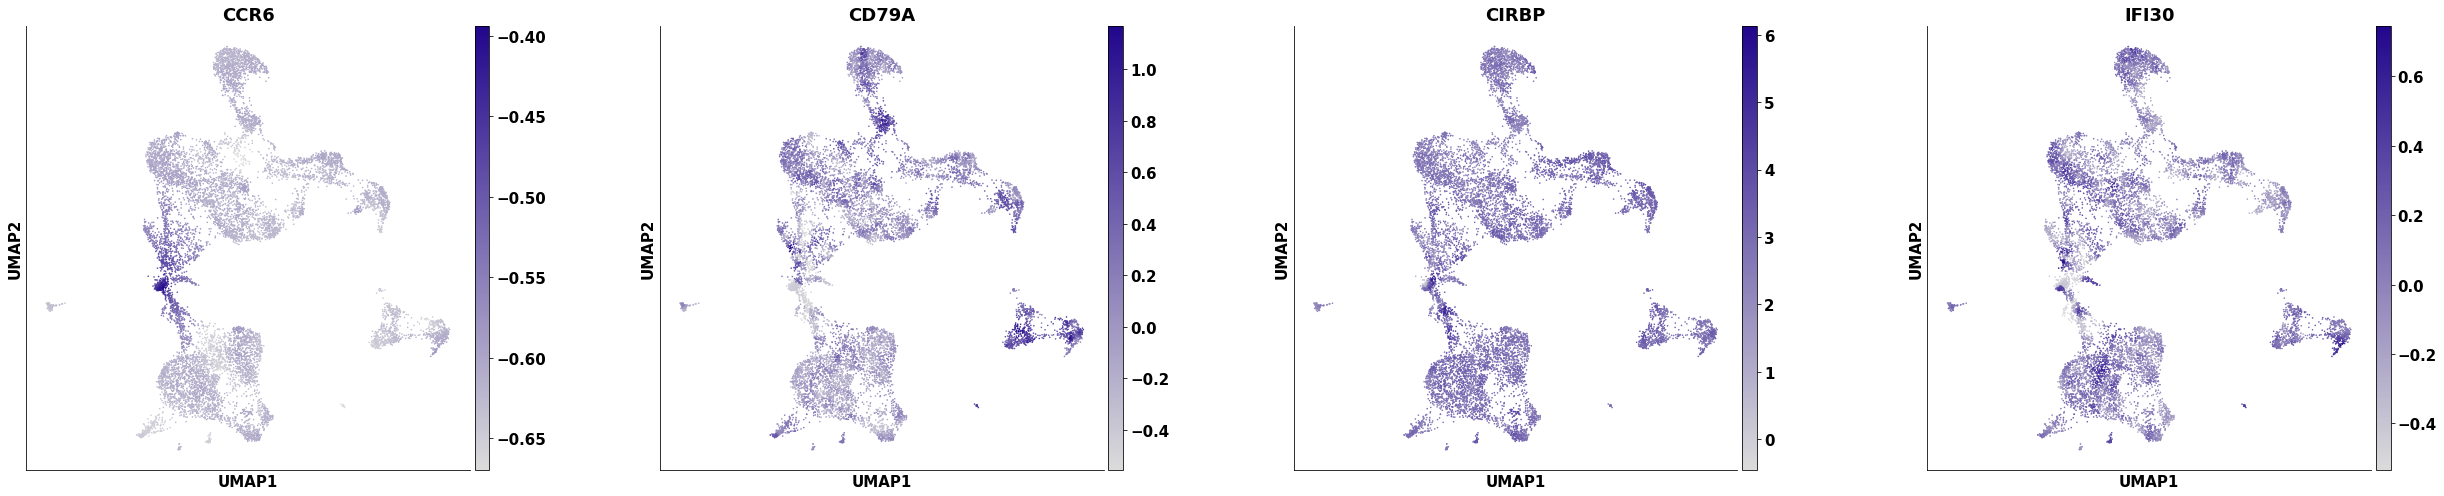

In [707]:
# for i in ['STAT1','CD86','IRF5','NOTCH1','CCDC107','IRF9']:
# for i in ['IRF9']:
# sc.pl.umap(plot_adata, color= ['SLAMF7','CD86','IRF5','NOTCH1','MS4A1','CD19','CD79A', 'IGKC'], wspace=0.3, color_map=regulation_cmp)
sc.pl.umap(plot_adata, color= ['CCR6','CD79A','CIRBP','IFI30'], wspace=0.3, color_map=regulation_cmp)

In [924]:
target_gene_list = []
target_gene_list += sub_RP_table_z.max(1).sort_values(ascending=False)[0:300].index.tolist()
target_gene_list += sub_RP_table_z.std(1).sort_values(ascending=False)[0:300].index.tolist()
target_gene_list = set(target_gene_list)
tg_list = [g for g in target_gene_list if g in rna_expr.columns] 

In [925]:
cell_barcode_rna = []
for cell in cells_intrest:
    cell_barcode_rna += rna_adata.obs[(rna_adata.obs['assign.ident']==cell)].index.tolist()


keys.index = keys['RNA']
cell_barcode_atac = keys.loc[cell_barcode_rna]['ATAC'].values

cell_barcode_atac = [i for i in cell_barcode_atac if i in pbmc_script_adata.obs.index]

keys.index = keys['ATAC']
cell_barcode_rna = keys.loc[cell_barcode_atac]['RNA'].values

In [926]:
tar_expr = rna_expr.loc[cell_barcode_rna,tg_list + [factor]].copy()

tf_RP = sub_RP_table_z.loc[tg_list,cell_barcode_atac].T

coor = []
pvalue = []
# rp_corr = []
for i in tf_RP.columns:
    tmp = sp.stats.spearmanr(tar_expr[factor], tar_expr[i])
    if not np.isnan(tmp.correlation):
        coor.append(tmp.correlation)
        pvalue.append(tmp.pvalue)
    else:
        coor.append(0)
        pvalue.append(1)
#     tmp1 = sp.stats.spearmanr(tf_RP[i], tar_expr[i])
#     rp_corr.append(tmp1.correlation)

tf_RP = sub_RP_table_z.loc[tg_list,cell_barcode_atac].T.median()

data = pd.DataFrame(np.array([coor,tf_RP, -np.log(pvalue)]).T, columns = ['corr', 'RP', '-log.p'], index = tg_list)

In [916]:
# tf_regu = pbmc_script_adata.obs['I_'+factor].loc[cell_barcode_atac,]

55


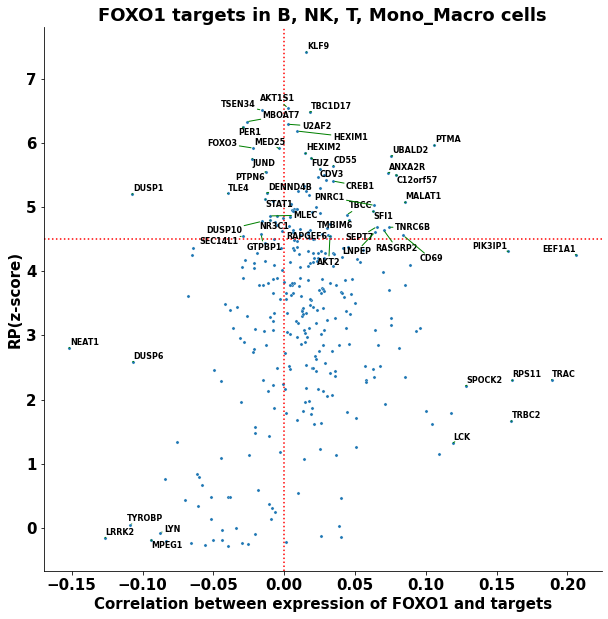

In [927]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.scatterplot(data=data, x = 'corr', y = 'RP', s=10)

x_q02 = data.iloc[:,0].quantile(0.98)
x_q25 = data.iloc[:,0].quantile(0.75)
x_q75 = data.iloc[:,0].quantile(0.25)
x_q98 = data.iloc[:,0].quantile(0.02)
y_q25 = data.iloc[:,1].quantile(0.75)
y_q05 = data.iloc[:,1].quantile(0.95)

texts = []
for i in range(len(data.index)):
    if data.iloc[i,0] > x_q02:
        texts.append(plt.text(data.iloc[i,0], data.iloc[i,1],  data.index[i], size=8))
    elif data.iloc[i,0] < x_q98:
        texts.append(plt.text(data.iloc[i,0], data.iloc[i,1],  data.index[i], size=8))
    elif data.iloc[i,1] > y_q05:
        texts.append(plt.text(data.iloc[i,0], data.iloc[i,1],  data.index[i], size=8))
    elif data.iloc[i,1] > y_q25 and data.iloc[i,0] > x_q25:
        texts.append(plt.text(data.iloc[i,0], data.iloc[i,1],  data.index[i], size=8))
    elif data.iloc[i,1] > y_q25 and data.iloc[i,0] < x_q75:
        texts.append(plt.text(data.iloc[i,0], data.iloc[i,1],  data.index[i], size=8))
print(texts.__len__())
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='green'))

for hl in [y_q25]:
    ax.axhline(hl, linestyle=':', color='red')
for vl in [0]:
    ax.axvline(vl, linestyle=':', color='red')
    
ax.set_xlabel('Correlation between expression of %s and targets' % factor)
ax.set_ylabel('RP(z-score)')
ax.set_title('%s targets in %s cells' % (factor, ', '.join(cells_intrest)))
fig.show()

In [426]:
kmeans = KMeans(n_clusters=7, random_state=0).fit(sub_RP_table)

In [ ]:
# sns.heatmap(sub_RP_table.iloc[0:100,:], xticklabels=False, yticklabels=False, cmap='RdBu_r')

RP11-134P9.3     42.470775
PSME2            41.784596
RNF31            41.532952
RP11-398A8.3     41.301670
GNAI2            39.421524
                   ...    
PRRT2            31.717071
RP11-440L14.1    31.664623
AC009133.23      31.606836
EIF4ENIF1        31.601642
RHOG             31.593741
Length: 100, dtype: float64

In [131]:
a = sub_RP_table.sum(axis=1).sort_values(ascending=False)

In [129]:
sub_RP_table

AAACTCGAGCGAATAT  AAACTCGAGTCTTAGC  AAAGGGCTCCATGTTT  \
A1BG                0.281810          0.242142          0.369600   
A1BG-AS1            0.266700          0.222594          0.345656   
A2ML1               0.007843          0.004991          0.009269   
A3GALT2             0.000840          0.000000          0.000000   
A4GALT              1.401102          0.972065          0.751330   
...                      ...               ...               ...   
ZSWIM4              0.565665          0.213596          0.702233   
ZSWIM8              0.048418          0.048418          0.110660   
ZSWIM8-AS1          0.144136          0.144136          0.329420   
ZYG11B              0.020776          0.012466          0.029087   
ZZEF1               9.743419          9.743419          9.743419   

            AAAGGGCTCTTGCGCT  AAATGCCAGCGTTGCC  AACAAAGGTAATGCAA  \
A1BG                0.177019          0.280370          0.203914   
A1BG-AS1            0.168841          0.255772          0.189417   
A2ML1               0.003565          0.004991          0.004278   
A3GALT2             0.000000          0.000000          0.000000   
A4GALT              1.483036          1.192243          1.038830   
...                      ...               ...               ...   
ZSWIM4              0.520143          0.120645          0.148340   
ZSWIM8              0.036314          0.060523          0.060523   
ZSWIM8-AS1          0.108102          0.180170          0.180170   
ZYG11B              0.027009          0.014543          0.012466   
ZZEF1               5.846051          3.897368          8.769077   

            AACAGTCCAGGCTACC  AACAGTCTCTCTTAAC  AACCAACTCTGACTTT  \
A1BG                0.215248          0.220914          0.143738   
A1BG-AS1            0.202018          0.208319          0.136500   
A2ML1               0.000713          0.003565          0.004278   
A3GALT2             0.000000          0.000000          0.000000   
A4GALT              0.833014          1.490917          1.684511   
...                      ...               ...               ...   
ZSWIM4              0.324375          0.575532          0.148340   
ZSWIM8              0.048802          0.060523          0.036314   
ZSWIM8-AS1          0.145279          0.180170          0.108102   
ZYG11B              0.016621          0.027009          0.010388   
ZZEF1               4.871709          4.871709          1.948684   

            AACCGATGTACGGATG  ...  TTGCTTATCTTCTTCC  TTGGTCCTCGAGGTAG  \
A1BG                0.143738  ...          0.094176          0.061615   
A1BG-AS1            0.136500  ...          0.090721          0.063845   
A2ML1               0.004278  ...          0.007130          0.003565   
A3GALT2             0.000000  ...          0.000840          0.000000   
A4GALT              1.684511  ...          2.489696          1.577759   
...                      ...  ...               ...               ...   
ZSWIM4              0.148340  ...          0.296680          0.176035   
ZSWIM8              0.036314  ...          0.096837          0.036314   
ZSWIM8-AS1          0.108102  ...          0.288271          0.108102   
ZYG11B              0.010388  ...          0.008310          0.010388   
ZZEF1               1.948684  ...         11.692103          1.948684   

            TTGTTCAAGGCCAGTA  TTGTTGTCATCGACGC  TTGTTGTCATTGAACC  \
A1BG                0.225861          0.276143          0.177739   
A1BG-AS1            0.209156          0.260399          0.174305   
A2ML1               0.006417          0.004991          0.002852   
A3GALT2             0.000000          0.000840          0.000000   
A4GALT              0.481178          1.484263          0.754147   
...                      ...               ...               ...   
ZSWIM4              0.176035          0.462848          0.213596   
ZSWIM8              0.012105          0.085495          0.084732   
ZSWIM8-AS1          0.036034          0.254509          0.252238   
ZYG1

In [ ]:
a[0:50]

In [ ]:
for i in [5, 10, 20, 50, 75, 100]:
    print(i)
    locals()['ret_cell_peak_%s' % str(i)] = cal_neighbor_cell_peak_mat_batch(input_mat, coor_table, i, 8)
    with open('example/10X_ATAC/RP_impute/impute_cell_peak_mat/ret_cell_peak_%s.pk' % str(i),'wb+') as f:
        pickle.dump(locals()['ret_cell_peak_%s' % str(i)], f)
    print_log('Finish saving.')

In [15]:
cells_list = input_mat.index.to_list()

# for i in [50, 75, 100]:
#     print(i)
#     with open('example/10X_ATAC/RP_impute/impute_cell_peak_mat/ret_cell_peak_%i.pk' % i,'rb+') as f:
#         ret_cell_peak = pickle.load(f)

#     cell_peaks_csr = sp.sparse.csr_matrix(ret_cell_peak)

    genes_peaks_score_csr = genes_peaks_score_dok.tocsr()
    genes_cells_score_csr = genes_peaks_score_csr.dot(ret_cell_peak.T)

    score_cells_dict = {}
    score_cells_sum_dict = {}

    for igene, gene in enumerate(genes_list):
        score_cells_dict[gene] = igene
        score_cells_sum_dict[gene] = genes_cells_score_csr[igene, :].sum()

    score_cells_dict_dedup = {}
    score_cells_dict_max = {}
    genes = list(set([i.split("@")[0] for i in genes_list]))
    for gene in genes:
        score_cells_dict_max[gene] = float("-inf")

    for gene in genes_list:
        symbol = gene.split("@")[0]
        if score_cells_sum_dict[gene] > score_cells_dict_max[symbol]:
            score_cells_dict_dedup[symbol] = score_cells_dict[gene]
            score_cells_dict_max[symbol] = score_cells_sum_dict[gene]
    gene_symbol = sorted(score_cells_dict_dedup.keys())
    matrix_row = []
    for gene in gene_symbol:
        matrix_row.append(score_cells_dict_dedup[gene])

    score_cells_matrix = genes_cells_score_csr[matrix_row, :]

    RP_table = pd.DataFrame(score_cells_matrix.todense(), index=gene_symbol, columns=cells_list)

    with open('example/10X_ATAC/RP_impute/RP_%s_cell.pk' %i, 'wb+') as f:
        pickle.dump(RP_table, f)

50
75
100


In [94]:
# write_10X_h5('example/10X_ATAC/RP_impute/RP_5_cell.h5', score_cells_matrix, gene_symbol, cells_list, genome=gene_bed.split("/")[-1].split("_")[0], datatype="Gene")

In [137]:
cell_peaks_csr = sp.sparse.csr_matrix(celltype_peak_mat)

genes_peaks_score_csr = genes_peaks_score_dok.tocsr()
genes_cells_score_csr = genes_peaks_score_csr.dot(cell_peaks_csr.T)

score_cells_dict = {}
score_cells_sum_dict = {}

for igene, gene in enumerate(genes_list):
    score_cells_dict[gene] = igene
    score_cells_sum_dict[gene] = genes_cells_score_csr[igene, :].sum()

score_cells_dict_dedup = {}
score_cells_dict_max = {}
genes = list(set([i.split("@")[0] for i in genes_list]))
for gene in genes:
    score_cells_dict_max[gene] = float("-inf")

for gene in genes_list:
    symbol = gene.split("@")[0]
    if score_cells_sum_dict[gene] > score_cells_dict_max[symbol]:
        score_cells_dict_dedup[symbol] = score_cells_dict[gene]
        score_cells_dict_max[symbol] = score_cells_sum_dict[gene]
gene_symbol = sorted(score_cells_dict_dedup.keys())
matrix_row = []
for gene in gene_symbol:
    matrix_row.append(score_cells_dict_dedup[gene])

score_cells_matrix = genes_cells_score_csr[matrix_row, :]

RP_table = pd.DataFrame(score_cells_matrix.todense(), index=gene_symbol, columns=cell_type)

with open('example/10X_ATAC/RP_impute/cluster_rp.pk' , 'wb+') as f:
    pickle.dump(RP_table, f)

In [ ]:
RP_table

In [24]:
# plot
# load dataset
with open('example/10X_ATAC/RP_impute/cluster_rp.pk' , 'rb+') as f:
    cluster_rp = pickle.load(f)
for i in [5,10,20,50,75,100]:
    with open('example/10X_ATAC/RP_impute/RP_%s_cell.pk' %i, 'rb+') as f:
        locals()['RP_%s_cell' %i] = pickle.load(f)

In [45]:
result_dict = {}
result_dict['cell_type']=[]
result_dict['impute_number']=[]
result_dict['difference_sum']=[]
result_dict['std.']=[]
for ct in cluster_rp.columns:
    ct_bc = seurat_adata.obs.index[seurat_adata.obs['assign.celltype'] == ct].to_list()
    tmp_cluster_mat = pd.DataFrame(np.zeros([cluster_rp.index.__len__(), ct_bc.__len__()]), index=cluster_rp.index, columns = ct_bc)
    for i in tmp_cluster_mat.columns:
        tmp_cluster_mat[i] = cluster_rp[ct]
    for impu in [5,10,20,50,75,100]:
        diff = abs(locals()['RP_%s_cell' % impu].loc[:,ct_bc] - tmp_cluster_mat).sum().mean()
        std = locals()['RP_%s_cell' % impu].loc[:,ct_bc].std(1)
        std = std[std!=0].mean()
        result_dict['cell_type'].append(ct)
        result_dict['impute_number'].append(impu)
        result_dict['difference_sum'].append(diff)
        result_dict['std.'].append(std)

In [51]:
result_frame = pd.DataFrame.from_dict(result_dict)
with open('example/10X_ATAC/RP_impute/result.pk', 'wb+') as f:
    pickle.dump(result_frame, f)

In [59]:
result_frame[result_frame['cell_type']=='Mono/Macro']

cell_type  impute_number  difference_sum      std.
0  Mono/Macro              5    75143.564980  0.351939
1  Mono/Macro             10    65312.304338  0.367111
2  Mono/Macro             20    54337.776462  0.362915
3  Mono/Macro             50    39596.649533  0.346345
4  Mono/Macro             75    33217.711931  0.332186
5  Mono/Macro            100    28861.766474  0.318797

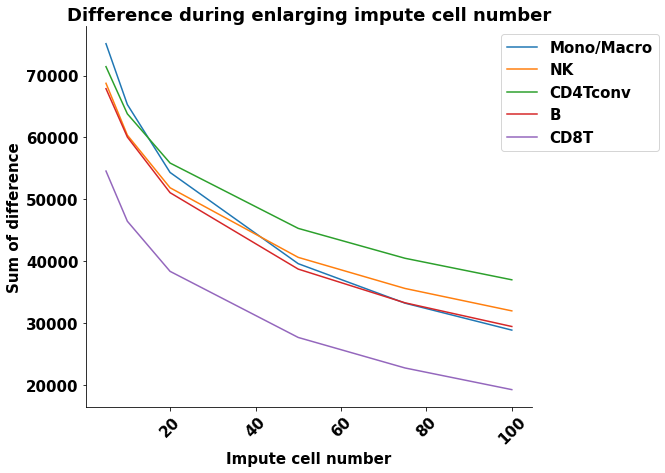

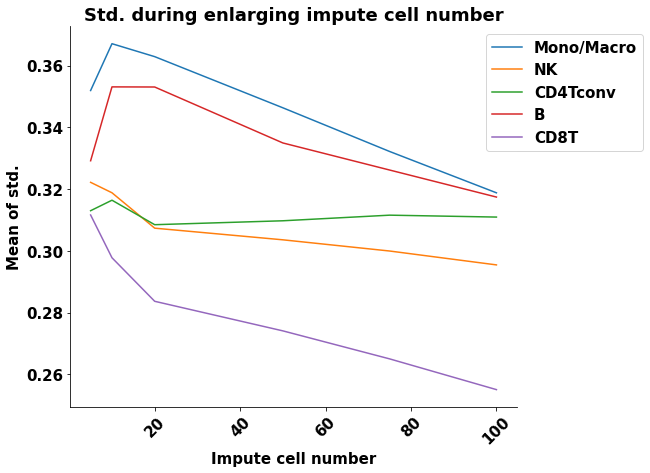

In [90]:
fig, ax = plt.subplots(figsize=(8,7))
sns.lineplot(data=result_frame, x="impute_number", y="difference_sum", hue='cell_type')
plt.xticks(rotation=45)
ax.legend(bbox_to_anchor=(1.3, 1.0))
ax.set_xlabel('Impute cell number')
ax.set_ylabel('Sum of difference')
ax.set_title('Difference during enlarging impute cell number')
fig.show()
fig, ax = plt.subplots(figsize=(8,7))
sns.lineplot(data=result_frame, x="impute_number", y="std.", hue='cell_type')
plt.xticks(rotation=45)
ax.legend(bbox_to_anchor=(1.3, 1.0))
ax.set_xlabel('Impute cell number')
ax.set_ylabel('Mean of std.')
ax.set_title('Std. during enlarging impute cell number')
fig.show()

In [73]:
for i in [5,10,20,50,75,100]:
    with open('example/10X_ATAC/RP_impute/impute_cell_peak_mat/ret_cell_peak_%s.pk' % str(i),'rb+') as f:
        locals()['ret_cell_peak_%s' % str(i)] = pickle.load(f)

In [86]:
peak_number = []
for i in [5,10,20,50,75,100]:
    peak_number.append(locals()['ret_cell_peak_%s' % str(i)].sum(1).mean())


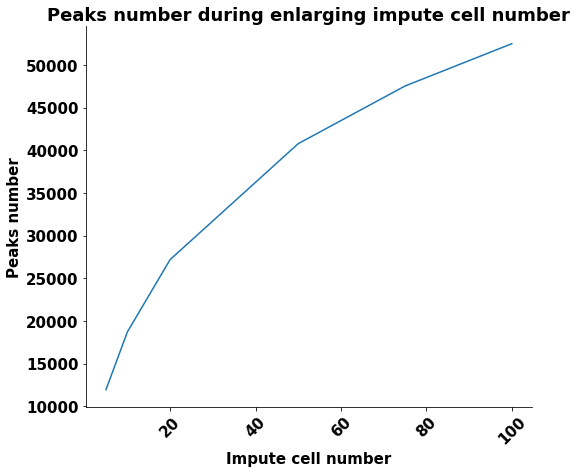

In [89]:
fig, ax = plt.subplots(figsize=(8,7))
sns.lineplot(x=[5,10,20,50,75,100], y=peak_number)
plt.xticks(rotation=45)
ax.set_xlabel('Impute cell number')
ax.set_ylabel('Peaks number')
ax.set_title('Peaks number during enlarging impute cell number')
fig.show()

In [ ]:
# plot peak

In [12]:
item = {}
for i in seurat_adata.obs['assign.ident'].unique():
    item[i]=(seurat_adata.obs[seurat_adata.obs['assign.ident'] == i].__len__())

In [41]:
seurat_adata.obs[seurat_adata.obs['assign.ident'] == i].index

427

In [40]:
item

{'CD4Tconv': 2201, 'Mono/Macro': 2920, 'NK': 1240, 'B': 785, 'CD8T': 427}

In [42]:
for k in item.keys():
    generate_beds('example/10X_ATAC/activate_impute/result/foreground/'+k.replace('/','_')+'.bed', seurat_adata.obs[seurat_adata.obs['assign.ident'] == k].index.tolist(), pbmc_10X_inputMat, 5)

In [44]:
for k in item.keys():
    search_giggle('example/10X_ATAC/activate_impute/result/foreground/'+k.replace('/','_')+'.bed.gz', 'example/10X_ATAC/activate_impute/result/foreground/txt/chip/'+k.replace('/','_')+'.txt', human_chip_index)
    search_giggle('example/10X_ATAC/activate_impute/result/foreground/'+k.replace('/','_')+'.bed.gz', 'example/10X_ATAC/activate_impute/result/foreground/txt/motif/'+k.replace('/','_')+'.txt', human_motif_index)

In [16]:
for k in item.keys():
    generate_background_bed(pbmc_10X_inputMat, 'example/10X_ATAC/activate_impute/'+k.replace('/','_'), 'example/10X_ATAC/activate_impute/'+k.replace('/','_')+'.pk', step=item[k], iteration=1000, peak_confidence=5, n_cores=8)

INFO 2021-02-27 20:13:59 Start generating background beds ...
INFO 2021-02-27 20:46:27 Finished generating background beds!
INFO 2021-02-27 20:46:27 Start generating background beds ...
INFO 2021-02-27 21:23:20 Finished generating background beds!
INFO 2021-02-27 21:23:20 Start generating background beds ...
INFO 2021-02-27 21:45:27 Finished generating background beds!
INFO 2021-02-27 21:45:27 Start generating background beds ...
INFO 2021-02-27 22:02:05 Finished generating background beds!
INFO 2021-02-27 22:02:05 Start generating background beds ...
INFO 2021-02-27 22:15:03 Finished generating background beds!


In [17]:
for k in item.keys():
    search_giggle_batch('example/10X_ATAC/activate_impute/'+k.replace('/','_'), 'example/10X_ATAC/activate_impute/result/'+k.replace('/','_')+'_chip', human_chip_index, n_cores=8)
    search_giggle_batch('example/10X_ATAC/activate_impute/'+k.replace('/','_'), 'example/10X_ATAC/activate_impute/result/'+k.replace('/','_')+'_motif', human_motif_index, n_cores=8) 

In [21]:
for k in item.keys():
    result_chip = read_giggle_result_batch('example/10X_ATAC/activate_impute/result/'+k.replace('/','_')+'_chip', n_cores=8)
    with open('example/10X_ATAC/activate_impute/result/'+k.replace('/','_')+'_chip.pk','wb') as result_file:
        pickle.dump(result_chip, result_file)
    result_motif = read_giggle_result_batch('example/10X_ATAC/activate_impute/result/'+k.replace('/','_')+'_motif', n_cores=8)
    with open('example/10X_ATAC/activate_impute/result/'+k.replace('/','_')+'_motif.pk','wb') as result_file:
        pickle.dump(result_motif, result_file)

INFO 2021-03-01 09:52:39 Reading searching results, using 8 cores...
INFO 2021-03-01 09:52:48 Reading searching results, using 8 cores...
INFO 2021-03-01 09:52:52 Reading searching results, using 8 cores...
INFO 2021-03-01 09:53:04 Reading searching results, using 8 cores...
INFO 2021-03-01 09:53:09 Reading searching results, using 8 cores...
INFO 2021-03-01 09:53:14 Reading searching results, using 8 cores...
INFO 2021-03-01 09:53:20 Reading searching results, using 8 cores...
INFO 2021-03-01 09:53:28 Reading searching results, using 8 cores...
INFO 2021-03-01 09:53:31 Reading searching results, using 8 cores...
INFO 2021-03-01 09:53:41 Reading searching results, using 8 cores...


In [25]:
for k in item.keys():
    with open('example/10X_ATAC/activate_impute/result/'+k.replace('/','_')+'_chip.pk','rb') as result_file:
        result_chip = pickle.load(result_file)
    factor_result_chip = map_factor_on_ChIP(result_chip)
    with open('example/10X_ATAC/activate_impute/result/'+k.replace('/','_')+'_chip_factor.pk','wb') as result_file:
        pickle.dump(factor_result_chip, result_file)        

INFO 2021-03-01 11:20:25 Summary result from dataset level to factor level.
INFO 2021-03-01 11:20:26 Summary result from dataset level to factor level.
INFO 2021-03-01 11:20:28 Summary result from dataset level to factor level.
INFO 2021-03-01 11:20:30 Summary result from dataset level to factor level.
INFO 2021-03-01 11:20:34 Summary result from dataset level to factor level.


In [45]:
cell_type_table = read_giggle_result_batch('example/10X_ATAC/activate_impute/result/foreground/txt/chip', n_cores=1)

INFO 2021-03-01 14:01:45 Reading searching results, using 1 cores...


In [48]:
with open('example/10X_ATAC/activate_impute/result/CD4Tconv_chip.pk','rb') as result_file:
    bg_table = pickle.load(result_file)
cal_rank(cell_type_table['CD4Tconv'][0], bg_table.loc[0,:])

INFO 2021-03-01 14:25:28 chunk 1 calculating ...


IndexingError: Too many indexers

In [61]:
mat = []
for i,k in enumerate(item.keys()):
    n = k.replace('/','_')

    l = []
    with open('example/10X_ATAC/activate_impute/result/%s_chip.pk' % n,'rb') as result_file:
        bg_table = pickle.load(result_file)
    for i in range(cell_type_table[n].__len__()):
        l.append(cal_rank(cell_type_table[n][i], bg_table.iloc[i,:]))
    mat.append(l)

In [ ]:
cell_type_table

In [78]:
with open('example/10X_ATAC/activate_impute/result/chip_dataset_celltype_table.pk','wb') as file:
    pickle.dump(cell_type_table, file)

In [73]:
df = pd.DataFrame(mat).T

In [79]:
with open('example/10X_ATAC/activate_impute/result/chip_dataset_celltype_rank_table.pk','wb') as file:
    pickle.dump(df, file)

In [88]:
for i in [5,10,20,50,75,100]:
    tmp = sc.read_h5ad('example/10X_ATAC/SCRIPT_result_20210125_%s/10X_ATAC_script_computed_20210111.h5ad' %i)
    locals()['enrich_%s_table' %i ] = tmp.uns['ChIP_p'].T

In [89]:
enrich_5_table

AACCTTTCATGGTTTG  AAACTGCGTTTGGATC  AACAGTCAGGTTAACA  \
AATF                0.972             0.063             0.501   
ADNP                0.468             0.087             0.580   
AEBP2               0.862             0.673             0.437   
AFF1                0.889             0.289             0.281   
AFF4                0.955             0.480             0.557   
...                   ...               ...               ...   
ZSCAN5B             0.857             0.698             0.559   
ZTA                 0.657             0.362             0.496   
ZXDB                0.993             0.723             0.529   
ZXDC                0.530             0.575             0.484   
ZZZ3                0.883             0.142             0.825   

         AATACGCCAAGTGGCA  AAACTGCAGTTATGAG  AGCCGCAGTTGGGAAC  \
AATF                0.934             0.268             0.948   
ADNP                0.194             0.001             0.598   
AEBP2               0.786             0.002             0.942   
AFF1                0.322             0.001             0.987   
AFF4                0.965             0.001             0.931   
...                   ...               ...               ...   
ZSCAN5B             0.717             0.206             0.965   
ZTA                 0.045             0.778             0.420   
ZXDB                0.990             0.001             0.990   
ZXDC                0.956             0.001             0.888   
ZZZ3                0.941             0.164             0.873   

         ATAGTCGTCAGGTCTA  AGTGCGCTCCGGGCAT  AGCGTATCATCCCAAA  \
AATF                0.917             0.650             0.954   
ADNP                0.900             0.506             0.734   
AEBP2               0.898             0.588             0.707   
AFF1                0.760             0.481             0.128   
AFF4                0.851             0.544             0.874   
...                   ...               ...               ...   
ZSCAN5B             0.862             0.738             0.960   
ZTA                 0.635             0.318             0.936   
ZXDB                0.945             0.785             0.709   
ZXDC                0.940             0.461             0.647   
ZZZ3                0.779             0.600             0.282   

         ACAAACCCATCAGAAA  ...  TTGGTCCTCGACTCGG  TTTACGTTCGTAGCGC  \
AATF                0.022  ...             0.466             0.168   
ADNP                0.023  ...             0.542             0.005   
AEBP2               0.022  ...             0.152             0.003   
AFF1                0.017  ...             0.027             0.001   
AFF4                0.028  ...             0.231             0.001   
...                   ...  ...               ...               ...   
ZSCAN5B             0.001  ...             0.638             0.022   
ZTA                 0.140  ...             0.560             0.537   
ZXDB                0.094  ...             0.243             0.004   
ZXDC                0.190  ...             0.061             0.002   
ZZZ3                0.015  ...             0.132             0.101   

         TTACTTGTCCTGTAGA  TTATGTCTCGTTGTAG  TTCGGTCGTTGGGAAC  \
AATF                0.289             0.294             0.363   
ADNP                0.548             0.216             0.022   
AEBP2               0.945             0.870             0.037   
AFF1                0.053             0.405             0.065   
AFF4                0.973             0.275             0.061   
...                   ...               ...               ...   
ZSCAN5B             0.741             0.435             0.123   
ZTA                 0.066             0.229             0.930   
ZXDB                0.998             0.868             0.096   
ZXDC                0.976             0.913             0.094   
ZZZ3                0.979             0.466             0.134   

         TTGCGAAAGTCAGGAC  TTGGTCCTCCGAGAGA 

In [90]:
cluster_enrich = map_factor_on_ChIP(df)

INFO 2021-03-01 16:45:24 Summary result from dataset level to factor level.


In [95]:
cluster_enrich.columns = ['CD4Tconv','Mono/Macro','NK','B','CD8T']

In [96]:
result_dict = {}
result_dict['cell_type']=[]
result_dict['impute_number']=[]
result_dict['difference_sum']=[]
result_dict['std.']=[]
for ct in cluster_enrich.columns:
#     ct = ct.replace('_','/')
    ct_bc = seurat_adata.obs.index[seurat_adata.obs['assign.celltype'] == ct].to_list()
    tmp_cluster_mat = pd.DataFrame(np.zeros([cluster_enrich.index.__len__(), ct_bc.__len__()]), index=cluster_enrich.index, columns = ct_bc)
    for i in tmp_cluster_mat.columns:
        tmp_cluster_mat[i] = cluster_enrich[ct]
    for impu in [5,10,20,50,75,100]:
        diff = abs(locals()['enrich_%s_table' % impu].loc[:,ct_bc] - tmp_cluster_mat).sum().mean()
        std = locals()['enrich_%s_table' % impu].loc[:,ct_bc].std(1)
        std = std[std!=0].mean()
        result_dict['cell_type'].append(ct)
        result_dict['impute_number'].append(impu)
        result_dict['difference_sum'].append(diff)
        result_dict['std.'].append(std)

In [99]:
result_frame = pd.DataFrame.from_dict(result_dict)
with open('example/10X_ATAC/activate_impute/chip_final_result.pk', 'wb+') as f:
    pickle.dump(result_frame, f)

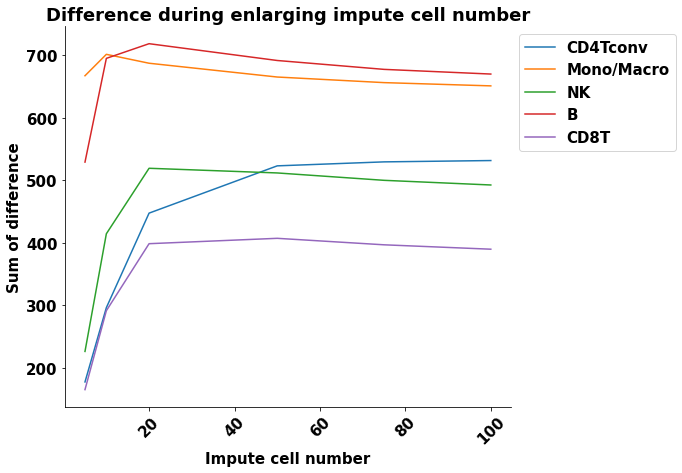

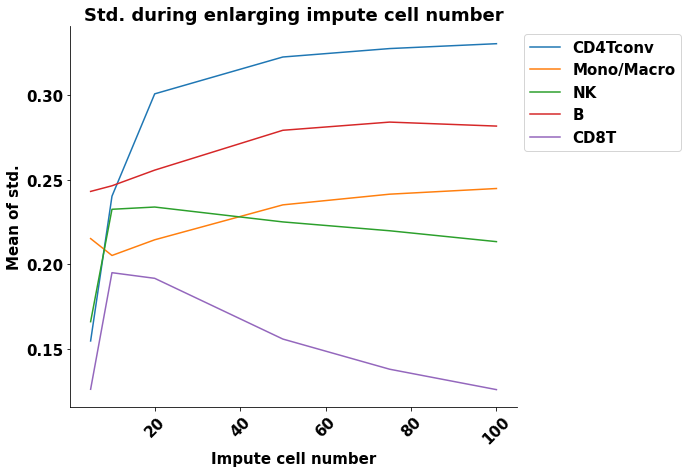

In [103]:
fig, ax = plt.subplots(figsize=(8,7))
sns.lineplot(data=result_frame, x="impute_number", y="difference_sum", hue='cell_type')
plt.xticks(rotation=45)
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.set_xlabel('Impute cell number')
ax.set_ylabel('Sum of difference')
ax.set_title('Difference during enlarging impute cell number')
fig.show()
fig, ax = plt.subplots(figsize=(8,7))
sns.lineplot(data=result_frame, x="impute_number", y="std.", hue='cell_type')
plt.xticks(rotation=45)
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.set_xlabel('Impute cell number')
ax.set_ylabel('Mean of std.')
ax.set_title('Std. during enlarging impute cell number')
fig.show()

----------
previous code

In [ ]:
CD4T_cluster = input_mat.loc[seurat_adata.obs[seurat_adata.obs['assign.celltype']=="CD4Tconv"].index,:]

In [194]:
CD4T_cluster.index

Index(['AAACGAAAGACACGGT', 'AAACGAAAGCTTTCCC', 'AAACGAAAGGCGTCCT',
       'AAACGAAAGTTTGGAA', 'AAACGAACAAACGACG', 'AAACGAATCCAACGCG',
       'AAACGAATCCATCTAT', 'AAACGAATCGGGACAA', 'AAACGAATCTGAACGT',
       'AAACTCGAGAAAGCAG',
       ...
       'TTTGGCCGTGACCAGA', 'TTTGGCCTCGCTCTAC', 'TTTGGTTAGTAATCAG',
       'TTTGGTTGTCAACAGG', 'TTTGGTTGTCGAGGAT', 'TTTGGTTGTCTGCGCA',
       'TTTGGTTGTTCTGAAC', 'TTTGGTTTCAGGCGCT', 'TTTGTGTGTGGCGCTT',
       'TTTGTGTTCGCGCTGA'],
      dtype='object', length=2201)

In [185]:
factor = 'STAT4'

In [195]:
cell_ch = pbmc_script_adata.uns['integrated_z'].loc[CD4T_cluster.index,:].sort_values(by='I_' + factor, ascending=False)['I_' + factor].index.to_list()[0]

In [196]:
cell_ch

'CCTGGGACAACCTCCT'

In [206]:
motif_pattern = get_motif_pattern_from_minimal('/mnt/Storage2/home/dongxin/Projects/motif/human_cisBP/meme/%s.meme' % factor)
result = pd.read_csv('example/10X_ATAC/temp/test/fg_chip_result/%s.txt' % cell_ch, sep='\t', index_col = False).sort_values('combo_score', ascending=False)
bulk_bed = result[[factor in i for i in result['#file']]]['#file'].to_list()[0]
# CGGACCATCCACACCT = pyranges.read_bed('10X_ATAC/temp/test/fg_bed/CGGACCATCCACACCT.bed.gz')
bulk_peak = pyranges.read_bed('/mnt/Storage/home/dongxin/Projects/scATAC/human/top10k/' + bulk_bed)
cell_peak = pyranges.from_dict(pd.DataFrame([i.split('_') for i in input_mat.index[input_mat.loc[:,cell_ch] >= 1]]).rename(columns={0:'Chromosome', 1:'Start', 2:'End'}))
cell_peak_ovlp_with_bluk = cell_peak.overlap(bulk_peak)

cell_peak_unique = cell_peak.overlap(bulk_peak, invert=True)
cell_peak_unique_motif = filter_motif_peaks(cell_peak_unique,motif_pattern)
tmp = pyranges.from_dict(pd.concat([cell_peak_unique_motif, cell_peak_ovlp_with_bluk.df]))

In [208]:
tmp.to_bed('example/10X_ATAC/temp/%s_%s.bed' % (factor, cell_ch))

In [210]:
os.system('python ~/Projects/cidc_chips/modules/scripts/targets_RegPotential_Version2.py -p example/10X_ATAC/temp/%s_%s.bed -a /mnt/Storage/home/dongxin/Storage2/Files/ref_files/hg38/hg38_refGene.bed -n example/10X_ATAC/temp/%s_%s_gene_score.txt' % (factor, cell_ch,factor, cell_ch))

0

In [153]:
peak = pd.concat([cell_peak_unique_motif, cell_peak_ovlp_with_bluk.df])

Chromosome      Start        End
1          chr1  103525148  103526464
2          chr1  107940936  107941713
3          chr1  108041499  108042115
5          chr1  108561836  108562005
7          chr1  109041377  109042498
...         ...        ...        ...
1003       chrX   47144364   47145706
1004       chrX   49155865   49156655
1005       chrX   54639307   54640093
1006       chrX   72572385   72573360
1007       chrX    7927010    7927906

[5851 rows x 3 columns]

In [445]:
# result = read_SingleCellExperiment_rds('example/small_HSC/HSC_single_cell_experiment.rds')
result.write_h5ad('example/small_HSC/HSC_single_cell_experiment.h5ad')

In [451]:
result.obs

orig.ident  nCount_ATAC  \
singles-BM0828-CMP-frozen-1511     example/small_HSC/ATAC       1805.0   
BM1077-CMP-Frozen-160106-3         example/small_HSC/ATAC       3671.0   
singles-20160617-scATAC-BM1077     example/small_HSC/ATAC       8163.0   
singles-160818-BM1137-pDC-LS-7     example/small_HSC/ATAC      14085.0   
singles-20160617-scATAC-BM1077.1   example/small_HSC/ATAC       5320.0   
...                                                   ...          ...   
singles-BM1214-MCP-frozen-1601.95  example/small_HSC/ATAC       2393.0   
singles-20160726-scATAC-BM1214.89  example/small_HSC/ATAC       3425.0   
singles-20160726-scATAC-BM1214.90  example/small_HSC/ATAC       3184.0   
BM1077-GMP-Frozen-160107-61        example/small_HSC/ATAC       3402.0   
singles-PB1022-mono-160128-74      example/small_HSC/ATAC       6536.0   

                                   nFeature_ATAC ATAC_snn_res.0.6  \
singles-BM0828-CMP-frozen-1511              1805                0   
BM1077-CMP-Frozen-160106-3                  3671                0   
singles-20160617-scATAC-BM1077              8163                1   
singles-160818-BM1137-pDC-LS-7             14085                6   
singles-20160617-scATAC-BM1077.1            5320                1   
...                                          ...              ...   
singles-BM1214-MCP-frozen-1601.95           2393                6   
singles-20160726-scATAC-BM1214.89           3425                0   
singles-20160726-scATAC-BM1214.90           3184                7   
BM1077-GMP-Frozen-160107-61                 3402                5   
singles-PB1022-mono-160128-74               6536                8   

                                  seurat_clusters ident  
singles-BM0828-CMP-frozen-1511                  0     0  
BM1077-CMP-Frozen-160106-3                      0     0  
singles-20160617-scATAC-BM1077                  1     1  
singles-160818-BM1137-pDC-LS-7                  6     6  
singles-20160617-scATAC-BM1077.1                1     1  
...                                           ...   ...  
singles-BM1214-MCP-frozen-1601.95               6     6  
singles-20160726-scATAC-BM1214.89               0     0  
singles-20160726-scATAC-BM1214.90               7     7  
BM1077-GMP-Frozen-160107-61                     5     5  
singles-PB1022-mono-160128-74                   8     8  

[2592 rows x 6 columns]

In [477]:
data = sc.read_10x_h5('example/small_HSC/GSE96772_HSC_merged_count.h5', gex_only=False )
data.obs_names_make_unique(join='.')

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [478]:
data.write_h5ad('example/small_HSC/GSE96772_HSC_merged_count.h5')

Empty DataFrame
Columns: []
Index: [singles-BM0828-CMP-frozen-1511, BM1077-CMP-Frozen-160106-3, singles-20160617-scATAC-BM1077, singles-160818-BM1137-pDC-LS-7, singles-20160617-scATAC-BM1077.1, singles-BM0828-HSC-fresh-15102, singles-PB1022-mono-160128-36, singles-160822-BM1137-CMP-LS-1, singles-BM1214-GMP-160421-53, singles-20160726-scATAC-BM1137, singles-BM0828-MPP-frozen-1511, singles-BM0828-LMPP-frozen-151, singles-BM0828-GMP-151027-68, singles-160809-scATAC-BM1137-G, singles-BM0106-HSC-LS-160219-6, singles-MEP-141017-90, singles-MEP-141017-95, singles-BM0828-CMP-frozen-1511.1, singles-BM1214-MCP-frozen-1601, singles-BM1214-GMP-160421-81, BM1077-MPP-Frozen-160105-60, singles-BM0828-LMPP-frozen-151.1, BM1077-MEP-Frozen-160107-9, BM1077-HSC-Frozen-160105-6, singles-BM0106-UNK-160418-63, BM1077-CLP-Frozen-160106-38, singles-BM0828-LMPP-frozen-151.2, singles-BM0828-CLP-frozen-1511, singles-BM0828-LMPP-frozen-151.3, singles-BM0828-MEP-160420-51, singles-20160726-scATAC-BM1137.1, singles-BM0106-UNK-160418-55, singles-20160617-scATAC-BM1214, singles-BM0106-HSC-SIM-160219-, singles-BM1214-GMP-160421-48, singles-BM1214-GMP-160421-22, singles-BM0828-GMP-151027-40, singles-20160726-scATAC-BM1214, singles-BM0828-CLP-frozen-1511.1, singles-160818-BM1137-pDC-LS-6, singles-BM0828-MEP-160420-7, singles-20160726-scATAC-BM1214.1, singles-160818-BM1137-pDC-LS-9, singles-160808-scATAC-BM1137-G, singles-160819-BM1137-CMP-LS-4, singles-160808-scATAC-BM1137-G.1, singles-PB1022-mono-160128-40, singles-BM0106-HSC-SIM-160219-.1, singles-160819-BM1137-CMP-LS-6, singles-PB1022-mono-160128-24, BM1077-HSC-Frozen-160105-87, BM1077-HSC-Frozen-160105-27, singles-BM0828-CMP-frozen-1511.2, singles-160808-scATAC-BM1137-G.2, singles-160809-scATAC-BM1137-G.1, BM1077-HSC-Frozen-160105-20, singles-BM0828-MPP-frozen-1511.1, singles-BM0828-LMPP-frozen-151.4, singles-BM0828-CLP-frozen-1511.2, singles-20160617-scATAC-BM1077.2, singles-BM1214-MCP-frozen-1601.1, singles-160809-scATAC-BM1137-G.2, singles-160808-scATAC-BM1137-G.3, BM1077-MEP-Frozen-160107-1, singles-20160617-scATAC-BM1077.3, BM1077-HSC-Frozen-160105-62, singles-20160617-scATAC-BM1077.4, singles-BM0828-MEP-160420-95, singles-BM0828-CLP-frozen-1511.3, singles-BM0828-GMP-151027-61, singles-BM0828-GMP-151027-24, singles-BM0828-HSC-fresh-15102.1, singles-BM0106-HSC-LS-160219-4, singles-20160726-scATAC-BM1137.2, singles-BM0106-HSC-SIM-160219-.2, singles-BM1214-GMP-160421-64, singles-20160726-scATAC-BM1137.3, singles-BM0828-MEP-160420-82, singles-160822-BM1137-CMP-LS-4, singles-20160726-scATAC-BM1137.4, singles-20160726-scATAC-BM1214.2, singles-BM0828-LMPP-frozen-151.5, singles-BM0106-UNK-160418-56, BM1077-CLP-Frozen-160106-85, singles-160818-BM1137-pDC-LS-9.1, BM1077-HSC-Frozen-160105-7, singles-160809-scATAC-BM1137-G.3, singles-20160617-scATAC-BM1214.1, singles-BM0106-HSC-SIM-160219-.3, singles-BM0106-UNK-160418-36, singles-160819-BM1137-CMP-LS-1, singles-BM1214-MCP-frozen-1601.2, singles-160808-scATAC-BM1137-G.4, BM1077-CLP-Frozen-160106-3, singles-BM0106-UNK-160418-1, singles-160822-BM1137-CMP-LS-9, singles-20160617-scATAC-BM1214.2, singles-BM0828-MEP-160420-94, singles-20160726-scATAC-BM1214.3, BM1077-CLP-Frozen-160106-82, ...]

[2738 rows x 0 columns]

In [3]:
def peak_norm_matrix(index_peak_number_path, peaks_number_path):
    index_peak_number = pd.read_csv(index_peak_number_path, sep='\t', header=None, index_col=0)
    data_peak_number = pd.read_csv(peaks_number_path, sep='\t', header=None, index_col=0)

    peak_cell_index_norm_table = pd.DataFrame(np.zeros([index_peak_number.index.__len__(), data_peak_number.index.__len__()]),
                                              index=index_peak_number.index, columns=data_peak_number.index)
    
    for dts in peak_cell_index_norm_table.index:
        dts_number = index_peak_number.loc[dts, 1]
        peak_cell_index_norm_table.loc[dts, :] = [i/dts_number if i <= dts_number else dts_number/i for i in data_peak_number[1]]
    peak_cell_index_norm_table = peak_cell_index_norm_table.reindex(index=index_peak_number.index, columns=data_peak_number.index)

    peak_number_dts_mean_value = data_peak_number[1].mean()
    peak_number_dts_norm_series = data_peak_number[1].apply(lambda x: 2**-(abs(x-peak_number_dts_mean_value)/x))
    peak_number_dts_norm_series = peak_number_dts_norm_series.reindex(index=data_peak_number.index)
    
    peak_number_norm_coef = peak_cell_index_norm_table * peak_number_dts_norm_series

    return peak_number_norm_coef

In [5]:
peak_norm_matrix('/mnt/Storage/home/dongxin/Projects/scATAC/index/human_ChIP_index/peaks_number.txt', 'example/small_HSC/small_HSC_SCRIPT_20210606/enrichment/fg_files/fg_peaks_number.txt')

0            singles-BM1214-GMP-160421-79  singles-BM0106-HSC-LS-160219-1  \
0                                                                           
1006_EOMES                       0.752326                        0.550289   
1007_EP300                       0.752552                        0.550454   
1010_FOXH1                       0.753155                        0.550895   
1011_FOXH1                       0.756716                        0.553500   
1012_FOXP1                       0.759314                        0.555400   
...                                   ...                             ...   
9509_TFAP2C                      0.753230                        0.550950   
9510_TFAP2C                      0.752476                        0.550399   
955_NANOG                        0.752928                        0.550730   
966_PRDM14                       0.761004                        0.556636   
9_TCF4                           0.213873                        0.427737   

0            singles-BM1214-MCP-frozen-160128-35  \
0                                                  
1006_EOMES                              0.683618   
1007_EP300                              0.683823   
1010_FOXH1                              0.684371   
1011_FOXH1                              0.687607   
1012_FOXP1                              0.689967   
...                                          ...   
9509_TFAP2C                             0.684439   
9510_TFAP2C                             0.683754   
955_NANOG                               0.684165   
966_PRDM14                              0.691503   
9_TCF4                                  0.284294   

0            singles-BM0828-CLP-frozen-151103-33  \
0                                                  
1006_EOMES                              0.085193   
1007_EP300                              0.085219   
1010_FOXH1                              0.085287   
1011_FOXH1                              0.085690   
1012_FOXP1                              0.085984   
...                                          ...   
9509_TFAP2C                             0.085295   
9510_TFAP2C                             0.085210   
955_NANOG                               0.085261   
966_PRDM14                              0.086176   
9_TCF4                                  0.326062   

0            singles-BM1214-MCP-frozen-160128-28  \
0                                                  
1006_EOMES                              0.672190   
1007_EP300                              0.672391   
1010_FOXH1                              0.672930   
1011_FOXH1                              0.676112   
1012_FOXP1                              0.678433   
...                                          ...   
9509_TFAP2C                             0.672997   
9510_TFAP2C                             0.672324   
955_NANOG                               0.672728   
966_PRDM14                              0.679943   
9_TCF4                                  0.301578   

0            singles-BM1214-MCP-frozen-160128-18  \
0                                                  
1006_EOMES                              0.072193   
1007_EP300                              0.072215   
1010_FOXH1                              0.072273   
1011_FOXH1                              0.072615   
1012_FOXP1                              0.072864   
...                                          ...   
9509_TFAP2C                             0.072280   
9510_TFAP2C                             0.072208   
955_NANOG                               0.072251   
966_PRDM14                              0.073026   
9_TCF4                                  0.276308   

0            singles-20160726-scATAC-BM1137-GMP3high-HYC-36  \
0                                                             
1006_EOMES                                         0.246514   
1007_EP300                                         0.246588   
1010_FOXH1                            